<a href="https://colab.research.google.com/github/Giorgia3/bert-covid/blob/main/esperimento_journal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer su dati covid

### Setup

In [1]:
do_training = False
do_test = True
do_finetuning = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers
!pip install -q tf-models-official==2.4.0
!pip install biopython
!pip install pysam
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 115.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import InputExample, InputFeatures, TrainingArguments, Trainer
import os.path
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import csv
import numpy as np
import numpy.ma as ma
from numpy.linalg import matrix_rank
import pandas as pd
from tqdm import tqdm
from enum import Enum
import tensorflow as tf
import itertools
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn
import torch.nn.functional
import json
import tensorflow_hub as hub
import keras.backend as KB
from tensorflow.keras.callbacks import Callback
from official import nlp
import official.nlp.optimization
import time
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TABLEAU_COLORS
from matplotlib.ticker import FuncFormatter, PercentFormatter
%matplotlib inline
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
import matplotlib.cm as cm
from cycler import cycler
import seaborn as sns
import itertools
from linecache import getline
from pathlib import Path
import math
import gc
import json
import subprocess
import shlex
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import pysam
import pickle
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import collections
from scipy.stats import chisquare
import scipy.stats as stats
import plotly.express as px
import linecache
from os import write
from tabulate import tabulate
import networkx as nx

<ipython-input-4-2ddc803ae953>:37: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


In [5]:
!python --version
print(torch.__version__)

Python 3.8.10
1.13.1+cu116


#### Configuration

In [6]:
config_dict = {}
config_dict['USE_GPU'] = True
# USE_TPU = False
config_dict['TASK_TYPE'] = 'singularvalues_ratio_analysis' # options:{'singularvalues_ratio_analysis', 'attention_flow', 'simple_test', 'distance_cones_analysis', 'attention_analysis', 'clustering', 'one_vs_all_classification', 'eigenvalues_analysis', 'singularvalues_ratio_analysis', 'von_neumann_entropy_attentions', 'distance_cones_analysis', 'shannon_entropy_attentions'}
config_dict['SPIKE_REGION_ANALYSIS'] = True

config_dict['REDUCE_N_INPUT_SAMPLES'] = True
config_dict['MAX_N_SAMPLES_PER_CLASS'] = 40000

config_dict['K'] = 12
config_dict['STRIDE'] = 9
config_dict['ADD_KMER_TOKENS_TO_VOCAB'] = True
config_dict['MIN_N_OCCUR_KMER'] = None

config_dict['ALIGNMENT'] = True
config_dict['SPLIT_DATA_IN_CHUNKS'] = False
if config_dict['SPLIT_DATA_IN_CHUNKS'] or config_dict['ALIGNMENT']:
    config_dict['CHUNK_LEN'] = 150
    config_dict['CHUNK_STRIDE'] = 150

config_dict['TRAIN_BATCH_SIZE'] = 4    # recommended: 32
config_dict['EVAL_BATCH_SIZE'] = 4    # recommended: 32
config_dict['EPOCHS'] = 2              # recommended: 2-4
config_dict['LR'] = 2e-5            #2e-5, #1e-3 # 2e-4

# maximum n. of tokens to be considered for each sequence: (CHUNK_LEN-K)/STRIDE +1 (max value supported by Bert-Base: 512)
if config_dict['SPLIT_DATA_IN_CHUNKS']:
    config_dict['MAX_LENGTH'] = math.ceil((config_dict['CHUNK_LEN']-config_dict['K'])/config_dict['STRIDE'] +1)  
else:
    config_dict['MAX_LENGTH'] = 512

# attention threshold
config_dict['THETA'] = 0.3    

# MLP for OvsAC
config_dict['POSITIVE_CLASS_MLP'] = 'mu'   
config_dict['RELEVANT_TOKENS_MLP'] = ['211-214']   
config_dict['INPUT_DIM_MLP'] = len(config_dict['RELEVANT_TOKENS_MLP'])*768  
config_dict['OUTPUT_DIM_MLP'] = 2    
config_dict['TRAIN_BATCH_SIZE_MLP'] = 64   
config_dict['EVAL_BATCH_SIZE_MLP'] = 64    
config_dict['EPOCHS_MLP'] = 5              
config_dict['HIDDEN_UNITS_1_MLP'] = 32              # recommended: 2-4
config_dict['HIDDEN_UNITS_2_MLP'] = 32              # recommended: 2-4
config_dict['LR_MLP'] = 2e-5            #2e-5, #1e-3 # 2e-4

# WEA
all_layers_heads = []
for head in range(0,12):
    for layer in range(0,12):
        all_layers_heads.append([layer,head])
if config_dict['TASK_TYPE'] == 'distance_cones_analysis' :
    all_layers_heads1 = []
    for head in range(0,12):
        for layer in range(0,12):
            all_layers_heads1.append([layer,head])
    dc_layer_heads = all_layers_heads1
    # dc_layer_heads = []
    # for head in range(0,12):
    #     dc_layer_heads.append([1-1, head])
    config_dict['SELECTED_LAYER_HEAD_LIST'] = dc_layer_heads # distance cones:[[1-1,5-1]]
else:
    config_dict['SELECTED_LAYER_HEAD_LIST'] = all_layers_heads #[[1-1,4-1], [12-1,9-1], [11-1, 5-1], [1-1, 5-1], [5-1, 10-1]] #all_layers_heads 
config_dict['SELECTED_CLASS'] = "omicron"
config_dict['BASES'] = ['A','C','G','T','N', 'W', 'S', 'M', 'K', 'R', 'Y']

def generate_config_str():
    str_conf = '--------------------------------------------------------------\n'
    str_conf += "Configuration:\n"
    str_conf += "==============\n"
    str_conf += '\n'
    for key, value in config_dict.items():
        str_conf += f"\t{key} = {str(value)}\n"
    str_conf += '\n'
    str_conf += '--------------------------------------------------------------'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    return str_conf

In [7]:
# spike gene coordinates (1-based): https://www.ncbi.nlm.nih.gov/nuccore/NC_045512.2?report=gbwithparts&log$=seqview
spike_gene_start = 21563 -1
spike_gene_end = 25384 -1
# domain_coordinates_1based = {
#     "SP" : [1, 13],
#     "S1" : [14, 685],
#     "S2" : [686, 1273],
#     "NTD" : [14, 303],
#     "RBD" : [319, 541],
#     "FP" : [788, 806],
#     "S2'" : [816, 1273],
#     "IFP" : [891, 906],
#     "HR1" : [942, 990],
#     "HR2" : [1163, 1202],
#     "TM" : [1214, 1234],
#     "CT" : [1235, 1255],
# }
domain_coordinates_1based = {
    "SP" : [1, 13],
    "S1" : [14, 685],
    "S2" : [686, 1273],
    "NTD" : [14, 305],
    "no domain 1": [306, 318],
    "RBD" : [319, 541],
    "no domain 2": [542, 787],
    "FP" : [788, 806],
    "no domain 3": [807, 911],
    "HR1" : [912, 984],
    "no domain 4": [985, 1162],
    "HR2" : [1163, 1213],
    "TM" : [1213, 1237],
    "CT" : [1237, 1273],
}

def convert_domain_coords_in_token_indices(domain):
    domain_coords_0based = np.asarray(domain_coordinates_1based[domain]) - 1;
    domain_start_base_idx = domain_coords_0based[0] * 3
    domain_end_base_idx = domain_coords_0based[1] * 3 - 1

    bins = [[i*config_dict['STRIDE']-config_dict['STRIDE'], i*config_dict['STRIDE']-config_dict['STRIDE']+config_dict['K']-1] for i in range(config_dict['MAX_LENGTH'])]
    bins[0][1] = -1 # cls

    for i,bin in enumerate(bins):
        if domain_start_base_idx >= bin[0] and domain_start_base_idx <= bin[1]:
            domain_start_token_idx = i
            break
    for i,bin in enumerate(bins):
        if domain_end_base_idx >= bin[0] and domain_end_base_idx <= bin[1]:
            domain_end_token_idx = i
    return domain_start_token_idx, domain_end_token_idx

In [8]:
colormaps = ['Greys', 'Greens', 'GnBu', 'Blues', 'Purples', 'PuRd', 'Reds', 'Oranges', 'YlOrBr', 
            'YlOrRd', 'OrRd', 'RdPu', 'BuPu',
            'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
colormaps_layers = ['Greys', 'Greens', 'YlGn', 'PuBuGn', 'GnBu', 'Blues',
             'Purples', 'RdPu', 'PuRd', 'Oranges', 'OrRd', 'Reds', 'YlOrRd', 'BuPu',
            'YlGnBu','BuGn', 'PuBu', 'YlOrBr']

In [9]:
n_layers = 12
n_heads = 12

In [10]:
n_tokens_per_seq = math.ceil((((spike_gene_end-spike_gene_start)-config_dict['K'])/config_dict['STRIDE']) +1)  

#### Directories and files

In [11]:
main_dir = '/content/drive/My Drive/tesi'

# Input data:
datasets_dir = '/content/drive/My Drive/tesi/datasets'
variant_files = {}
for filename in os.listdir(Path(datasets_dir) / 'original'):
    variant_files[os.path.splitext(filename)[0]] = Path(datasets_dir) / 'original' / filename
if config_dict['SPIKE_REGION_ANALYSIS']:
    reference_seq_file = Path(datasets_dir) / 'reference.fasta'
    if not os.path.exists(reference_seq_file):
        raise FileNotFoundError(f'File {reference_seq_file} not found in {datasets_dir} folder.')

# Experiment dir:
if config_dict['SPLIT_DATA_IN_CHUNKS']:
    experiment_dir = Path(main_dir) / f"cl{config_dict['CHUNK_LEN']}_cs{config_dict['CHUNK_STRIDE']}_k{config_dict['K']}_s{config_dict['STRIDE']}"
else:
    experiment_dir = Path(main_dir) / f"k{config_dict['K']}_s{config_dict['STRIDE']}"

# Preprocessed data:
preprocessed_data_dir = Path(experiment_dir) / 'preprocessed_data'
if not os.path.exists(preprocessed_data_dir):
    os.makedirs(preprocessed_data_dir)
    print(f"Directory '{preprocessed_data_dir}' created")
if config_dict['SPIKE_REGION_ANALYSIS']:
    reformatted_seqs_file = Path(preprocessed_data_dir) / 'reformatted_seqs.fasta'
    duplicated_seqs_file = Path(preprocessed_data_dir) / 'duplicated_seqs.fasta'
    aligned_seqs_file = Path(preprocessed_data_dir) / 'aligned.sam'
    spike_seqs_file = Path(preprocessed_data_dir) / 'spike_seqs.csv'
    cigars_file = Path(preprocessed_data_dir) / 'cigars.csv'
    input_seqs_file = spike_seqs_file
else:
    reformatted_seqs_file = Path(preprocessed_data_dir) / 'reformatted_seqs.csv'
    input_seqs_file = reformatted_seqs_file
seqs_index_file = Path(preprocessed_data_dir) / 'seqs_index.csv'
ids_dict_file = Path(preprocessed_data_dir) / 'ids_dict.csv'
trainvaltest_splits_dir = Path(preprocessed_data_dir) / 'trainvaltest_splits'
train_file = Path(trainvaltest_splits_dir) / 'train.csv'
val_file = Path(trainvaltest_splits_dir) / 'val.csv'
test_file = Path(trainvaltest_splits_dir) / 'test.csv'
trainvaltest_sizes_file = Path(trainvaltest_splits_dir) / 'trainvaltest_sizes.csv'
token_count_file = Path(preprocessed_data_dir) / 'token_count.csv'

# Outputs dir:
outputs_dir = Path(experiment_dir) / 'outputs'
if not os.path.exists(outputs_dir):
    os.makedirs(outputs_dir)
    print(f"Directory '{outputs_dir}' created")
log_dir = Path(outputs_dir) / 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print(f"Directory '{log_dir}' created")
tokens_histograms_dir = Path(outputs_dir) / 'tokens_histograms'
if not os.path.exists(tokens_histograms_dir):
    os.makedirs(tokens_histograms_dir)
    print(f"Directory '{tokens_histograms_dir}' created")
final_val_outputs_file = Path(outputs_dir) / 'final_val_outputs'
final_test_outputs_file = Path(outputs_dir) / 'final_test_outputs'
model_file_finetuned = Path(outputs_dir) / 'model_finetuned'
model_file = Path(outputs_dir) / 'model'
tokenizer_file = Path(outputs_dir) / 'tokenizer'
training_stats_file = Path(outputs_dir) / 'training_stats'
test_accuracies_file = Path(outputs_dir) / 'test_accuracies'
final_data_test_file = Path(outputs_dir) / 'final_data_test_file'

# attention matrices
attention_matrices_dir = Path(outputs_dir) / 'attention_matrices'
if not os.path.exists(attention_matrices_dir):
    os.makedirs(attention_matrices_dir)
    print(f"Directory '{attention_matrices_dir}' created")
proportion_attn_domains_dir = Path(attention_matrices_dir) / "proportion_attn_domains"
if not os.path.exists(proportion_attn_domains_dir):
    os.makedirs(proportion_attn_domains_dir)
    print(f"Directory '{proportion_attn_domains_dir}' created")

#mathematical interpretation outputs
math_interpret_dir = Path(outputs_dir) / "mathematical_interpretation"
if not os.path.exists(math_interpret_dir):
    os.makedirs(math_interpret_dir)
    print(f"Directory '{math_interpret_dir}' created")
CLS_embeddings_dir = Path(math_interpret_dir) / "Y_outputs" / "CLS_embeddings"
if not os.path.exists(CLS_embeddings_dir):
    os.makedirs(CLS_embeddings_dir)
    print(f"Directory '{CLS_embeddings_dir}' created")

# biological interpretation output
log_dir_bio = Path(outputs_dir) / "biological_interpretation" / "log"
if not os.path.exists(log_dir_bio):
    os.makedirs(log_dir_bio)
    print(f"Directory '{log_dir_bio}' created")

# clustering output
clustering_dir = Path(outputs_dir) / "clustering"
if not os.path.exists(clustering_dir):
    os.makedirs(clustering_dir)
    print(f"Directory '{clustering_dir}' created")

In [12]:
config_dict['CLASS_LABELS'] = {} 
i = 0
for variant_name in variant_files:
    config_dict['CLASS_LABELS'][variant_name] = i
    i += 1
config_dict['N_CLASSES'] = i
inv_class_labels_dict = {v:k for k, v in config_dict['CLASS_LABELS'].items()}

In [13]:
n_log_files = len(os.listdir(log_dir))
if n_log_files > 0:
    log_file = Path(log_dir) / f'log({n_log_files}).txt'
else:
    log_file = Path(log_dir) / f'log.txt'

with open(log_file, 'w') as log_fp:
    log_fp.write(generate_config_str())
    print(generate_config_str())

--------------------------------------------------------------
Configuration:

	USE_GPU = True
	TASK_TYPE = singularvalues_ratio_analysis
	SPIKE_REGION_ANALYSIS = True
	REDUCE_N_INPUT_SAMPLES = True
	MAX_N_SAMPLES_PER_CLASS = 40000
	K = 12
	STRIDE = 9
	ADD_KMER_TOKENS_TO_VOCAB = True
	MIN_N_OCCUR_KMER = None
	ALIGNMENT = True
	SPLIT_DATA_IN_CHUNKS = False
	CHUNK_LEN = 150
	CHUNK_STRIDE = 150
	TRAIN_BATCH_SIZE = 4
	EVAL_BATCH_SIZE = 4
	EPOCHS = 2
	LR = 2e-05
	MAX_LENGTH = 512
	THETA = 0.3
	POSITIVE_CLASS_MLP = mu
	RELEVANT_TOKENS_MLP = ['211-214']
	INPUT_DIM_MLP = 768
	OUTPUT_DIM_MLP = 2
	TRAIN_BATCH_SIZE_MLP = 64
	EVAL_BATCH_SIZE_MLP = 64
	EPOCHS_MLP = 5
	HIDDEN_UNITS_1_MLP = 32
	HIDDEN_UNITS_2_MLP = 32
	LR_MLP = 2e-05
	SELECTED_LAYER_HEAD_LIST = [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10, 0], [11, 0], [0, 1], [1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1], [9, 1], [10, 1], [11, 1], [0, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2]

#### Tokenizer and Bert model setup

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

# supervised BERT classifier:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels=config_dict['N_CLASSES'],
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [15]:
if config_dict['USE_GPU'] and (do_training or do_test or config_dict['TASK_TYPE']=='one_vs_all_classification'):
    # Get the GPU device name.
    device_name = tf.test.gpu_device_name()

    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')


    # If there's a GPU available...
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

# elif USE_TPU:
#     try:
#         tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#         print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#     except ValueError:
#         raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

else:
    print('Runtime type: None.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Data preprocessing

#### Reformat input data

In [16]:
ids_dict = {}

def read_fasta(fp):
    """
    Read fasta file, yield id and sequence.
    """
    id, seq = None, []
    for line in fp:
        line = line.rstrip()
        if line.startswith(">"):
            if id: yield (id, ''.join(seq))
            id, seq = line, []
        else:
            seq.append(line)
    if id: yield (id, ''.join(seq))

def split_fixed_len_chunks(seq, chunk_len, chunk_stride):
    """
    Split sequence in fixed-length chunks with stride. Pad shorter chunks with 'N'.
    """
    chunks = []
    for i in range(0, len(seq), chunk_stride):
        window = seq[i:i+chunk_len]
        window += 'N' * (chunk_len - len(window))
        chunks.append(window)
    return chunks

def reformat_fasta(input_file, output_file, duplicates_file, label, log_fp_trainval):
    """
    Read fasta file, possibily split each sequence into chunks of length CHUNK_LEN and 
    reformat: '[label], [id], [base1], [base2], ..., [baseN]'
    """

    index = []
    seq_len_info = {}
    seq_len_info['max'] = 0
    seq_len_info['min'] = None
    seq_len_info['sum'] = 0
    seq_len_info['avg'] = 0
    seq_len_info['n_seq'] = 0
    seq_len_info['n_dup'] = 0

    count = 0


    with open(input_file) as in_fp, open(output_file, 'a') as out_file, open(duplicates_file, 'a') as dup_file:

        for seq_id, seq in tqdm(read_fasta(in_fp)):

            #remove duplicates
            if seq_id in ids_dict:
                s = str(label) + ',' + str(seq_id) + ',' + str(0) + ',' + ''.join(seq) + '\n'
                dup_file.write(s)
                seq_len_info['n_dup'] += 1
                continue
                
            # convert patient id from string to int
            ids_dict[seq_id] = [len(ids_dict)+1, label]
            id = ids_dict[seq_id][0]

            if config_dict['SPLIT_DATA_IN_CHUNKS'] or config_dict['ALIGNMENT']:
                seq_len_info['n_seq'] += 1

                # split sequence in chunks
                chunks = split_fixed_len_chunks(seq, config_dict['CHUNK_LEN'], config_dict['CHUNK_STRIDE'])
                
                # reformat chunk info and write on file 
                # (NB: each chunk is identified by its sequence id and its position in the sequence)
                if config_dict['ALIGNMENT']:
                    seq_records = []
                    for pos, c in enumerate(chunks):
                        # FASTA format
                        header = str(label) + ',' + str(id) + ',' + str(pos)
                        s = Seq(''.join(c))
                        s_record = SeqRecord(s, id=header, description="")
                        seq_records.append(s_record)
                    SeqIO.write(seq_records, out_file, "fasta")
                else:
                    for pos, c in enumerate(chunks): 
                        # CSV format
                        s = str(label) + ',' + str(id) + ',' + str(pos) + ',' + ''.join(c) + '\n'
                        out_file.write(s)

                # update length statistics
                index.append([id, label])        
                seq_len_info['sum'] += len(chunks)
                if len(chunks) > seq_len_info['max']:
                    seq_len_info['max'] = len(chunks)
                if seq_len_info['min'] == None or len(chunks) < seq_len_info['min']:
                    seq_len_info['min'] = len(chunks)

            else:
                # reformat sequence info and write on file
                s = str(label) + ',' + str(id) + ',' + str(0) + ',' + ''.join(seq) + '\n'
                out_file.write(s)
                index.append([id, label])

                # update length statistics
                seq_len_info['sum'] += len(seq)
                seq_len_info['n_seq'] += 1
                if len(seq) > seq_len_info['max']:
                    seq_len_info['max'] = len(seq)
                if seq_len_info['min'] == None or len(seq) < seq_len_info['min']:
                    seq_len_info['min'] = len(seq)

            # stop earlier to consider only MAX_N_SAMPLES_PER_CLASS samples per class
            count += 1
            if config_dict['REDUCE_N_INPUT_SAMPLES'] and count >= config_dict['MAX_N_SAMPLES_PER_CLASS']:
                break

        # print length statistics
        seq_len_info['avg'] = seq_len_info['sum'] / seq_len_info['n_seq']
        print(f"\tN. sequences: {seq_len_info['n_seq']}")
        print(f"\tN. duplicated sequences: {seq_len_info['n_dup']}")
        print(f"\tTot. n. chunks: {seq_len_info['sum']}")
        print(f"\tMin. {'n. chunks per sequence' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {seq_len_info['min']}")
        print(f"\tMax. {'n. chunks per sequence' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {seq_len_info['max']}")   
        print(f"\tAvg. {'n. chunks per sequence' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {seq_len_info['avg']}")
        print()
        log_fp_trainval.write(f"\tN. sequences: {seq_len_info['n_seq']}\n")
        log_fp_trainval.write(f"\tN. duplicated sequences: {seq_len_info['n_dup']}\n")
        log_fp_trainval.write(f"\tTot. n. chunks: {seq_len_info['sum']}\n")
        log_fp_trainval.write(f"\tMin. {'n. chunks per sequence' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {seq_len_info['min']}\n")
        log_fp_trainval.write(f"\tMax. {'n. chunks per sequence' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {seq_len_info['max']}\n")
        log_fp_trainval.write(f"\tAvg. {'n. chunks per sequence' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {seq_len_info['avg']}\n\n")

    with open(ids_dict_file, 'w') as ids_dict_fp:
        ids_dict_fp.write(f"seq_id,id,label\n")
        for seq_id, id_label_list in ids_dict.items():
            ids_dict_fp.write(f"{seq_id},{id_label_list[0]},{id_label_list[1]}\n")
        
    return index, seq_len_info





In [17]:
# check if all input paths exist
for _, input_file in variant_files.items():
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"File {input_file} not found")

    
# if reformatted data already available continue, else reformat
if os.path.exists(reformatted_seqs_file):
    print(f"Data already reformatted in {reformatted_seqs_file} file. See {log_file} for data info.")
else:
    with open(seqs_index_file, 'w') as seqs_index_fp, open(log_file, 'w') as log_fp:
        tot_n_seq = 0
        tot_sum_len = 0
        tot_max_len_list = []
        tot_min_len_list = []

        log_fp.write(f"Sequences info:\n")
        log_fp.write(f"===============\n")

        # read each variant input file and reformat, possibly splitting sequences into chunks
        for variant_name, input_file in variant_files.items():
            print(f"Variant name: {variant_name} | Label: {config_dict['CLASS_LABELS'][variant_name]} | File: {input_file}")
            log_fp.write(f"Variant name: {variant_name} | Label: {config_dict['CLASS_LABELS'][variant_name]} | File: {input_file}\n")

            variant_seqs_index, variant_seq_len_info = reformat_fasta(input_file, reformatted_seqs_file, duplicated_seqs_file, config_dict['CLASS_LABELS'][variant_name], log_fp)
            
            seqs_index_csvwriter = csv.writer(seqs_index_fp)
            seqs_index_csvwriter.writerows(variant_seqs_index)

            tot_max_len_list.append(variant_seq_len_info['max'])
            tot_min_len_list.append(variant_seq_len_info['min'])
            tot_sum_len += variant_seq_len_info['sum']
            tot_n_seq += variant_seq_len_info['n_seq']

        tot_max_len = max(tot_max_len_list)
        tot_min_len = min(tot_min_len_list)

        print(f'Tot info:')
        print(f'\tN. seqences: {tot_n_seq}')
        print(f'\tTot n. chunks: {tot_sum_len}')
        print(f"\tMin {'n. chunks' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {tot_min_len}")
        print(f"\tMax {'n. chunks' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {tot_max_len}")
        print(f"\tAvg {'n. chunks' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {tot_sum_len / tot_n_seq}")
        log_fp.write(f'Tot info:\n')
        log_fp.write(f'\tN. seqences: {tot_n_seq}\n')
        log_fp.write(f"\tMin {'n. chunks' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {min(tot_min_len_list)}\n")
        log_fp.write(f"\tMax {'n. chunks' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {max(tot_max_len_list)}\n")
        log_fp.write(f"\tAvg {'n. chunks' if config_dict['SPLIT_DATA_IN_CHUNKS'] else 'len'}: {tot_sum_len / tot_n_seq}\n")
        log_fp.write('--------------------------------------------------------------\n')
            

Data already reformatted in /content/drive/My Drive/tesi/k12_s9/preprocessed_data/reformatted_seqs.fasta file. See /content/drive/My Drive/tesi/k12_s9/outputs/log/log(73).txt for data info.


#### Get test data used for the experiment

In [18]:
with open(ids_dict_file, 'r') as idsdictfp, open(test_file, 'r') as testfilefp, open(Path(preprocessed_data_dir)/'elenco_ids_test.txt', 'w') as elenco_ids_test_fp:
    idsdictaltro = {}
    csvreader_ids = csv.reader(idsdictfp, delimiter=',')
    csvreader_testfp = csv.reader(testfilefp, delimiter=',')
    ids_list_filter = []
    for line in tqdm(csvreader_ids):
        idsdictaltro[line[1]] = line[0]
    for line in tqdm(csvreader_testfp):
        elenco_ids_test_fp.write(f'{idsdictaltro[line[1]]}\n')
        ids_list_filter.append(idsdictaltro[line[1]])

duplicated_seqs_list_filter = []
with open(duplicated_seqs_file, 'r') as dupseqsfp:
    csvreader_dupseqsfp = csv.reader(dupseqsfp, delimiter=',')
    for line in tqdm(csvreader_dupseqsfp):
        duplicated_seqs_list_filter.append(line[1])


# output_file = Path(preprocessed_data_dir)/ 'test_filtered' / f'complete.fasta'
for variant_name, input_file in variant_files.items():
    output_file = Path(preprocessed_data_dir)/ 'test_filtered' / f'{variant_name}.fasta'
    print(variant_name)
    with open(input_file) as in_fp, open(output_file, 'a') as out_fp:
        i=0
        id, seq = None, []
        flag_keep = True
        list_dup_seqs_already_inserted = []
        for line in tqdm(in_fp):
            line = line.rstrip()
            if line.startswith(">"):
                if line in ids_list_filter:
                    if line in duplicated_seqs_list_filter:
                        if line not in list_dup_seqs_already_inserted:
                            i+=1
                            flag_keep = True
                            list_dup_seqs_already_inserted.append(line)
                        else:
                            flag_keep = False
                    else:
                        i+=1
                        flag_keep = True
                else: 
                    flag_keep = False
            if flag_keep:
                out_fp.write(f'{line}\n')
        print(i)

FileNotFoundError: ignored

#### Sequence alignment

Fetch aligned chunks overlapping with spike gene and concatenate on file

In [19]:
def fetch_aligned_spike_seqs(aligned_seqs_file, spike_seqs_file, class_num):
    if not os.path.exists(aligned_seqs_file):
        print(f"Error: file {aligned_seqs_file} not found.")
    print(f'Processing aligned sequences of class {class_num}.')

    aligned_seqs_dict = {}
    samfile = pysam.AlignmentFile(aligned_seqs_file, "r") 
    i=0
    n_mapped = 0
    n_reverse = 0
    n_supplementary = 0
    n_secondary = 0
    n_unmapped = 0
    n_tot_flagged = 0

    # parse sam file
    for aligned_segment in tqdm(samfile.fetch()):

        #check if read correctly aligned or reverse
        if aligned_segment.flag == 0 or aligned_segment.is_reverse: 

            qname = aligned_segment.query_name.split(',')
            label = qname[0]
            id = qname[1]

            # select only sequences of current class
            if label == str(class_num):

                aligned_chunk = aligned_segment.query_alignment_sequence
                aligned_pos_start = aligned_segment.reference_start # 0-based leftmost coordinate
                aligned_pos_end = aligned_segment.reference_end -1 # reference_end points to one past the last aligned residue
                aligned_reference_positions = aligned_segment.get_reference_positions(full_length=True) # a list of reference positions that this read aligns to. 
                                                                    # If full_length is set, None values will be included for any soft-clipped or unaligned positions within the read. 
                                                                    # The returned list will thus be of the same length as the read
                cigar = aligned_segment.cigarstring

                n_mapped += 1 
                # check if read mapped over a portion of the spike gene
                if (aligned_pos_start < spike_gene_start and aligned_pos_end > spike_gene_start)\
                    or (aligned_pos_start > spike_gene_start and aligned_pos_end < spike_gene_end) \
                    or (aligned_pos_start < spike_gene_end and aligned_pos_end > spike_gene_end):

                    # print(f'{qname} {aligned_pos_start} {aligned_pos_end}')
                    # i +=1

                    # save read info in dict, key is id
                    if id not in aligned_seqs_dict:
                        aligned_seqs_dict[id] = {'label':label,
                                                'pos_start_list':[],
                                                'pos_end_list':[],
                                                'reference_positions_list':[],
                                                'aligned_chunk_spike_list':[],
                                                'cigar_list':[]}
                    aligned_seqs_dict[id]['cigar_list'].append(cigar)

                    # reverse complement if chunk has been aligned as reversed
                    if aligned_segment.is_reverse:
                        n_reverse += 1
                        aligned_chunk = str(Seq(aligned_chunk).reverse_complement())

                    # truncate chunks with bases outside of the spike gene
                    # 1st case: first bases of read mapped outside of spike region
                    if aligned_pos_start < spike_gene_start and aligned_pos_end > spike_gene_start:
                        # truncate aligned chunk
                        aligned_chunk_spike = aligned_chunk[spike_gene_start-aligned_pos_start:]
                        # modify start position
                        aligned_pos_start = spike_gene_start
                        # truncate reference positions of aligment
                        for idx, pos in enumerate(aligned_reference_positions):
                            if pos != None and pos >= spike_gene_start:
                                aligned_reference_positions_spike = aligned_reference_positions[idx:]
                                break

                    # 2nd case: last bases of read mapped outside of spike region
                    elif aligned_pos_start < spike_gene_end and aligned_pos_end > spike_gene_end:
                        # truncate aligned chunk
                        aligned_chunk_spike = aligned_chunk[:spike_gene_end-aligned_pos_start+1]
                        # modify end position
                        aligned_pos_end = spike_gene_end
                        # truncate reference positions of aligment
                        for idx, pos in enumerate(aligned_reference_positions):
                            if pos != None and pos > spike_gene_end:
                                aligned_reference_positions_spike = aligned_reference_positions[:idx]
                                break

                    # 3rd case: read completely mapped inside spike region
                    else:
                        aligned_chunk_spike = aligned_chunk
                        aligned_reference_positions_spike = aligned_reference_positions

                    aligned_seqs_dict[id]['aligned_chunk_spike_list'].append(aligned_chunk_spike)
                    aligned_seqs_dict[id]['reference_positions_list'].append(aligned_reference_positions_spike)
                    relative_aligned_pos_start = aligned_pos_start - spike_gene_start
                    aligned_seqs_dict[id]['pos_start_list'].append(relative_aligned_pos_start)
                    relative_aligned_pos_end = aligned_pos_end - spike_gene_start
                    aligned_seqs_dict[id]['pos_end_list'].append(relative_aligned_pos_end)

                    # if (relative_aligned_pos_end-relative_aligned_pos_start+1) != len(aligned_chunk_spike):
                    #     print(f"Attention: {relative_aligned_pos_end}-{relative_aligned_pos_start}+1={relative_aligned_pos_end-relative_aligned_pos_start} != {len(aligned_chunk_spike)}")
                    #     print(aligned_segment.get_reference_positions(full_length=True))
                    # else:
                    #     print('OK')

        # check if this is a supplementary alignment
        if aligned_segment.is_supplementary: 
            n_supplementary += 1
        # check if not primary alignment
        if aligned_segment.is_secondary: 
            n_secondary += 1
        # check if read itself is unmapped
        if aligned_segment.is_unmapped: 
            n_unmapped += 1
        if aligned_segment.flag != 0:
            n_tot_flagged += 1

        # if i>10:
        #     break

    samfile.close()

    # write sequences index on file 
    with open(seqs_index_file, 'a') as seqs_index_fp:
        seqs_index = [[int(id), aligned_seqs_dict[id]['label']] for id in aligned_seqs_dict]
        seqs_index_csvwriter = csv.writer(seqs_index_fp)
        seqs_index_csvwriter.writerows(seqs_index)

    print(f'Skipped chunks and actions for class {class_num}:')
    print(f'\tn_reverse={n_reverse} (reverse complemented)')
    print(f'\tn_supplementary={n_supplementary} (skipped)')
    print(f'\tn_secondary={n_secondary} (skipped)')
    print(f'\tn_unmapped={n_unmapped} (skipped)')
    print(f'\tn_tot_flagged={n_tot_flagged}')

    return aligned_seqs_dict #, seqs_index

def concat_spike_seqs_on_file(aligned_seqs_dict, cigars_file, reference_seq_file):

    # get reference sequence
    with open(reference_seq_file, 'r') as reference_seq_fp:
        for _, reference_seq in read_fasta(reference_seq_fp):
            break
        reference_seq_spike = reference_seq[spike_gene_start:spike_gene_end+1]

    with open(spike_seqs_file, 'a') as spike_seqs_fp, open(cigars_file, 'a') as cigars_fp:

        # concatenated_alignments = reference_seq.copy()

        # get data of each patient
        for id in tqdm(aligned_seqs_dict):
            pos_start_list = aligned_seqs_dict[id]['pos_start_list']
            pos_end_list = aligned_seqs_dict[id]['pos_end_list']
            reference_positions_list = aligned_seqs_dict[id]['reference_positions_list']
            aligned_chunk_spike_list = aligned_seqs_dict[id]['aligned_chunk_spike_list']
            cigar_list = aligned_seqs_dict[id]['cigar_list']

            # sort list of alignments of that id based on the start position
            pos_start_list_sorted, pos_end_list_sorted, aligned_chunk_spike_list_sorted, cigar_list_sorted = \
                (list(l) for l in zip(*sorted(zip(pos_start_list, pos_end_list, aligned_chunk_spike_list, cigar_list), 
                                          key=lambda x: x[0])))
            pos_start_list_sorted = pos_start_list
            pos_end_list_sorted = pos_end_list
            aligned_chunk_spike_list_sorted = aligned_chunk_spike_list

            concatenated_alignment = []
            prev_pos_end = None
            is_start = True
            for pos_start, pos_end, reference_positions, aligned_chunk_spike in zip(pos_start_list_sorted, pos_end_list_sorted, reference_positions_list, aligned_chunk_spike_list_sorted):
                read_seq = []

                # check if first bases of reference are unmapped
                if is_start and pos_start > 0:
                    # copy reference bases
                    concatenated_alignment.extend(reference_seq_spike[:pos_start])

                # check if there is a gap of unmapped bases between previous read and current read 
                if not is_start and pos_start - prev_pos_end > 1:
                    concatenated_alignment.extend(reference_seq_spike[prev_pos_end:pos_start])

                is_start = False

                concatenated_alignment.extend(aligned_chunk_spike)

                prev_pos_end = pos_end

            # check if the last bases of reference are unmapped
            if spike_gene_end-prev_pos_end > 0:
                concatenated_alignment.extend(reference_seq_spike[prev_pos_end:spike_gene_end+1])

            s = str(aligned_seqs_dict[id]['label']) + ',' + str(id) + ',' + str(0) + ',' + ''.join(concatenated_alignment) + '\n'
            spike_seqs_fp.write(s)

            # TODO write cigars file        

In [20]:
if config_dict['SPIKE_REGION_ANALYSIS']:
    if os.path.exists(spike_seqs_file):
        print(f"Aligned spike gene sequences already available in {spike_seqs_file} file.")
    else:
        for class_num in range(config_dict['N_CLASSES']):
            aligned_seqs_dict = fetch_aligned_spike_seqs(aligned_seqs_file, spike_seqs_file, class_num)
            concat_spike_seqs_on_file(aligned_seqs_dict, cigars_file, reference_seq_file)
            del aligned_seqs_dict

Aligned spike gene sequences already available in /content/drive/My Drive/tesi/k12_s9/preprocessed_data/spike_seqs.csv file.


Read the index of sequences

In [21]:
def read_seqs_index(seqs_index_file):
    seqs_index = []
    with open(seqs_index_file, 'r') as seqs_index_fp:
        seqs_index_csvreader = csv.reader(seqs_index_fp, delimiter=',')
        for line in tqdm(seqs_index_csvreader):
            seqs_index.append([int(line[0]), int(line[1])])
    return seqs_index

seqs_index = read_seqs_index(seqs_index_file)

49403it [00:00, 196177.21it/s]


####Check duplicated sequences per class

In [22]:
# def find_duplicated_seqs(filepath, seqs_index_dict, type_dataset, remove_dups=False):
def find_duplicated_seqs(filepath, seqs_index_dict, remove_dups=False):
    # if type_dataset not in ['train', 'val', 'test']:
    #     raise Exception('Not valid type_dataset: select train, val or test')
    title = f'total duplicates'
    tot_dups = 0
    tot_seqs = 0
    duplicates_line_num = []
    with open(log_file, 'a') as log_fp:
        log_fp.write(f"{title}\n")
        log_fp.write(f"==============================\n")

        with open(filepath, 'r') as fp:
            for class_lab, class_seq_nums in seqs_index_dict.items():
                class_seqs = []
                class_ids = []
                class_line_nums = []
                csv_reader = csv.reader(fp, delimiter=',')
                for n_line, line in enumerate(csv_reader):
                    label = line[0]
                    if label == str(class_lab):
                        seq = line[3]
                        id = line[1]
                        class_seqs.append(seq)
                        class_ids.append(id)
                        class_line_nums.append(n_line)
                        # class_lines.append(line)
                fp.seek(0)
                class_seqs_df = pd.DataFrame({'seqs': class_seqs,
                                            'ids' : class_ids,
                                            'line_nums' : class_line_nums})
                del class_seqs
                del class_ids
                del class_line_nums
                dup_seqs = class_seqs_df['seqs'].duplicated()
                dup_ids = class_seqs_df['ids'].duplicated()
                dup_mask = dup_seqs | dup_ids
                duplicates_line_num.extend(class_seqs_df[dup_mask == True]['line_nums'])
                tot_dups += dup_mask.sum()
                tot_seqs += len(dup_mask)

                log_dups = f'{inv_class_labels_dict[class_lab]} | n. duplicated seqs = {dup_seqs.sum()}/{len(dup_seqs)} ({dup_seqs.sum()/len(dup_seqs)*100:.2f}%) | n. duplicated ids = {dup_ids.sum()}/{len(dup_ids)} ({dup_ids.sum()/len(dup_ids)*100:.2f}%)'
                log_fp.write(f"{log_dups}\n")
                print(log_dups)

            log_dups = f'Tot n. duplicates = {tot_dups}/{tot_seqs}\t({tot_dups/tot_seqs*100:.2f}%)'
            log_fp.write(f"{log_dups}\n\n")
            print(f"{log_dups}\n")

        if remove_dups:
            if tot_dups != 0:
                print(f"Removing {title}...")
                dirname = os.path.dirname(filepath)
                filename = os.path.splitext(os.path.basename(filepath))[0]
                filepath_no_dups = Path(dirname) / f'{filename}_no_dups.csv'
                with open(filepath, 'r') as fp, open(filepath_no_dups, 'w') as fp_no_dups, open(seqs_index_file, 'w') as seqs_index_fp:
                    fp_no_dups_csvwriter = csv.writer(fp_no_dups)
                    seqs_index_csvwriter = csv.writer(seqs_index_fp)
                    csv_reader = csv.reader(fp, delimiter=',')
                    for n_line, line in enumerate(csv_reader):
                        if n_line not in duplicates_line_num:
                            fp_no_dups_csvwriter.writerow(line)
                            index = [int(line[1]), int(line[0])]
                            seqs_index_csvwriter.writerow(index)
                os.rename(filepath, f'{filepath}_with_dups.csv')
                os.rename(filepath_no_dups, filepath)
                print('Done.\n')
                log_fp.write(f"Removed {title}\n\n")

                # #update data sizes
                # sizes_info[f'total_data_size_seqs'] = sum(1 for line in open(test_file))
                # with open(trainvaltest_sizes_file, 'w') as trainvaltest_sizes_fp:
                #     for key in sizes_info.keys():
                #         trainvaltest_sizes_fp.write(f"{key},{sizes_info[key]}\n")

            else:
                print(f"No {title} to remove.")

seqs_index_dict = {}

for seq_n, seq_lab in seqs_index:
    if seq_lab not in seqs_index_dict:
        seqs_index_dict[seq_lab] = []
    seqs_index_dict[seq_lab].append(seq_n)

find_duplicated_seqs(input_seqs_file, seqs_index_dict, remove_dups=True)

# find_duplicated_seqs(train_file, seqs_index_dict, type_dataset="train")
# find_duplicated_seqs(val_file, seqs_index_dict, type_dataset="val")
# find_duplicated_seqs(test_file, seqs_index_dict, type_dataset="test", remove_dups=True)


gh | n. duplicated seqs = 0/120 (0.00%) | n. duplicated ids = 0/120 (0.00%)
lambda | n. duplicated seqs = 0/713 (0.00%) | n. duplicated ids = 0/713 (0.00%)
mu | n. duplicated seqs = 0/2532 (0.00%) | n. duplicated ids = 0/2532 (0.00%)
alpha | n. duplicated seqs = 0/6500 (0.00%) | n. duplicated ids = 0/6500 (0.00%)
beta | n. duplicated seqs = 0/9017 (0.00%) | n. duplicated ids = 0/9017 (0.00%)
delta | n. duplicated seqs = 0/11254 (0.00%) | n. duplicated ids = 0/11254 (0.00%)
gamma | n. duplicated seqs = 0/7629 (0.00%) | n. duplicated ids = 0/7629 (0.00%)
omicron | n. duplicated seqs = 0/11638 (0.00%) | n. duplicated ids = 0/11638 (0.00%)
Tot n. duplicates = 0/49403	(0.00%)

No total duplicates to remove.


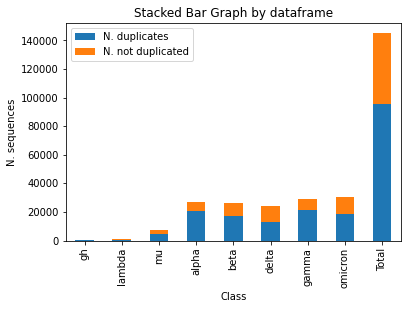

In [23]:
#print dups info
df_dups = pd.read_csv(Path(preprocessed_data_dir) / 'dups_info.txt', delimiter=',', header=0)
df_dups['N. not duplicated'] = df_dups['tot'] - df_dups['dups']
df_dups.rename(columns={'dups': 'N. duplicates', 'class': 'Class'}, inplace=True)
df_dups_plot = df_dups.drop(columns=['percent','tot'])
df_dups_plot.plot(x='Class', kind='bar', stacked=True, title='Stacked Bar Graph by dataframe', ylabel='N. sequences')
plt.show()

In [24]:
# sizes_info[f'test_data_size_seqs'] = sum(1 for line in open(test_file))
# print(sizes_info)
# with open(trainvaltest_sizes_file, 'w') as trainvaltest_sizes_fp:
#     for key in sizes_info.keys():
#         trainvaltest_sizes_fp.write(f"{key},{sizes_info[key]}\n")

# with open(input_seqs_file, 'r') as fp, open(seqs_index_file, 'w') as seqs_index_fp:
#                     seqs_index_csvwriter = csv.writer(seqs_index_fp)
#                     csv_reader = csv.reader(fp, delimiter=',')
#                     for n_line, line in enumerate(csv_reader):
#                         index = [int(line[1]), int(line[0])]
#                         seqs_index_csvwriter.writerow(index)

####Split data in train and test datasets

Split in train and test datasets

In [25]:
def split_train_val_test_seqs(seqs_index):
    """
    Split input data in training, validation and testing datasets according to precomputed splits on ids
    (NB: even if we work with chunks, all chunks of the same sequence are grouped in the same dataset since we split on sequence ids)
    """
    ids = [s[0] for s in seqs_index] # X : [id1,...,idN]
    y = [s[1] for s in seqs_index] # y : [label1,...,labelN]

    # split the sequence ids into training, validation and testing splits
    ids_train_val, ids_test, y_train_val, y_test = train_test_split(ids, y, test_size=0.20, random_state=42, stratify=y, shuffle=True)
    ids_train, ids_val, y_train, y_val = train_test_split(ids_train_val, y_train_val, test_size=0.08, random_state=42, stratify=y_train_val, shuffle=True)

    sizes_info = {}
    sizes_info['train_data_size_seqs'] = len(ids_train)
    sizes_info['val_data_size_seqs'] =len(ids_val)
    sizes_info['test_data_size_seqs'] =len(ids_test)

    # copy train, val, test sequences into separate files
    with open(input_seqs_file, 'r') as in_fp,\
            open(train_file, 'w') as train_fp,\
            open(val_file, 'w') as val_fp,\
            open(test_file, 'w') as test_fp:
        csvreader = csv.reader(in_fp, delimiter=',')
        for line in tqdm(csvreader):
            id = int(line[1])
            if id in ids_train:
                train_fp.write(','.join(line)+'\n')
            elif id in ids_val:
                val_fp.write(','.join(line)+'\n')
            elif id in ids_test:
                test_fp.write(','.join(line)+'\n')
            else:
                print(f"Error: id {id} not found in train, val, test splits")
                exit

    return ids_train, ids_val, ids_test, sizes_info


sizes_info = {}

seqs_index = read_seqs_index(seqs_index_file)

# if training, validation and testing datasets already available continue, else compute splits
if os.path.exists(trainvaltest_splits_dir):
    print(f"Data already split in train-val-test datasets in {trainvaltest_splits_dir} file. See {log_file} for data info.")
    with open(trainvaltest_sizes_file, 'r') as trainvaltest_sizes_fp:
        csvreader = csv.reader(trainvaltest_sizes_fp, delimiter=',')
        for line in tqdm(csvreader):
            sizes_info[line[0]] = int(line[1])
else:
    os.makedirs(trainvaltest_splits_dir)
    print(f"Directory '{trainvaltest_splits_dir}' created")
    ids_train, ids_val, ids_test, sizes_info  = split_train_val_test_seqs(seqs_index)
    with open(trainvaltest_sizes_file, 'w') as trainvaltest_sizes_fp:
        for key in sizes_info.keys():
            trainvaltest_sizes_fp.write(f"{key},{sizes_info[key]}\n")

with open(log_file, 'a') as log_fp:
    print(f"\nTrain (70%): {sizes_info['train_data_size_seqs']} sequences")
    print(f"Val (10%): {sizes_info['val_data_size_seqs']} sequences")
    print(f"Test (20%): {sizes_info['test_data_size_seqs']} sequences")
    log_fp.write(f"\nTrain - val - test split info:\n")
    log_fp.write(f"==============================\n")
    log_fp.write(f"Train (70%): {sizes_info['train_data_size_seqs']} sequences\n")
    log_fp.write(f"Val (10%): {sizes_info['val_data_size_seqs']} sequences\n")
    log_fp.write(f"Test (20%): {sizes_info['test_data_size_seqs']} sequences\n")
    log_fp.write('--------------------------------------------------------------\n')

49403it [00:00, 184129.63it/s]


Data already split in train-val-test datasets in /content/drive/My Drive/tesi/k12_s9/preprocessed_data/trainvaltest_splits file. See /content/drive/My Drive/tesi/k12_s9/outputs/log/log(73).txt for data info.


3it [00:00, 15.31it/s]



Train (70%): 36360 sequences
Val (10%): 3162 sequences
Test (20%): 9881 sequences


### Tokenization and data generation

#### Add most frequent tokens to Bert vocabulary

Create dictionary of token ids and BERT model

In [26]:
def seq2kmer(seq, k, stride, string_format=False):
    """
    Convert original sequence to kmers with stride.
    Pad shorter sequences with 'N'.

    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.

    Returns:
    kmers -- str, kmers separated by space
    """
    list_seq = list(seq)
    not_divisible = (len(list_seq)%k != 0)
    while not_divisible:
        list_seq.append('N')
        not_divisible = (len(list_seq)%k != 0)
    kmers = [list_seq[x:x+k] for x in range(0, len(list_seq)-k+1, stride)]

    if string_format:
        return [''.join(kmer).lower() for kmer in kmers]

    return kmers

In [27]:
# compute the number of occurrencies of each token in the training dataset:
token_count = {}
# if token counts already computed load them from file
if os.path.exists(token_count_file):
    print("Token count file already exists.")
    with open(token_count_file) as token_count_fp:
        csvreader = csv.reader(token_count_fp, delimiter=',')
        for line in tqdm(csvreader):
            token_count[line[0]] = int(line[1])
else:
    with open(train_file) as train_fp, open(token_count_file, 'w') as token_count_fp:
        train_reader = csv.reader(train_fp, delimiter=',')
        # loop on training data
        for line in tqdm(train_reader):
            label = line[0]
            id = line[1]
            pos = line[2]
            seq = line[3]
            # split sequence/chunk in kmers
            tokens = seq2kmer(seq, config_dict['K'], config_dict['STRIDE'], string_format=True)
            # update token count
            for count,tok in enumerate(tokens):
                # if count > config_dict['MAX_LENGTH']-2: #consider only tokens <MAX_LENGTH
                #     break
                if tok in token_count:
                    token_count[tok] += 1
                else:
                    token_count[tok] = 1
        # save token count on file
        csvwriter = csv.writer(token_count_fp, delimiter=',')
        for key, value in token_count.items():
            csvwriter.writerow([key, value])

Token count file already exists.


33289it [00:00, 119366.19it/s]


Plot histogram of k-mer token occurrencies

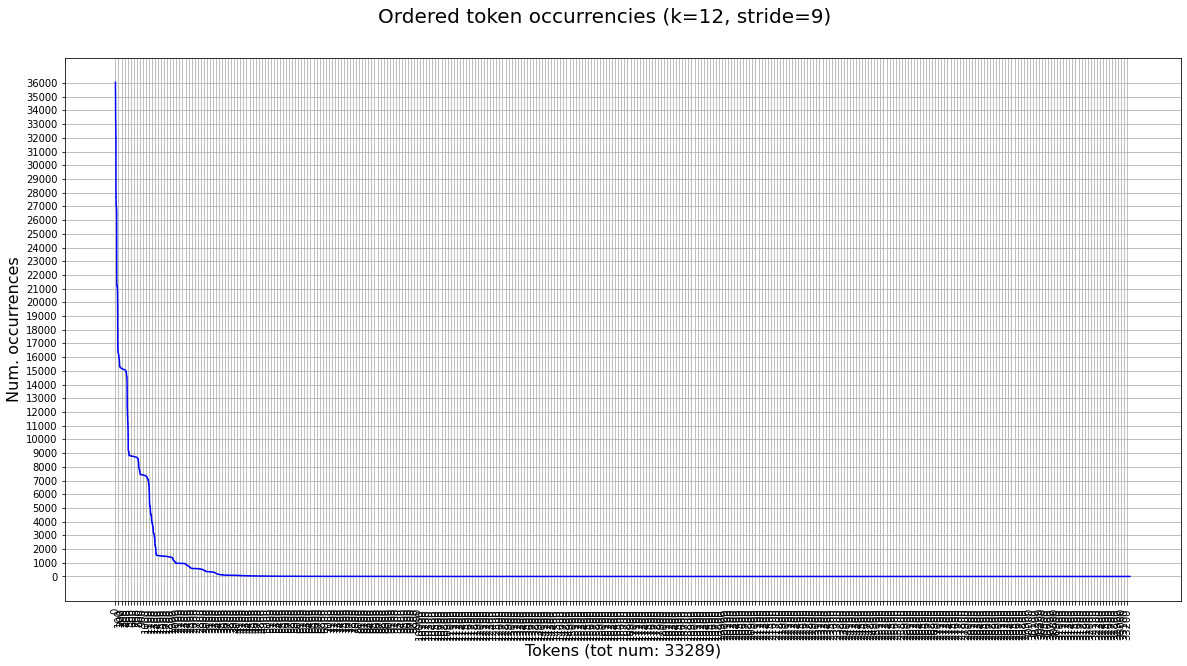

In [28]:
# plot sorted token count histogram to find elbow, i.e. number of tokens which contribute to most of token occurrences
token_count_ordered = {k: v for k, v in sorted(token_count.items(), key=lambda item: item[1], reverse=True)}
fig = plt.figure(figsize=(20,10))
plt.step(range(len(token_count_ordered.keys())), list(token_count_ordered.values()),color='b')
fig.suptitle(f"Ordered token occurrencies (k={config_dict['K']}, stride={config_dict['STRIDE']})", y=0.95, fontsize=20)
plt.xlabel(f'Tokens (tot num: {len(token_count_ordered)})', fontsize=16)
plt.xticks(np.arange(0, len(token_count_ordered), 100), rotation=90)
plt.ylabel('Num. occurrences', fontsize=16)
plt.yticks(np.arange(0, max(list(token_count_ordered.values())), 1000))
fig_path = Path(tokens_histograms_dir) / f"k{config_dict['K']}_s{config_dict['STRIDE']}.jpg"
fig.savefig(fig_path)
plt.grid()
plt.show()

In [29]:
# select minimum n. occurrences at elbow to determine which are the most frequent tokens
print(f"Min. n. occurrencies for kmers to be added as tokens to BERT vocabulary:")
config_dict['MIN_N_OCCUR_KMER'] = 0

with open(log_file, 'a') as log_fp:
    print(f"MIN_N_OCCUR_KMER = {config_dict['MIN_N_OCCUR_KMER']}")
    log_fp.write(f"Min. n. occurrencies for kmers to be added as tokens to BERT vocabulary:\n")
    log_fp.write(f"========================================================================\n")
    log_fp.write(f"MIN_N_OCCUR_KMER = {config_dict['MIN_N_OCCUR_KMER']}\n")

Min. n. occurrencies for kmers to be added as tokens to BERT vocabulary:
MIN_N_OCCUR_KMER = 0


Add most frequent kmer tokens to BERT vocabulary

In [30]:
if config_dict['ADD_KMER_TOKENS_TO_VOCAB']:
    # extract most frequent tokens based on min n. of occurrences
    frequent_tokens_in_train_data = [k for k,v in token_count.items() if v>config_dict['MIN_N_OCCUR_KMER']]
    print(f"Num. frequent (>{config_dict['MIN_N_OCCUR_KMER']} occurrences) tokens in train dataset: {len(frequent_tokens_in_train_data)}")

    # add most frequent tokens to BERT vocabulary
    print('Adding most frequent new tokens to Bert tokenizer...')
    num_added_toks = tokenizer.add_tokens(frequent_tokens_in_train_data)
    print(f'Num. of new tokens added: {num_added_toks}')
    with open(log_file, 'a') as log_fp:
        log_fp.write(f"Num. of new frequent tokens added to BERT vocabulary: {num_added_toks}\n")
        log_fp.write('--------------------------------------------------------------\n')

    # resize BERT token embeddings
    print('Resizing token embeddings of AutoModelForSequenceClassification...')
    model.resize_token_embeddings(len(tokenizer))
    print('Done')

Num. frequent (>0 occurrences) tokens in train dataset: 33289
Adding most frequent new tokens to Bert tokenizer...
Num. of new tokens added: 33289
Resizing token embeddings of AutoModelForSequenceClassification...
Done


In [31]:
tokenizer.save_pretrained(tokenizer_file)

('/content/drive/My Drive/tesi/k12_s9/outputs/tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/tesi/k12_s9/outputs/tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/tesi/k12_s9/outputs/tokenizer/vocab.txt',
 '/content/drive/My Drive/tesi/k12_s9/outputs/tokenizer/added_tokens.json')

In [32]:
# Tell pytorch to run this model on the GPU.
if do_training:
    model.cuda()

Encoder for tokenized data

In [33]:
def token_encode(seq):
    encoded_seq = {}

    #   (1) Tokenize the sentence.
    seq_tokens = seq2kmer(seq, config_dict['K'], config_dict['STRIDE'])

    #   (4) Map tokens to their IDs.
    seq_input_ids = []
    for token in seq_tokens:
        token_str = ''.join(token).lower()
        seq_input_ids.append(tokenizer.convert_tokens_to_ids(token_str))
        # print(f'{token_str} || {tokenizer.convert_tokens_to_ids(token_str)}')
    # print(seq_input_ids)

    #   (5) Truncate the sentence to `MAX_LENGTH`
    #       NB: -2 because we must consider also [CLS] and [SEP] tokens
    if len(seq_tokens) > config_dict['MAX_LENGTH']-2:
        seq_input_ids = seq_input_ids[:config_dict['MAX_LENGTH']-2]

    #   (2) Prepend the `[CLS]` token to the start.
    seq_input_ids.insert(0, tokenizer.convert_tokens_to_ids('[CLS]'))

    #   (3) Append the `[SEP]` token to the end.
    seq_input_ids.append(tokenizer.convert_tokens_to_ids('[SEP]'))

    #   Pad if sentence is too short
    if len(seq_tokens) < config_dict['MAX_LENGTH']:
        length_seq = len(seq_input_ids)
        seq_input_ids.extend([tokenizer.convert_tokens_to_ids('[PAD]')]*(config_dict['MAX_LENGTH'] - length_seq))
    # print(seq_tokens)
    # print(seq_input_ids)


    #   (6) Create attention masks for [PAD] tokens.
    seq_attention_mask = [int(id!=tokenizer.convert_tokens_to_ids('[PAD]')) for id in seq_input_ids] #map(lambda x: 0 if x==token_ids_dict['[PAD]'] else 1, seq_input_ids)
    # print(seq_attention_mask)
    # print()


    encoded_seq['input_ids'] = seq_input_ids
    encoded_seq['attention_mask'] = seq_attention_mask

    return encoded_seq


####Data generator from file

In [34]:
class DatasetGenerator(Dataset):

    def __init__(self, input_reader, input_fp, metadata):
        self.input_reader = input_reader
        self.metadata = metadata
        self.input_fp = input_fp

    def __len__(self):
        return self.metadata['len']

    def __getitem__(self, idx):  #iterate lazily
        line = getline(self.input_fp.name, idx+1 ).split(',') #idx+1 because getline considers 1 as index of first line in file, while idx starts from 0
        #line = next(itertools.islice(self.input_fp, idx, idx+1)).split(',')
        #print(line[:20])
        try:
            label = float(line[0])
        except Exception as e:
            print(f'line error: {line}')
            exit()
        seq_id = int(line[1])
        pos = int(line[2])
        seq = line[3]

        # Tokenize sequence and map the tokens to thier word IDs.
        example = InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                text_a = seq, 
                                text_b = None,
                                label = label)
        
        encoded_seq = token_encode(example.text_a)
        
        features = InputFeatures(input_ids=encoded_seq['input_ids'], 
                                    attention_mask=encoded_seq['attention_mask'],
                                    label=example.label)
        ids = features.input_ids
        mask = features.attention_mask

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(features.label, dtype=torch.float),
            'seq_ids': torch.tensor(seq_id, dtype=torch.int),
            'positions': torch.tensor(pos, dtype=torch.int)
        }

class DatasetGenerator_InputEmbeddings(Dataset):

    def __init__(self, input_fp, metadata):
        self.metadata = metadata
        self.input_fp = input_fp
        self.selected_variant = config_dict['POSITIVE_CLASS_MLP']

    def __len__(self):
        return self.metadata['len']

    def __getitem__(self, idx):  #iterate lazily
        line = getline(self.input_fp.name, idx+1 ).split(',') #idx+1 because getline considers 1 as index of first line in file, while idx starts from 0
        #line = next(itertools.islice(self.input_fp, idx, idx+1)).split(',')
        #print(line[:20])
        label_tmp = float(line[0])
        if label_tmp == config_dict['CLASS_LABELS'][self.selected_variant]:
            label = float(1)
        else:
            label = float(0)
        seq_id = int(line[1])
        pos = int(line[2])
        seq = line[3]

        # Tokenize sequence and map the tokens to thier word IDs.
        example = InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                text_a = seq, 
                                text_b = None,
                                label = label)
        
        encoded_seq = token_encode(example.text_a)
        
        features = InputFeatures(input_ids=encoded_seq['input_ids'], 
                                    attention_mask=encoded_seq['attention_mask'],
                                    label=example.label)
        ids = features.input_ids
        mask = features.attention_mask

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(features.label, dtype=torch.float),
            'seq_ids': torch.tensor(seq_id, dtype=torch.int),
            'positions': torch.tensor(pos, dtype=torch.int)
        }
    

### Supervised: BERT classifier


####Training functions (fonti: [esempio1](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb), [esempio2](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=6O_NbXFGMukX))

In [35]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def setup_training(train_data_size, log_fp):
    # Set up epochs and steps
    steps_per_epoch = int(train_data_size / config_dict['TRAIN_BATCH_SIZE'])
    num_train_steps = steps_per_epoch * config_dict['EPOCHS']
    warmup_steps = int(config_dict['EPOCHS'] * train_data_size * 0.1 / config_dict['TRAIN_BATCH_SIZE'])

    # creates an optimizer and learning rate scheduler
    optimizer = torch.optim.AdamW(model.parameters(),
                  lr = config_dict['LR'], # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = num_train_steps)
    # optimizer = nlp.optimization.create_optimizer(
    #     2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    log_fp.write("\nTraining setup:\n")
    log_fp.write("===============\n")
    log_fp.write(f"\tsteps_per_epoch = {steps_per_epoch}\n")
    log_fp.write(f"\tnum_train_steps = {num_train_steps}\n")
    log_fp.write(f"\twarmup_steps = {warmup_steps}\n")
    log_fp.write(f"\toptimizer = {optimizer}\n")
    log_fp.write(f"\tscheduler = {scheduler}\n")
    log_fp.write(f"\tseed_val = {seed_val}\n")
    
    return optimizer, scheduler

def loss_fn(outputs, targets):
    if config_dict['N_CLASSES'] > 2:
        criterion = torch.nn.CrossEntropyLoss()
        return criterion(outputs.logits, targets.to(torch.long))
    else:
        return outputs.loss

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Training and validation functions

In [36]:
def train(train_dataloader, optimizer, scheduler, log_fp):
    # Perform one full pass over the training set.

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    train_steps_loss = []

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(train_dataloader, 0):
        
        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.float)
        seq_ids = batch['seq_ids'].to(device, dtype = torch.int)
        y_onehot = torch.nn.functional.one_hot(targets.long(), num_classes=config_dict['N_CLASSES'])
        y_onehot = y_onehot.float()
            

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad() 

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        outputs = model(ids, 
                       token_type_ids=None, 
                       attention_mask=mask, 
                       labels=y_onehot,
                       return_dict=True)

        loss = loss_fn(outputs, targets)

        # Save hidden states of last layer for clustering
        # hidden_states = Tuple of torch.FloatTensor (one for the output of the embeddings
        # + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
        # last_hidden_states = outputs.hidden_states[12]
        
        # Progress update every 40 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5}  of  {:>5}.    Elapsed: {:}.     Loss:  {:}.'.format(step, len(train_dataloader), elapsed, loss.item()))
            log_fp.write(('  Batch {:>5}  of  {:>5}.    Elapsed: {:}.     Loss:  {:}.\n'.format(step, len(train_dataloader), elapsed, loss.item())))
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += float(loss.item())
        if step % 50 == 0 and not step == 0:
            train_steps_loss.append(float(loss.item()))
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    log_fp.write("  Average training loss: {0:.2f}\n".format(avg_train_loss))
    log_fp.write("  Training epoch took: {:}\n".format(training_time))

    return avg_train_loss, training_time, train_steps_loss


def validation(val_dataloader, log_fp):
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    final_data = {'seq_ids' : [],
                  'positions' : [],
                  'targets' : [],
                  'outputs' : [],
                  'last_hidden_states_dict' : {}
                  }

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.float)
        seq_ids = batch['seq_ids'].to('cpu').numpy()
        positions = batch['positions'].to('cpu').numpy()

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            y_onehot = torch.nn.functional.one_hot(targets.long(), num_classes=config_dict['N_CLASSES'])
            y_onehot = y_onehot.float()
            outputs = model(ids,  
                            attention_mask=mask,
                            labels=y_onehot,
                            return_dict=True)
            
        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = loss_fn(outputs, targets)
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += float(loss.item())

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = targets.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        final_data['targets'].extend(y_onehot.cpu().detach().numpy().tolist())
        if config_dict['N_CLASSES'] > 2:
            final_data['outputs'].extend(torch.softmax(outputs.logits, dim=1).cpu().detach().numpy().tolist())
        else:
            final_data['outputs'].extend(torch.sigmoid(outputs.logits).cpu().detach().numpy().tolist())
        final_data['seq_ids'].extend(seq_ids)
        final_data['positions'].extend(positions)

        # Save hidden states of last layer for clustering
        # hidden_states = Tuple of torch.FloatTensor (one for the output of the embeddings
        # + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
        last_hidden_states = outputs.hidden_states[12].cpu().detach().numpy()
        for i, seq_id in enumerate(seq_ids):
            final_data['last_hidden_states_dict']['seq_id'] = last_hidden_states[i]


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    log_fp.write("  Validation Accuracy: {0:.2f}\n".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    log_fp.write("  Validation Loss: {0:.2f}\n".format(avg_val_loss))
    log_fp.write("  Validation took: {:}\n".format(validation_time))

    return final_data, avg_val_loss, avg_val_accuracy, validation_time


def supervisedBertClassifierFinetune(train_dataloader, val_dataloader, train_data_size, log_fp):
    gc.collect()
    torch.cuda.empty_cache()
    optimizer, scheduler = setup_training(train_data_size, log_fp)

    training_stats = []
    train_steps_loss = []
    total_t0 = time.time()
    log_fp.write("\nTraining and validation:\n")
    log_fp.write("==========================\n")

    for epoch in range(config_dict['EPOCHS']):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, config_dict['EPOCHS']))
        print('Training...')
        log_fp.write('\n======== Epoch {:} / {:} ========\n'.format(epoch + 1, config_dict['EPOCHS']))
        log_fp.write("\nTraining:\n")
        avg_train_loss, training_time, train_steps_loss_epoch = train(train_dataloader, optimizer, scheduler, log_fp)
        train_steps_loss.extend(train_steps_loss_epoch)

        print("")
        print("Validation...")
        log_fp.write("\nValidation:\n")
        final_data, avg_val_loss, avg_val_accuracy, validation_time = validation(val_dataloader, log_fp)

        training_stats_epoch = {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'final_data':final_data
        }
        training_stats.append(training_stats_epoch)


    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    log_fp.write("Total training took {:} (h:mm:ss)\n".format(format_time(time.time()-total_t0)))

    # return train hidden_states from last epoch
    return training_stats, train_steps_loss

#### Finetuning



In [37]:
if do_training and do_finetuning:
    with open(train_file) as train_fp, open(val_file) as val_fp, open(log_file, 'a') as log_fp:

        train_reader = csv.reader(train_fp, delimiter=',')
        train_metadata = {'len':sizes_info['train_data_size_seqs']}
        X_train_generator = DatasetGenerator(train_reader, train_fp, train_metadata) 
        train_dataloader = DataLoader(
                X_train_generator,  # The training samples.
                sampler = RandomSampler(X_train_generator), # Select batches randomly
                batch_size = config_dict['TRAIN_BATCH_SIZE'], # Trains with this batch size.
                num_workers = 0
        )
        
        val_reader = csv.reader(val_fp, delimiter=',')
        val_metadata = {'len':sizes_info['val_data_size_seqs']}
        X_val_generator = DatasetGenerator(val_reader, val_fp, val_metadata) #.batch(EVAL_BATCH_SIZE)

        
        validation_dataloader = DataLoader(
                X_val_generator, # The validation samples.
                sampler = SequentialSampler(X_val_generator), # Pull out batches sequentially.
                batch_size = config_dict['EVAL_BATCH_SIZE'], # Evaluate with this batch size.
                num_workers = 0
        )

        training_stats, train_steps_loss = supervisedBertClassifierFinetune(train_dataloader, validation_dataloader, sizes_info['train_data_size_seqs'], log_fp)

#### Save model and outputs

In [38]:
# save or load model for inference:
if do_training or do_test or config_dict['TASK_TYPE']=='one_vs_all_classification':
    if do_finetuning:
        mod_f = model_file_finetuned
    else:
        mod_f = model_file
    if os.path.exists(mod_f):
        # model.load_state_dict(torch.load(mod_f, map_location=torch.device('cpu')))
        # device = torch.device("cpu")
        model.load_state_dict(torch.load(mod_f))
    else:
        torch.save(model.state_dict(), mod_f)

if do_test or config_dict['TASK_TYPE']=='one_vs_all_classification':
    model.cuda()

In [39]:
# save or load last epoch validation data:
if os.path.exists(final_val_outputs_file):
    final_data = pickle.load(open(final_val_outputs_file, 'rb'))
else:         
    final_data = training_stats[-1]['final_data']
    # save output data on file for furure computation:
    pickle.dump(final_data, open(final_val_outputs_file, 'wb'))
    # pickle.dump(str(final_data), open(final_val_outputs_file, 'wb'))


# save or load last epoch validation data:
if os.path.exists(training_stats_file):
    training_stats = pickle.load(open(training_stats_file, 'rb'))
else:         
    # save output data on file for furure computation:
    pickle.dump(training_stats, open(training_stats_file, 'wb'))
    # pickle.dump(str(final_data), open(final_val_outputs_file, 'wb'))

#### Validation statistics

Cluster last hidden states

In [40]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt # graphs plotting
# import matplotlib.cm as cm
# import seaborn as sns

# print("Starting t-SNE")

# X_embedded = TSNE(n_components = 2, perplexity = 30, random_state = 1).fit_transform()

# print("Writting File!!!")

# write_path_11 = "/alina-data1/sarwan/IEEE_BigData/Dataset/t_sne_plot_2_dim.csv"

Statistics and plots functions

In [41]:
from pandas._config import config
def show_train_stats_and_plots(training_stats, train_steps_loss):
    print('Results:')
    # Display floats with two decimal places.
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    print(df_stats)

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    fig = plt.figure(1, figsize=(12,6))
    #plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Average Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])

    plt.show() 
    fig_path = Path(outputs_dir) / 'trainval.jpg'
    fig.savefig(fig_path)  

    fig2 = plt.figure(2, figsize=(30,6))
    plt.plot(train_steps_loss, 'b', label="Training steps loss (every 40 steps)")

    # Label the plot.
    plt.title("Training steps loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()

    plt.show() 
    fig_path2 = Path(outputs_dir) / 'train_steps.jpg'
    fig2.savefig(fig_path2)  


def confusion_matrix_plot(targets_labels, outputs_labels, path, taskname = ""):
    confusion_matr = metrics.confusion_matrix(targets_labels, outputs_labels)
    plt.figure()
    plt.figure(figsize=(15, 15))
    sns.heatmap(confusion_matr, annot=True, fmt="d", cmap="viridis", annot_kws={"fontsize":20})
    plt.title(f'{taskname} Confusion Matrix', fontsize=25)
    plt.ylabel('True label', fontsize=21)
    plt.xlabel('Predicted label', fontsize=21)
    curr_xticks, curr_xlabels = plt.xticks()
    plt.xticks(curr_xticks, labels=[inv_class_labels_dict[int(t.get_text())] for t in curr_xlabels], rotation=90, fontsize=20)
    curr_yticks, curr_ylabels = plt.yticks()
    plt.yticks(curr_yticks, labels=[inv_class_labels_dict[int(t.get_text())] for t in curr_ylabels], rotation=0, fontsize=20)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=20)
    fig_path = Path(path) / f"{taskname.replace(' ', '_')}_confusion_matrix.jpg"
    fig = plt.gcf()
    fig.savefig(fig_path)
    plt.show()
    plt.figure()


def plot_PRC(y, y_score, y_pred, path):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend(loc='lower right')
    ax.set_title(f"Precision-Recall Curves")
    # metrics.PrecisionRecallDisplay.from_predictions(y, y_score, ax=ax, )
    # precision = dict()
    # recall = dict()
    # average_precision = dict()
    # for i in range(config_dict['N_CLASSES']):
    #     precision[i], recall[i], _ = metrics.precision_recall_curve(y[:],
    #                                                         y_score[:, i])
    #     average_precision[i] = metrics.average_precision_score(y[:], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    # precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y,
    #     y_score)
    # average_precision["micro"] = metrics.average_precision_score(y, y_score,
    #                                                     average="micro")
    # print('Average precision score, micro-averaged over all classes: {0:0.2f}'
    #     .format(average_precision["micro"]))
    # display = metrics.PrecisionRecallDisplay(
    #     recall=recall["micro"],
    #     precision=precision["micro"],
    #     average_precision=average_precision["micro"])
    # display.plot()
    # _ = display.ax_.set_title(f"Precision-Recall curve micro-averaged over all classes (AP={average_precision['micro']})")
    def multiclass_prc(y_test, y_score, y_pred, average="micro"):
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        y_pred = lb.transform(y_pred)

        for (idx, c_label) in enumerate(config_dict['CLASS_LABELS'].keys()):
            display = metrics.PrecisionRecallDisplay.from_predictions(y_test[:,idx].astype(int), y_pred[:,idx], name=c_label)
            display.plot(ax=ax)
        # ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
        return metrics.average_precision_score(y_test, y_pred, average=average)
    print('AP score:', multiclass_prc(y, y_score, y_pred))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    # fig.show()
    fig.savefig(Path(path) / 'prc.png')

def ROC_curve_plot(targets_labels, outputs_labels, path, taskname = "", figsize=(17, 6)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    labels_dict = {class_label:[[],[]] for class_label in config_dict['CLASS_LABELS'].values()}
    for i in range(len(targets_labels)):
        labels_dict[targets_labels[i]][0].append(targets_labels[i])
        labels_dict[targets_labels[i]][1].append(outputs_labels[i])

    for class_label, tgt_out_labels in labels_dict.items():
        print("CLASSSSS")
        print(class_label)
        print(tgt_out_labels[0])
        print(tgt_out_labels[1])
        fpr[class_label], tpr[class_label], _ = metrics.roc_curve(tgt_out_labels[0], tgt_out_labels[1], pos_label=class_label)
        roc_auc[class_label] = metrics.auc(fpr[class_label], tpr[class_label])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for class_label in labels_dict.keys():
        ax.plot(fpr[class_label], tpr[class_label], label='ROC curve (AUC = %0.2f) for class %i' % (roc_auc[class_label], class_label))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

def final_statistics(target_labels, output_labels, output_logits, log_file, taskname, logits=None, target_names=None):
    accuracy = metrics.accuracy_score(target_labels, output_labels)
    f1_score_micro = metrics.f1_score(target_labels, output_labels, average='micro')
    f1_score_macro = metrics.f1_score(target_labels, output_labels, average='macro')
    if target_names==None:
        target_names = config_dict['CLASS_LABELS']
    specificity = {}
    for l_name, l in target_names.items():
        prec,recall,_,_ = metrics.precision_recall_fscore_support(target_labels==l,
                                                        output_labels==l,
                                                        pos_label=True,average=None)
        specificity[l_name] = recall[0] 
    classification_report = metrics.classification_report(target_labels, output_labels, target_names=target_names.keys())
    confusion_matr = metrics.confusion_matrix(target_labels, output_labels)
    print(f'{taskname}:')
    print(f"===============================")
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(f"Specificity:\n{json.dumps(specificity, indent=4)}\n")
    print(f"Classification report:\n{str(classification_report)}")
    confusion_matrix_plot(target_labels, output_labels, outputs_dir, taskname)
    # plot_PRC(target_labels, output_logits, output_labels, outputs_dir)
    with open(log_file, 'a') as log_fp:
        log_fp.write(f"\n{taskname}:\n")
        log_fp.write(f"===============================\n")
        log_fp.write(f"Accuracy Score = {accuracy}\n")
        log_fp.write(f"F1 Score (Micro) = {f1_score_micro}\n")
        log_fp.write(f"F1 Score (Macro) = {f1_score_macro}\n")
        log_fp.write(f"Classification report:\n{classification_report}\n")
        log_fp.write(f"Specificity:\n{json.dumps(specificity, indent=4)}\n")
        log_fp.write(f"Confusion matrix:\n{confusion_matr}\n")
    if logits:
        logits_pos_score = [x[target_labels[i]] for i,x in enumerate(logits)]
        ROC_curve_plot(target_labels, logits_pos_score, outputs_dir, taskname)

def find_best_positions(final_data, min_score=0.8, threshold=0.5):
    best_positions = None

    outputs_labels=np.argmax(final_data['outputs'],axis=1)
    targets_labels=np.argmax(final_data['targets'],axis=1)

    # analisys according to position in sequence
    final_data['select_pred'] = []
    final_data['count_pred'] = []
    for target,pred,pred_score in zip(targets_labels,outputs_labels, final_data['outputs']):
        # select only predictions which are correct and with score > min_score (*)
        final_data['select_pred'].append(int(target == pred and pred_score[np.argmax(pred_score)]>min_score)) 
        final_data['count_pred'].append(1)
    final_data_df = pd.DataFrame(final_data).drop(columns=['outputs', 'targets','seq_ids'])
    grouped_df = final_data_df.groupby(['positions']).agg({'select_pred': 'sum', 'count_pred': 'count'})

    # for each position, calculate percentage of chunks which satisfy conditions (see (*))
    grouped_df['percents'] = grouped_df['select_pred'] / grouped_df['count_pred']
    # select only positions which have a percentage of chunks which satisfy conditions (see (*)) > threshold
    best_positions = [i for i, perc in enumerate(np.asarray(grouped_df['percents'])) if perc > threshold]

    print(f"Best positions: {best_positions}")
    with open(log_file, 'a') as log_fp:
        log_fp.write(f"\nBest positions (i.e. those with >{threshold*100}% of chunks with correct prediction and score>{min_score}):\n")
        log_fp.write(f"=======================================================================================\n")
        log_fp.write(f"{best_positions}\n")

    plot = grouped_df['percents'].plot.bar(figsize=(20,10))
    fig = plot.get_figure()
    fig.suptitle(f"For each position, percentage of chunks with correct prediction and score>{min_score}", y=0.95, fontsize=20)
    plt.yticks(np.arange(0, 1, 0.1))
    plt.grid()
    plt.axhline(y=threshold, color='r', linestyle='-')
    fig_path = Path(outputs_dir) / f"percent_pos.jpg"
    fig.savefig(fig_path)
    plt.show()

    return best_positions

def per_sample_result_computation(final_data, best_positions, min_score=0.8, taskname='', filter_positions=True, filter_score=True):
    targets_dict = {}
    preds_dict = {}
    for id,target in zip(final_data['seq_ids'],final_data['targets']):
        if id not in targets_dict:
            targets_dict[id] = np.argmax(target)
        if id not in preds_dict:
            preds_dict[id] = {'counts':[], 'outputs_label':[], 'prediction': []}


    final_data['select_pred'] = []
    final_data['outputs_label'] = []
    for pos,pred in zip(final_data['positions'],final_data['outputs']):
        # select prediction only if it is in best position and if prediction is certain (score>min_score) (*)
        if filter_positions:
            if filter_score: 
                final_data['select_pred'].append(int(pos in best_positions and pred[np.argmax(pred)]>min_score))
            else:
                final_data['select_pred'].append(int(pos in best_positions))
        else:
            if filter_score: 
                final_data['select_pred'].append(int(pred[np.argmax(pred)]>min_score))
            else:
                final_data['select_pred'].append(int(pred[np.argmax(pred)]>0))
        final_data['outputs_label'].append(np.argmax(pred))
    
    final_data_df = pd.DataFrame(final_data)
    # filter only selected predictions according to conditions (see (*))
    filtered_data_df = final_data_df[final_data_df['select_pred'] > 0]
    filtered_data_df = filtered_data_df[['seq_ids','outputs_label']]
    grouped_sample_data_df = pd.DataFrame(filtered_data_df).groupby(['seq_ids','outputs_label']).size().reset_index(name='counts')
    grouped_sample_data_dict = grouped_sample_data_df.to_dict('list')

    for seq_id,output_l,count in zip(grouped_sample_data_dict['seq_ids'], grouped_sample_data_dict['outputs_label'], grouped_sample_data_dict['counts']):
        preds_dict[seq_id]['outputs_label'].append(output_l)
        preds_dict[seq_id]['counts'].append(count)

     
    for seq_id in preds_dict.keys():
        counts_sorted = preds_dict[seq_id]['counts'].copy()
        counts_sorted.sort(reverse=True)
        if len(preds_dict[seq_id]['counts'])==0 or (len(counts_sorted)>1 and all(element == counts_sorted[0] for element in counts_sorted)):
            preds_dict[seq_id]['prediction'] = 'uncertain'
        else:
            majority_class_index = np.argmax(preds_dict[seq_id]['counts'])
            preds_dict[seq_id]['prediction'] = preds_dict[seq_id]['outputs_label'][majority_class_index]

    correct_pred_count = 0
    uncertain_pred_count = 0
    tot_count = 0
    target_labels = []
    output_labels = []


    with open(log_file, 'a') as log_fp:
        for seq_id in targets_dict.keys():
            tot_count += 1
            if preds_dict[seq_id]['prediction'] == 'uncertain':
                uncertain_pred_count += 1
            else:
                target_labels.append(targets_dict[seq_id])
                output_labels.append(preds_dict[seq_id]['prediction'])
                if targets_dict[seq_id] == preds_dict[seq_id]['prediction']:
                    correct_pred_count += 1
            print(f"seq: {seq_id}\t target: {targets_dict[seq_id]}\t predicted: {preds_dict[seq_id]['prediction']}")
            log_fp.write(f"seq: {seq_id}\t target: {targets_dict[seq_id]}\t predicted: {preds_dict[seq_id]['prediction']}\n")

    final_statistics(target_labels, output_labels, log_file, f"{taskname} grouped by samples, filter_positions={filter_positions}, filter_score={filter_score}, min_score={min_score}")
    
    print(f"Correct predictions: {correct_pred_count}/{tot_count} -> {correct_pred_count/tot_count}")
    print(f"Wrong predictions: {tot_count-correct_pred_count-uncertain_pred_count}/{tot_count} -> {(tot_count-correct_pred_count-uncertain_pred_count)/tot_count}")
    print(f"Uncertain predictions: {uncertain_pred_count}/{tot_count} -> {uncertain_pred_count/tot_count}")

    with open(log_file, 'a') as log_fp:
        log_fp.write(f"Correct predictions: {correct_pred_count}/{tot_count} -> {correct_pred_count/tot_count}\n")
        log_fp.write(f"Wrong predictions: {tot_count-correct_pred_count-uncertain_pred_count}/{tot_count} -> {(tot_count-correct_pred_count-uncertain_pred_count)/tot_count}\n")
        log_fp.write(f"Uncertain predictions: {uncertain_pred_count}/{tot_count} -> {uncertain_pred_count/tot_count}\n")



In [42]:
if do_training:
    show_train_stats_and_plots(training_stats, train_steps_loss)

    output_labels=np.argmax(final_data['outputs'],axis=1)
    target_labels=np.argmax(final_data['targets'],axis=1)
    final_statistics(target_labels, output_labels, final_data['outputs'], log_file, 'Global Validation')

    if config_dict['SPLIT_DATA_IN_CHUNKS']:
        #best_positions = find_best_positions(final_data, min_score=0.8, threshold=0.75)
        #per_sample_result_computation(final_data, best_positions, taskname="Validation")
        per_sample_result_computation(final_data, best_positions, taskname="Validation", filter_positions=True, filter_score=True, min_score=0.8)

In [43]:
# show_train_stats_and_plots(training_stats, train_steps_loss)

# output_labels=np.argmax(final_data['outputs'],axis=1)
# target_labels=np.argmax(final_data['targets'],axis=1)
# output_logits = final_data['outputs']
# final_statistics(target_labels, output_labels, output_logits, log_file, 'Validation')

####Attention matrices functions

In [44]:
def get_attentions(attentions, sample_idx_in_batch, layer=0, attention_head=0, sum=False):
  '''
  get the particular output for a particular layer and attention head
  layer -> 0 to 11
  attention_head -> 0 to 11
  '''
  if sum:
    #avg over all attention heads in a layer
    return attentions[layer][sample_idx_in_batch].sum(dim=0).cpu().detach().numpy()

  #return values for a particular attention head inside a specific layer
  return attentions[layer][sample_idx_in_batch][attention_head].cpu().detach().numpy()


def min_max_scale(X, range=(0, 1)):
    mi, ma = range
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (ma - mi) + mi
    return X_scaled


def calculate_weight_domain_proportion_by_head(attentions_sum, domain, proportion, theta=0):
    if domain not in domain_coordinates_1based:
        raise ValueError("plt_attentions_domain: domain must be one of %r." % domain_coordinates_1based)

    domain_start_idx, domain_end_idx = convert_domain_coords_in_token_indices(domain)

    # proportion of attention weights in the selected domain from each head that connects all amino acids to those in the selected domain
    #weight_total_by_head = torch.zeros((n_layers, n_heads), dtype=torch.double)
    if proportion == "attention":
        # Update total attention_analysis weights per head. Sum over from_index (dim 2), to_index (dim 3)
        weight_total_by_head = attentions_sum.sum((2, 3))
        # Update weighted sum of feature values per head
        weight_domain_sum_by_head = attentions_sum[:, :, :, domain_start_idx:domain_end_idx+1].sum((2, 3))
    elif proportion == "high-confidence-attention":
        attentions_sum_total_masked = ma.masked_where(attentions_sum <= theta, attentions_sum)
        ma.set_fill_value(attentions_sum_total_masked, 0)
        weight_total_by_head = attentions_sum_total_masked.sum((2, 3))
        attentions_sum_domain = attentions_sum[:, :, :, domain_start_idx:domain_end_idx+1]
        attentions_sum_domain_masked = ma.masked_where(attentions_sum_domain <= theta, attentions_sum_domain)
        ma.set_fill_value(attentions_sum_domain_masked, 0)
        weight_domain_sum_by_head = attentions_sum_domain_masked.sum((2, 3))
    elif proportion == "high-attention-tokens-count":
        mask_high_attn_total = attentions_sum > theta
        weight_total_by_head = mask_high_attn_total.long().sum((2, 3))
        mask_high_attn_domain = attentions_sum[:, :, :, domain_start_idx:domain_end_idx+1] > theta
        weight_domain_sum_by_head = mask_high_attn_domain.long().sum((2, 3))
    else:
        raise ValueError("plt_attentions_domain: proportion must be one of %r." % ["attention", "high-attention-tokens"])

    return weight_domain_sum_by_head / weight_total_by_head, weight_domain_sum_by_head, weight_total_by_head


def plt_attentions_domain(attentions_sum, domain, dir_path, filename, proportion, theta=0, min_total=0, fig_size=(130,100), title=None):
    if domain not in domain_coordinates_1based:
        raise ValueError("plt_attentions_domain: domain must be one of %r." % domain_coordinates_1based)

    weight_domain_proportion_by_head, weight_sum, weight_total = calculate_weight_domain_proportion_by_head(attentions_sum, domain, proportion, theta=theta)

    exclude_mask = np.array(weight_total) < min_total
    masked_weight_domain_proportion = np.ma.masked_array(weight_domain_proportion_by_head, mask=exclude_mask)
    layer_max = np.asarray(masked_weight_domain_proportion).max(-1)

    fig = plt.figure(figsize=(5, 3.5)) #plt.figure(figsize=(3, 2.2))
    fig.suptitle(title, fontsize=13, fontweight='bold')
    ax1 = plt.subplot2grid((100, 85), (0, 0), colspan=65, rowspan=99)  # Heatmap
    ax2 = plt.subplot2grid((100, 85), (12, 70), colspan=15, rowspan=75)  # Barchart

    xtick_labels = [str(i) if i % 2 == 0 else '' for i in range(1, n_heads + 1)]
    ytick_labels = [str(i) if i % 2 == 0 else '' for i in range(1, n_layers + 1)]
    heatmap = sns.heatmap((masked_weight_domain_proportion * 100).tolist(), center=0.0, ax=ax1,
                          square=True, cbar=False, linewidth=0.1, linecolor='#D0D0D0',
                          cmap=LinearSegmentedColormap.from_list('rg', ["#F14100", "white", "#5a3dc4"], N=256),
                          mask=exclude_mask,
                          xticklabels=xtick_labels,
                          yticklabels=ytick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
        spine.set_edgecolor('#D0D0D0')
        spine.set_linewidth(0.1)
    plt.setp(heatmap.get_yticklabels(), fontsize=11)
    plt.setp(heatmap.get_xticklabels(), fontsize=11)
    heatmap.tick_params(axis='x', pad=1, length=2)
    heatmap.tick_params(axis='y', pad=.5, length=2)
    heatmap.yaxis.labelpad = 3
    heatmap.invert_yaxis()
    heatmap.set_facecolor('#E7E6E6')
    # split axes of heatmap to put colorbar
    ax_divider = make_axes_locatable(ax1)
    cax = ax_divider.append_axes('left', size='7%', pad='33%')
    # # make colorbar for heatmap.
    # # Heatmap returns an axes obj but you need to get a mappable obj (get_children)
    cbar = colorbar(ax1.get_children()[0], cax=cax, orientation='vertical', format='%.0f%%')
    cax.yaxis.set_ticks_position('left')
    cbar.solids.set_edgecolor("face")
    cbar.ax.tick_params(labelsize=11, length=4, pad=2)
    ax1.set_title('% Attention', size=12)
    ax1.set_xlabel('Head', size=11)
    ax1.set_ylabel('Layer', size=11)
    for _, spine in ax1.spines.items():
        spine.set_visible(True)
    ax2.set_title('Max', size=12)
    bp = sns.barplot(x=layer_max * 100, ax=ax2, y=list(range(layer_max.shape[0])), color="#5a3dc4", orient="h",
                     edgecolor="none")
    formatter = FuncFormatter(lambda y, pos: '0' if (y == 0) else "%d%%" % (y))
    ax2.xaxis.set_major_formatter(formatter)
    plt.setp(bp.get_xticklabels(), fontsize=11)
    bp.tick_params(axis='x', pad=1, length=3)
    ax2.invert_yaxis()
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')
    ax2.axvline(0, linewidth=.85, color='black')

    # plt.tight_layout()
    plt.show()
    fig_path = Path(dir_path) / f'{filename}.jpg'
    fig.savefig(fig_path, bbox_inches='tight', pad_inches=0)
    plt.close()


def top_heads_attention_proportions(attentions_all_layers, proportion="attention", theta=0, min_total=0):
    max_attentive_heads_pvalues = []
    inv_class_labels_dict = {v:k for k, v in config_dict['CLASS_LABELS'].items()}
    if theta == None:
        raise ValueError("top_heads_attention_proportions: theta: got None, expected float")

    top_heads_attention_pct = {}

    for target_label in attentions_all_layers.keys():
        attentions_sum = attentions_all_layers[target_label]
        if inv_class_labels_dict[target_label] not in top_heads_attention_pct.keys():
            top_heads_attention_pct[inv_class_labels_dict[target_label]] = {}
        for domain in domain_coordinates_1based.keys():
            domain_start_idx, domain_end_idx = convert_domain_coords_in_token_indices(domain)

            # (1) the proportion of high-confidence attention arcs (αi,j > θ) for which f(i,j)=1 for top head
            weight_domain_proportion_by_head, num_pos, num_total = calculate_weight_domain_proportion_by_head(attentions_sum, domain, proportion='high-attention-tokens-count', theta=theta)
            exclude_mask = np.array(num_total) < min_total
            masked_weight_domain_proportion_by_head = np.ma.masked_array(weight_domain_proportion_by_head, mask=exclude_mask)
            top_head = np.unravel_index(np.argmax(masked_weight_domain_proportion_by_head, axis=None), masked_weight_domain_proportion_by_head.shape)
            high_confidence_pct = masked_weight_domain_proportion_by_head[top_head[0],top_head[1]].item() * 100
            num_pos = num_pos[top_head[0],top_head[1]].item()
            num_total = num_total[top_head[0],top_head[1]].item()

            # # (2) background: the proportion of all possible pairs i, j for which f(i,j)=1
            if proportion == "attention" or proportion == "high-confidence-attention":
                weight_domain_count_by_head = attentions_sum[:, :, :, domain_start_idx:domain_end_idx+1].sum((2, 3))
                weight_total_count_by_head = attentions_sum.sum((2, 3))
                num_pos_background = weight_domain_count_by_head[top_head[0],top_head[1]].item()
                num_total_background = weight_total_count_by_head[top_head[0],top_head[1]].item()
                background_pct = num_pos_background / num_total_background * 100
            elif proportion == "high-attention-tokens-count":
                mask_domain = torch.zeros(attentions_sum.shape, dtype=torch.bool)
                mask_domain[:, :, :, domain_start_idx:domain_end_idx+1] = 1
                weight_domain_count_by_head = mask_domain.long().sum((2, 3))
                mask_total = torch.ones(attentions_sum.shape, dtype=torch.bool)
                weight_total_count_by_head = mask_total.long().sum((2, 3))
            else:
                raise ValueError("plt_attentions_domain: proportion must be one of %r." % ["attention", "high-attention-tokens"])

            # p-value for statistical significance
            stat, p_value = proportions_ztest(np.asarray([num_pos_background, num_pos]), np.asarray([num_total_background, num_total]))
            m = masked_weight_domain_proportion_by_head.shape[0]*masked_weight_domain_proportion_by_head.shape[1]
            alpha = 0.05 / m    # Bonferroni adjustment
            statistical_significance = p_value < alpha
            max_attentive_heads_pvalues.append([inv_class_labels_dict[target_label], domain, f'{top_head[0]+1}-{top_head[1]+1}', high_confidence_pct, background_pct, f'{p_value:.25f}', statistical_significance])
    
            top_heads_attention_pct[inv_class_labels_dict[target_label]][domain] = high_confidence_pct

    df_top_heads_attention_pct = pd.DataFrame(top_heads_attention_pct)
    df_top_heads_attention_pct['MEDIAN'] = df_top_heads_attention_pct.median(axis=1)
    df_max_attentive_heads_pvalues = pd.DataFrame(max_attentive_heads_pvalues, columns=['Class', 'Domain', 'Top head', 'Attn %', 'Background %', 'p-value', f'p<{alpha:.8f}'])

    return df_top_heads_attention_pct.sort_values("MEDIAN", axis=0, ascending=False), df_max_attentive_heads_pvalues

def show_attentions_for_each_domain(attentions_all_layers, dir_path, proportion="attention"):
    inv_class_labels_dict = {v:k for k, v in config_dict['CLASS_LABELS'].items()}
    if proportion == 'high-attention-tokens-count':
        theta = 0.3
    else:
        theta = None

    for target_label in attentions_all_layers.keys():
        for domain in domain_coordinates_1based.keys():
            plt_attentions_domain(attentions_all_layers[target_label], 
                            domain, 
                            dir_path, 
                            filename=f"{domain}_{inv_class_labels_dict[int(target_label)]}", 
                            proportion=proportion,
                            theta=theta,
                            title=f"Domain: {domain}, Class: {inv_class_labels_dict[int(target_label)]}")


def plt_attentions(mat, tick_labels, dir_path, filename="attention_matrix", theta=0, fig_size=(130,100), annot=False, cmap=sns.color_palette("viridis_r"), title=None):
    '''
    plot the NxN matrix passed as a heat map

    mat: square matrix to visualize
    tick_labels: labels for xticks and yticks (the tokens in our case)
    '''

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory '{dir_path}' created")

    #percentile_threshold = np.percentile(mat, percentile)
    # mask_att_below_thresh = mat < mat.max() * threshold_ratio
    # mask_att_above_thresh = mat >= mat.max() * threshold_ratio
    mask_att_below_thresh = mat < theta
    mask_att_above_thresh = mat >= theta
    
    xs, ys = np.where(mask_att_above_thresh == True) 
    high_attention_positions = []
    for x,y in zip(xs,ys):
        high_attention_positions.append([tick_labels[x],tick_labels[y],mat[x,y]])
    sorted_high_attention_positions = pd.DataFrame(high_attention_positions, columns=['Row','Col','Attn. Score']).sort_values(by=['Attn. Score'], ascending=False)
    with open(f"{Path(dir_path) / filename}.txt", 'a') as fp:
        fp.write(title+'\n')
        fp.write(sorted_high_attention_positions.to_string(index=False)) 
        fp.write('\n')

    fig, ax = plt.subplots(figsize=fig_size) 
    ax = sns.heatmap(mat, 
                     annot=annot,
                     yticklabels=tick_labels,
                     xticklabels=tick_labels, 
                     cmap=cmap,
                     mask=mask_att_below_thresh)   
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    xtick_above_threshold = [np.any(mask_att_above_thresh[:,i]) for i in range(0, len(mask_att_above_thresh))]
    ytick_above_threshold = [np.any(mask_att_above_thresh[i,:]) for i in range(0, len(mask_att_above_thresh))]
    for (is_above_threshold, ticklbl) in zip(xtick_above_threshold, ax.xaxis.get_ticklabels()):
        if is_above_threshold:
            # ticklbl.set_weight("bold")
            ticklbl.set(color = 'black', backgroundcolor='yellow', weight='bold', alpha=0.5)
        # ticklbl.set_color('blue' if is_above_threshold else 'black')
        # ticklbl.set_backgroundcolor('blue' if is_above_threshold else '0')
        # ticklbl.set(color = 'white' if is_above_threshold else 'black', backgroundcolor='blue' if is_above_threshold else 'white')
    for (is_above_threshold, ticklbl) in zip(ytick_above_threshold, ax.yaxis.get_ticklabels()):
        if is_above_threshold:
            ticklbl.set(color = 'black', backgroundcolor='yellow', weight='bold', alpha=0.5)
            # ticklbl.set_weight("bold")
    if title:
        ax.set_title(title, fontsize=80)
    else:
        ax.set_title('Attention matrix', fontsize=80)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=80)

    # # padding_idx = n_tokens_per_seq + 2   # +2 to consider also 'CLS' and 'SEP' tokens
    # padding_idx = tick_labels.index(next(i for i in tick_labels if i.endswith('_[PAD]')))
    # ax.hlines([padding_idx], *ax.get_xlim(), linestyles='dashed')
    # ax.vlines([padding_idx], *ax.get_ylim(), linestyles='dashed')

    # plt.tight_layout()
    plt.show()

    # n_figures = len(os.listdir(dir_path))
    # if n_figures > 0:
    #     fig_path = Path(dir_path) / f'{filename}({n_figures}).jpg'
    # else:
    fig_path = Path(dir_path) / f'{filename}.jpg'
    fig.savefig(fig_path, bbox_inches='tight', pad_inches=0)


def plot_overlaid_attentions(dict_attentions, tick_labels, dir_path, threshold_ratio=0.5, fig_size=(80,80), annot=False, title=None, cmap=colormaps):
    '''
    Plot heatmap with all attention matrices of last layer of different classes
    superimposed with different colours 

    dict_attentions: square matrices to visualize
    path = path to save
    tick_labels: labels for xticks and yticks (the tokens in our case)
    '''
    fig, ax = plt.subplots(figsize=fig_size) 
    i = 0
    for label, mat in dict_attentions.items():
        #ax = sns.heatmap(mat, annot=annot, cmap=cmap[label])
        mask_att_below_thresh = mat < mat.max() * threshold_ratio
        ax = sns.heatmap(mat, 
                         annot=annot, 
                         mask=mask_att_below_thresh, 
                         cmap=cmap[int(label)], 
                         alpha=1-i/len(dict_attentions.keys()), #alpha=0.9, 
                         xticklabels=1, yticklabels=1,
                         square = True, 
                         cbar = False,
                        #  cbar_kws={"shrink":0.10, "label": f"{int(label)}"}
                         )
        i += 1

    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_yticklabels(tick_labels, rotation=0)
    # ax.xaxis.set_ticks_position('top')
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    # mask_att_above_thresh = mat > mat.max() / 2

    # padding_idx = n_tokens_per_seq + 2   # +2 to consider also 'CLS' and 'SEP' tokens
    padding_idx = next(i for i in tick_labels if i.endswith('[PAD]'))
    ax.hlines([padding_idx], *ax.get_xlim(), linestyles='dashed')
    ax.vlines([padding_idx], *ax.get_ylim(), linestyles='dashed')

    if title:
        ax.set_title(title, fontsize=80)
    else:
        ax.set_title('Attention matrix', fontsize=80)

    # plt.tight_layout()
    plt.show()

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory '{dir_path}' created")

    fig_path = Path(dir_path) / f'{title}.jpg'
    fig.savefig(fig_path, bbox_inches='tight', pad_inches=0)


####Test functions

In [45]:
def distance_cone(mat):
    # norm_per_row = np.linalg.norm(mat, axis=1)
    normalized_rows_mat =  mat/np.linalg.norm(mat, ord=2, axis=1, keepdims=True)
    # norm_per_row = np.linalg.norm(norm, ord=2, axis=1, keepdims=True) #math.sqrt(sum([i**2 for i in mat[0]]))
    # print(f'NORMA RIGhe = {norm_per_row}')
    # norm = [i/norm_per_row for i in mat[0]]
    # print(norm)

    # #print(root_sum_lambda_i)
    # norm_lambda = [abs(lambda_i)/root_sum_lambda_i for lambda_i in eigvals]
    # # print(norm_per_row)
    # normalized_rows_mat = []
    # for row in range(mat.shape[0]):
    #     normalized_rows_mat.append(mat[row, :] / norm_per_row[row])
    summed_rows_array = np.sum(normalized_rows_mat, axis=0)
    norm_summed_rows_mat = np.linalg.norm(summed_rows_array)
    return norm_summed_rows_mat

def singular_values(mat):
    return abs(np.linalg.svd(mat, compute_uv=False))

In [46]:
def mat_save_csv(mat, name, dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        print(f"Directory '{dirpath}' created")
    np.savetxt(Path(dirpath) / f'{name}.csv', mat, delimiter=",")

def chi2_test(multihead_output):
    pass
    #n_bins = 28
    # for row in range(multihead_output.shape[0]):
    #     # print(f'min={min(multihead_output[row,:])} | max={max(multihead_output[row,:])}')
    #     # print(multihead_output[row,:])
    #     bins = pd.cut(multihead_output[row,:], bins=n_bins)
    #     bin_counts = pd.value_counts(bins)
    #     print(bins.index.tolist())

    #     mean_val = []
    #     sum_bins = 0
    #     for i,bin_count in enumerate(bin_counts):
    #         bin_interval = bin_counts.index.tolist()[i]
    #         mv = (bin_interval.right-bin_interval.left)/2
    #         mean_val.append(mv)
    #         n = bin_count*mv
    #         sum_bins += n
    #     empirical_mean = sum_bins / 768
    #     mean_row = np.mean(multihead_output[row,:])
        
    #     sum_quadr_res = 0
    #     for i,bin_count in enumerate(bin_counts):
    #         mv = mean_val[i]
    #         sum_quadr_res += ((mv - empirical_mean)**2) * bin_count 
    #     empirical_stddev = math.sqrt(1/(768) * sum_quadr_res)
    #     stddev_row = np.std(multihead_output[row,:])
        
    #     exp_freq = []
    #     for i,bin_count in enumerate(bin_counts):
    #         exp_freq.append(1/(math.sqrt(2*math.pi) * empirical_stddev) * math.exp(-(mean_val[i]-empirical_mean)**2/(2*empirical_stddev**2)))
        
    #     chisq_test_stat, p_value = chisquare(bin_counts/768, exp_freq, n_bins-1)
    #     print(f'row {row} | chisq_test_stat ={chisq_test_stat} | p-value = {p_value}')

    #     # print(f'empirical_mean = {empirical_mean} | empirical_stddev = {empirical_stddev}')
    #     print(f'mean = {mean_row} | stddev = {stddev_row}')
    #     print(mean_val)
    #     plt.bar(mean_val, bin_counts/768, width=0.2)
    #     # plt.hist(multihead_output[row,:]/768, bins=n_bins)
    #     mu = mean_row
    #     variance = stddev_row**2
    #     sigma = stddev_row
    #     x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #     # plt.plot(x, stats.norm.pdf(x, mu, sigma))
    #     # mu = mean_row
    #     # variance = stddev_row**2
    #     # sigma = stddev_row
    #     # x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #     def f(y):
    #         return [1/(math.sqrt(2*math.pi) * stddev_row) * math.exp(-(yi-mean_row)**2/(2*stddev_row**2)) for yi in y]
    #     plt.plot(x, f(x), color='black')
    #     plt.show()

    #     break    

In [47]:
mat = np.random.rand(n_layers, n_heads)
df_cols = [f"H{x+1}" for x in range(n_heads)]
df_idx = [f"L{x+1}" for x in range(n_layers)]
df = pd.DataFrame(mat, columns=df_cols)
# df.set_index("Layer\Head", inplace = True)
df.insert(0, "Layer\Head", df_idx)
# pd.options.display.float_format = '${:,:.2e}'.format
print(tabulate(df, headers=df.columns, showindex=False, stralign='right', floatfmt=".2e"))





  Layer\Head        H1        H2        H3        H4        H5        H6        H7        H8        H9       H10       H11       H12
------------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------
          L1  4.03e-01  7.53e-01  4.02e-01  2.69e-01  5.95e-01  8.32e-02  3.70e-01  6.18e-01  2.90e-01  4.35e-01  9.22e-01  5.84e-01
          L2  9.22e-01  6.66e-01  4.54e-01  2.78e-01  3.56e-01  3.87e-01  7.32e-01  5.88e-01  4.07e-01  2.18e-01  2.18e-01  9.23e-01
          L3  6.01e-01  5.31e-03  7.37e-01  6.74e-01  5.03e-01  4.47e-01  1.54e-01  3.94e-01  8.35e-01  1.87e-01  4.49e-01  3.47e-01
          L4  9.90e-01  3.52e-01  7.01e-01  7.33e-01  6.20e-02  2.54e-02  4.31e-01  7.02e-02  9.35e-01  5.62e-02  3.09e-01  1.24e-01
          L5  6.70e-01  5.51e-01  7.26e-01  5.83e-01  8.61e-01  3.95e-01  8.41e-02  8.78e-01  2.55e-01  9.33e-01  4.64e-01  1.02e-02
          L6  9.06e-01  4.38e-01  5.15e-01  7.94e-01  9.26e-01  2.65e

In [58]:
def compute_Von_Neumann_entropy_eigvals(mat, head_lay):
    eigvals = np.linalg.eigvals(mat)

    # print(f'{head_lay} {len(eigvals) - np.count_nonzero(eigvals)}/{len(eigvals)}')
    # print(f'{head_lay} {eigvals}')

    # dir_path = math_interpret_dir
    # fig = plt.figure(figsize=(8,8))
    # plt.hist(eigvals)
    # plt.title(f"Histogram of eigenvalues of the attention matrix for {head_lay}")
    # plt.grid(linestyle = '--')
    # plt.yticks(list(plt.yticks()[0]) + [1])
    # plt.show()
    # dit_path_head = Path(dir_path) / 'hist_sing_val' / head_lay
    # if not os.path.exists(dit_path_head):
    #     os.makedirs(dit_path_head)
    # fig_path = Path(dit_path_head) / f'head_lay.jpg'
    # fig.savefig(fig_path, bbox_inches='tight')
    # plt.close()

    root_sum_lambda_i = math.sqrt(sum([abs(lambda_i)**2 for lambda_i in eigvals]))
    #print(root_sum_lambda_i)
    norm_lambda = [abs(lambda_i)/root_sum_lambda_i for lambda_i in eigvals]
    #print(norm_lambda)
    return -sum([abs(lambda_i_norm) * np.log(abs(lambda_i_norm)) for lambda_i_norm in norm_lambda if lambda_i_norm!=float(0)])

    # root_sum_lambda_i = math.sqrt(sum([abs(lambda_i)**2 for lambda_i in eigvals]))
    # #print(root_sum_lambda_i)
    # norm_lambda = [lambda_i/root_sum_lambda_i for lambda_i in eigvals]
    # #print(norm_lambda)
    # return -sum([lambda_i_norm * np.log(lambda_i_norm) for lambda_i_norm in norm_lambda if lambda_i_norm!=float(0)])

def compute_Shannon_entropy(mat, head_lay):
    
    bins = pd.cut(mat.ravel(), bins=20)
    shannon_entropy=0
    tot_count = len(mat.ravel())
    pjs = pd.value_counts(bins) / tot_count
    for pj in pjs:
        if pj != 0:
            shannon_entropy += pj*np.log(pj)

    return -shannon_entropy

def supervisedBertClassifierTest(model_test, test_dataloader, log_fp_test, theta=0, selected_layer_head_list=None, selected_class=None, dir_path=None, title=None):
    gc.collect()
    torch.cuda.empty_cache()

    print('Calculating predictions...')
    log_fp_test.write("\nTest:\n")
    log_fp_test.write("=====\n")
    # Put model in evaluation mode
    model_test.eval()

    if config_dict['TASK_TYPE'] =='simple_test':
        # timing 
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        timings = []

        # GPU-warmup
        rand_idx = [np.random.randint(1,len(tokenizer.get_added_vocab())) for _ in range(512)]
        dummy_input = {
                'ids': torch.tensor([
                                    np.take(np.asarray(list(tokenizer.get_added_vocab().values())), rand_idx, axis=0), 
                                    np.take(np.asarray(list(tokenizer.get_added_vocab().values())), rand_idx, axis=0)
                                    ], 
                                    dtype=torch.long),
                'mask': torch.ones(2,config_dict['MAX_LENGTH'], dtype=torch.long),
                'targets': torch.randn(2,config_dict['MAX_LENGTH'], dtype=torch.float),
                'seq_ids': torch.randint(2,config_dict['MAX_LENGTH'], (1,config_dict['MAX_LENGTH'])),
                'positions': torch.randint(2,config_dict['MAX_LENGTH'], (1,config_dict['MAX_LENGTH']))
            }
        for _ in range(10):
            _ = model_test(dummy_input['ids'].to(device, dtype = torch.long), 
                        attention_mask=dummy_input['mask'].to(device, dtype = torch.long),
                        return_dict=False)

    test_accuracies = []
    total_test_accuracy = 0

    final_data_test = {'seq_ids' : [],
                  'positions' : [],
                  'targets' : [],
                  'outputs' : [],
                  'logits' : [],
                  'output_embeddings' : [],
                  'input_embeddings' : [],
                  }
    attentions = {}
    attentions_last_layer = {} # 1 heatmap per class, with attention scores of last layer of all samples 
    attentions_all_layers = {} # 1 list of attention matrices per class, with attention scores of all layers of 1 sample
    attentions_all_layers_thresh = {}
    count_class_samples = {}
    repr_token_base_positions_axis = {}

    distance_cones={}
    distance_cones_1_sample={}
    count_layer = {k:0 for k in range(-1, 12)}

    layer_query_weight_names = [f'bert.encoder.layer.{l}.attention.self.query.weight' for l in range(n_layers)]
    layer_key_weight_names = [f'bert.encoder.layer.{l}.attention.self.key.weight' for l in range(n_layers)]
    layer_value_weight_names = [f'bert.encoder.layer.{l}.attention.self.value.weight' for l in range(n_layers)]
    model_params = dict(model_test.named_parameters())
    
    for _,label in config_dict['CLASS_LABELS'].items():
        count_class_samples[int(label)] = 0
    # attention_matrices_count = {}
    # for _, label in config_dict['CLASS_LABELS'].items():
    #     attention_matrices_count[int(label)] = 0
    # max_n_attention_matrices = 6

    # Predict 
    for step, batch in enumerate(test_dataloader):

        # Progress update every 40 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5}  of  {:>5}.'.format(step, len(test_dataloader)))

        # Unpack the inputs from our dataloader
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.float)
        seq_ids = batch['seq_ids'].to('cpu').numpy()
        positions = batch['positions'].to('cpu').numpy()

        if config_dict['TASK_TYPE'] =='singularvalues_ratio_analysis' and  config_dict['CLASS_LABELS'][selected_class] not in targets:
            continue

        y_onehot = torch.nn.functional.one_hot(targets.long(), num_classes=config_dict['N_CLASSES']).float()

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            if config_dict['TASK_TYPE'] =='simple_test':
                starter.record()
            outputs = model_test(ids, 
                        attention_mask=mask,
                        return_dict=True,
                        output_attentions=(config_dict['TASK_TYPE']=='attention_analysis' or config_dict['TASK_TYPE']=='attention_flow'),
                        output_hidden_states=(config_dict['TASK_TYPE']=='eigenvalues_analysis' 
                                              or config_dict['TASK_TYPE']=='singularvalues_ratio_analysis'
                                              or config_dict['TASK_TYPE']=='check_normality'
                                              or config_dict['TASK_TYPE']=='distance_cones_analysis'
                                              or config_dict['TASK_TYPE']=='layer_output_analysis'
                                              or config_dict['TASK_TYPE']=='print_layer_output'
                                              or config_dict['TASK_TYPE']=='clustering'))        
            if config_dict['TASK_TYPE'] =='simple_test':
                ender.record() 
                torch.cuda.synchronize() # WAIT FOR GPU SYNC
                curr_time = starter.elapsed_time(ender)
                timings.append(curr_time)

        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = targets.to('cpu').numpy()        
        
        # # Store predictions and true labels
        # predictions.append(logits)
        # true_labels.append(label_ids)


        if config_dict['TASK_TYPE'] !='clustering':
            batch_accuracy = flat_accuracy(logits, label_ids)
            total_test_accuracy += batch_accuracy
            test_accuracies.append(batch_accuracy)

            final_data_test['seq_ids'].extend(seq_ids)
            final_data_test['positions'].extend(positions)
            final_data_test['targets'].extend(y_onehot.cpu().detach().numpy().tolist())
            final_data_test['logits'].extend(outputs.logits.cpu().detach().numpy().tolist())
            # final_data_test['outputs'].extend(torch.softmax(outputs.logits).cpu().detach().numpy().tolist())
            if config_dict['N_CLASSES'] > 2:
                final_data_test['outputs'].extend(torch.softmax(outputs.logits, dim=1).cpu().detach().numpy().tolist())
            else:
                final_data_test['outputs'].extend(torch.sigmoid(outputs.logits).cpu().detach().numpy().tolist())

        #############################################     
        if config_dict['TASK_TYPE']=='print_layer_output':
            for sample_idx in range(0,len(seq_ids)):
                target_label = label_ids[sample_idx]

                if target_label == config_dict['CLASS_LABELS']['omicron'] and target_label == np.argmax(logits[sample_idx]): # correct prediction
                    input_embs = outputs.hidden_states[0][sample_idx].cpu().detach().numpy() # X = imput to current layer (output of previous layer)
                                                                                                    # NB: hidden_states of attn layers shifted by +1 because hidden_states[0] is embedding layer
                    mat_save_csv(input_embs, f'input_embeddings', math_interpret_dir)
                    return final_data_test, test_accuracies, attentions, timings      

        elif config_dict['TASK_TYPE']=='clustering':
            sel_layers = [1,2,3,4,5,6,7,8,9,10,11]
            for sample_idx in range(0,len(seq_ids)):
                target_label = label_ids[sample_idx]
                count_class_samples[target_label] += 1
                if count_class_samples[target_label] <= 300:
                    final_data_test['targets'].append(y_onehot[sample_idx].cpu().detach().numpy())
                    # input_embeddings = outputs.hidden_states[0][sample_idx].cpu().detach().numpy()
                    # output_embeddings = outputs.hidden_states[-1][sample_idx].cpu().detach().numpy()
                    # final_data_test['input_embeddings'].append(input_embeddings)
                    # final_data_test['output_embeddings'].append(output_embeddings)
                    if config_dict['N_CLASSES'] > 2:
                        final_data_test['outputs'].append(torch.softmax(outputs.logits[sample_idx], dim=0).cpu().detach().numpy().tolist())
                    else:
                        final_data_test['outputs'].append(torch.sigmoid(outputs.logits[sample_idx]).cpu().detach().numpy().tolist())

                    CLS_embs_dict = {
                        # "CLS_input_embeddings" : input_embeddings[0],
                        # "CLS_Y_output_L12" : output_embeddings[0],
                        "CLS_pre_softmax" : logits[sample_idx],
                        "CLS_final_output" : torch.softmax(outputs.logits[sample_idx], dim=0).cpu().detach().numpy().tolist()
                    }
                    for k,v in CLS_embs_dict.items():
                        with open(Path(CLS_embeddings_dir) / f"{k}.csv", 'a') as fp:
                            writer = csv.writer(fp)
                            writer.writerow(v)   
                    
                    for l in sel_layers:
                        with open(Path(CLS_embeddings_dir) / f"CLS_Y_output_L{l}.csv", 'a') as fp:
                            CLS_l_embeddings = outputs.hidden_states[l][sample_idx][0].cpu().detach().numpy()
                            writer = csv.writer(fp)
                            writer.writerow(CLS_l_embeddings)  
                
        # get attention matrices
        # NB:   outputs.attentions is a tuple containing 12 elements, i.e. attentions of the 12 layers of Bert 
        #       eg. if we consider first layer from the bottom (closest to the input):
        #           print(outputs.attentions[0].shape) 
        #               -> torch.Size([4, 12, 512, 512]) -> [batch_size , num_heads, seq_len, seq_len]
        elif config_dict['TASK_TYPE']=='attention_analysis' or config_dict['TASK_TYPE']=='attention_flow':
            for sample_idx in range(0,len(seq_ids)):
                target_label = label_ids[sample_idx]

                if target_label == np.argmax(logits[sample_idx]) or not do_finetuning: # correct prediction

                    count_class_samples[target_label] += 1

                    # get attention scores of sample from all heads in all layers
                    sample_attentions = []
                    sample_attentions_thresh = []
                    for layer in range(n_layers):
                        layer_attentions = []
                        masked_layer_attentions = []
                        for head in range(n_heads):
                            # Source: "Bertology meets Biology...": We exclude attention to the [SEP] delimiter token, as it has been shown to 
                            # be a “no-op” attention token (Clark et al., 2019), as well as attention to 
                            # the [CLS] token, which is not explicitly used in language modeling.
                            # Additionally, exclude attention on [PAD] tokens.
                            head_attentions = get_attentions(outputs.attentions, sample_idx_in_batch=sample_idx, layer=layer, attention_head=head, sum=False)
                            sep_token_idx = ids[sample_idx].cpu().detach().numpy().tolist().index(next(id for id in ids[sample_idx].cpu().detach().numpy().tolist() if tokenizer.convert_ids_to_tokens(id)=="[SEP]"))
                            head_attentions[:,sep_token_idx] = 0 # SEP col
                            head_attentions[sep_token_idx,:] = 0 # SEP row
                            head_attentions[:,sep_token_idx:] = 0 # PAD cols
                            head_attentions[sep_token_idx:,:] = 0 # PAD rows
                            layer_attentions.append(head_attentions)
                            mask_att_below_thresh = head_attentions < theta
                            masked_head_attentions = np.ma.masked_array(head_attentions, mask=mask_att_below_thresh, fill_value=0)
                            masked_layer_attentions.append(masked_head_attentions.filled())
                        sample_attentions.append(layer_attentions)
                        sample_attentions_thresh.append(masked_layer_attentions)
                    
                    # update sum of class attention scores of all heads of all layers
                    if target_label not in attentions_all_layers:
                        attentions_all_layers[target_label] = torch.zeros(np.asarray(sample_attentions).shape, dtype=torch.double)
                        repr_token_base_positions_axis [target_label] = []
                        for n,id in enumerate(ids[sample_idx].cpu().detach().numpy().tolist()):
                            if n==0:
                                repr_token_base_positions_axis[target_label].append('[CLS]')
                            else:
                                start_p = int(((n*config_dict['STRIDE']-config_dict['STRIDE'])/3) +1)
                                end_p = int(start_p + (config_dict['K']/3) - 1)
                                repr_token_base_positions_axis[target_label].append(f"{start_p}-{end_p}") 
                        # repr_token_base_positions_axis [target_label] = [f"{n*config_dict['STRIDE']-config_dict['STRIDE']}_{tokenizer.convert_ids_to_tokens(id)}" for n,id in enumerate(ids[sample_idx].cpu().detach().numpy().tolist())]
                    
                    if target_label not in attentions_all_layers_thresh:
                        attentions_all_layers_thresh[target_label] = torch.zeros(np.asarray(sample_attentions_thresh).shape, dtype=torch.double)
                    
                    for layer in range(n_layers):
                        for head in range(n_heads):
                            attentions_all_layers[target_label][layer][head] = attentions_all_layers[target_label][layer][head] + np.asarray(sample_attentions[layer][head])
                            attentions_all_layers_thresh[target_label][layer][head] = attentions_all_layers_thresh[target_label][layer][head] + np.asarray(sample_attentions_thresh[layer][head])

        elif config_dict['TASK_TYPE']=='check_normality':
            for sample_idx in range(0,len(seq_ids)):
                target_label = label_ids[sample_idx]
                name_seq=seq_ids[sample_idx]
                if target_label == np.argmax(logits[sample_idx]): # correct prediction
                    X = outputs.hidden_states[0][sample_idx].cpu().detach().numpy()  # X = imput to current layer (output of previous layer)
                                                                                            # NB: hidden_states of attn layers shifted by +1 because hidden_states[0] is embedding layer
                                                                                            # token embeddings shape=(n_tokens_in_seq, emb_dim)=(512, 768)

                    for i, row in enumerate(X):
                        print(f'Mean row {i}: {np.mean(row)}')  
                break
                  
       
        elif config_dict['TASK_TYPE']=='distance_cones_analysis':

            for sample_idx in range(0,len(seq_ids)):
                target_label = label_ids[sample_idx]
                name_seq=seq_ids[sample_idx]
                if target_label == config_dict['CLASS_LABELS']['omicron'] and target_label == np.argmax(logits[sample_idx]): # correct prediction


                    for layer in set(np.asarray(selected_layer_head_list)[:,0]):
                        X = outputs.hidden_states[layer][sample_idx].cpu().detach().numpy()  # X = imput to current layer (output of previous layer)
                                                                                            # NB: hidden_states of attn layers shifted by +1 because hidden_states[0] is embedding layer
                                                                                            # token embeddings shape=(n_tokens_in_seq, emb_dim)=(512, 768)
                        # print(f'-------NORMA X[0]: {np.linalg.norm(X[0])}')
                        rows_sum_X = np.sum(X, axis=0)
                        # norm = np.linalg.norm(rows_sum_X, ord=2)
                        # print(f'-------NORMA X: {norm}')
                        # model_params = dict(model.named_parameters())
                        # print(model_params["bert.encoder.layer.0.attention.self.value.weight"].data)
                        W_v = model_params[f"bert.encoder.layer.{layer}.attention.self.value.weight"].data.cpu().detach().numpy()
                        W_q = model_params[f"bert.encoder.layer.{layer}.attention.self.query.weight"].data.cpu().detach().numpy()
                        W_k = model_params[f"bert.encoder.layer.{layer}.attention.self.key.weight"].data.cpu().detach().numpy()
                        emb_dim = X.shape[1]
                        d_k = int(emb_dim / n_heads)
                        multihead_output = None

                        for head in np.sort([h for l, h in selected_layer_head_list if l==layer]):
                            W_v_i = W_v[:, head*d_k : head*d_k + d_k]
                            W_q_i = W_q[:, head*d_k : head*d_k + d_k]
                            W_k_i = W_k[:, head*d_k : head*d_k + d_k]
                            V_i = np.matmul(X, W_v_i)
                            Q_i = np.matmul(X, W_q_i)
                            K_i = np.matmul(X, W_k_i)

                            softmax_i = torch.softmax(torch.tensor(np.matmul(Q_i, K_i.T) / math.sqrt(d_k)), dim=1).cpu().detach().numpy()
                            output_head_i = np.matmul(softmax_i, V_i)

                            if head == 5-1:
                                output_head_5 = np.copy(output_head_i)

                            if multihead_output is None:
                                multihead_output = np.copy(output_head_i)
                            else:
                                multihead_output = np.hstack((multihead_output, output_head_i))

                        layerNorm = nn.LayerNorm(model_test.config.hidden_size, eps=model_test.config.layer_norm_eps)
                        multihead_output = layerNorm(torch.from_numpy(X + multihead_output)).cpu().detach().numpy()

                        layer_output = outputs.hidden_states[layer+1][sample_idx].cpu().detach().numpy() # output of current layer

                    #     print(f'Saving mat L{layer+1}')
                    #     dirpath = Path(math_interpret_dir) / 'Y_outputs'
                    #     mat_save_csv(multihead_output, f'Y_output_L{layer+1}', dirpath)

                    # return final_data_test, test_accuracies, attentions, timings
                        
                        if layer not in distance_cones:
                            distance_cones[layer] = {}

                        dc_X = distance_cone(X)
                        # print(f'-------({name_seq}) DISTANCE CONE X: {dc_X}')
                        if 'Layer input' not in distance_cones[layer]:
                            distance_cones[layer]['Layer input'] = []
                        distance_cones[layer]['Layer input'].append(dc_X)

                        dc_output_head_5 = distance_cone(output_head_5)
                        # print(f'-------({name_seq}) DISTANCE CONE output_head_5: {dc_output_head_5}')
                        if 'Head output' not in distance_cones[layer]:
                            distance_cones[layer]['Head output'] = []
                        distance_cones[layer]['Head output'].append(dc_output_head_5)

                        dc_multihead_output = distance_cone(multihead_output)
                        # print(f'-------({name_seq}) DISTANCE CONE multihead_i: {dc_multihead_output}')
                        if 'Multihead output' not in distance_cones[layer]:
                            distance_cones[layer]['Multihead output'] = []
                        distance_cones[layer]['Multihead output'].append(dc_multihead_output)

                        dc_layer_output = distance_cone(layer_output)
                        # print(f'-------({name_seq}) DISTANCE CONE layer_output: {layer_output}')
                        if 'Layer output' not in distance_cones[layer]:
                            distance_cones[layer]['Layer output'] = []
                        distance_cones[layer]['Layer output'].append(dc_layer_output)

                        if count_layer[layer] == 0:
                            if layer == 0:
                                distance_cones_1_sample[-1] = dc_X
                            distance_cones_1_sample[layer] = dc_layer_output
                break
            break
                                

        elif config_dict['TASK_TYPE']=='layer_output_analysis':     
            output_layers_dir = Path(math_interpret_dir) / "output_layer_histograms"
            if not os.path.exists(output_layers_dir):
                os.makedirs(output_layers_dir)
                print(f"Directory '{output_layers_dir}' created")

            for sample_idx in range(0,len(seq_ids)):
                target_label = label_ids[sample_idx]
                name_seq=seq_ids[sample_idx]
                
                if target_label == config_dict['CLASS_LABELS']['omicron'] and target_label == np.argmax(logits[sample_idx]): # correct prediction

                    # output layer histogram:
                    for layer in set(np.asarray(selected_layer_head_list)[:,0]):
                        layer_output = outputs.hidden_states[layer+1][sample_idx].cpu().detach().numpy()
                        layer_ouput_sum_rows = np.sum(layer_output, axis=0)
                        fig = plt.figure(figsize=(8,8))
                        plt.hist(layer_ouput_sum_rows, bins=27)
                        plt.title(f"L{layer+1} output")
                        plt.grid(linestyle = '--')
                        plt.yticks(list(plt.yticks()[0]) + [1])
                        plt.show()
                        fig_path = Path(output_layers_dir) / f'output_layer_{layer+1}.jpg'
                        fig.savefig(fig_path)
                return final_data_test, test_accuracies, attentions, timings


        elif config_dict['TASK_TYPE']=='singularvalues_ratio_analysis':
            mat_ratio_max_min_sv_softmax_i = np.zeros((n_layers,n_heads))
            mat_ratio_2ndmin_min_sv_softmax_i = np.zeros((n_layers,n_heads))
            mat_ratio_max_min_sv_W_v_i = np.zeros((n_layers,n_heads))
            mat_ratio_2ndmin_min_sv_W_v_i = np.zeros((n_layers,n_heads))
            rank_softmax_i = np.zeros((n_layers,n_heads))
            rank_output_head_i = np.zeros((n_layers,n_heads))
            rank_W_v_i = np.zeros((n_layers,n_heads))
            rank_V_i = np.zeros((n_layers,n_heads))
            rank_layer_output = np.zeros((n_layers,1))
            histograms = {}

            for sample_idx in range(0,len(seq_ids)):
                target_label = label_ids[sample_idx]

                if target_label == config_dict['CLASS_LABELS'][selected_class] and target_label == np.argmax(logits[sample_idx]): # correct prediction
                    dir_path_sv = Path(math_interpret_dir) / 'sing_vals'
                    if not os.path.exists(dir_path_sv):
                        os.makedirs(dir_path_sv)
                    singvals_ratio_file = Path(dir_path_sv) / "singvals_ratio.txt"

                    for layer, head in selected_layer_head_list:

                        X = outputs.hidden_states[layer+1][sample_idx].cpu().detach().numpy() # token embeddings shape=(n_tokens_in_seq, emb_dim)=(512, 768)
                        emb_dim = X.shape[1]
                        d_k = int(emb_dim / n_heads)
                        W_q = model_params[layer_query_weight_names[layer]].data.cpu().detach().numpy()
                        W_k = model_params[layer_key_weight_names[layer]].data.cpu().detach().numpy()
                        W_v = model_params[layer_value_weight_names[layer]].data.cpu().detach().numpy()
                        W_q_i = W_q[:, head*d_k : head*d_k + d_k]
                        W_k_i = W_k[:, head*d_k : head*d_k + d_k]
                        W_v_i = W_v[:, head*d_k : head*d_k + d_k]

                        Q_i = np.matmul(X, W_q_i)
                        K_i = np.matmul(X, W_k_i)
                        V_i = np.matmul(X, W_v_i)

                        softmax_i = torch.softmax(torch.tensor(np.matmul(Q_i, K_i.T) / math.sqrt(d_k)), dim=1).cpu().detach().numpy()
                        # singular_values_softmax_i = singular_values(softmax_i)
                        # mat_ratio_max_min_sv_softmax_i[layer][head] = max(singular_values_softmax_i) / min(singular_values_softmax_i)
                        # secondmin_sv_softmax_i = min(np.delete(singular_values_softmax_i, singular_values_softmax_i.argmin()))
                        # mat_ratio_2ndmin_min_sv_softmax_i[layer][head] = secondmin_sv_softmax_i / min(singular_values_softmax_i)
                        # mat_count_zero_sv_softmax_i[layer][head] = (singular_values_softmax_i < 0.01).sum()/len(singular_values_softmax_i)
                        rank_softmax_i[layer][head] = matrix_rank(softmax_i)

                        # singular_values_W_v_i = singular_values(W_v_i)
                        # mat_ratio_max_min_sv_W_v_i[layer][head] = max(singular_values_W_v_i) / min(singular_values_W_v_i)
                        # secondmin_sv_W_v_i = min(np.delete(singular_values_W_v_i, singular_values_W_v_i.argmin()))
                        # mat_ratio_2ndmin_min_sv_W_v_i[layer][head] = secondmin_sv_W_v_i / min(singular_values_W_v_i)
                        # mat_count_zero_sv_W_v_i[layer][head] = (singular_values_W_v_i < 0.5).sum()/len(singular_values_W_v_i)
                        rank_W_v_i[layer][head] = matrix_rank(W_v_i)

                        output_head_i = np.matmul(softmax_i, V_i)
                        # singular_values_output_head_i = singular_values(output_head_i)
                        # mat_abs_max_sv_output_head_i[layer][head] = abs(max(singular_values_output_head_i))
                        # mat_count_zero_sv_output_head_i[layer][head] = (singular_values_output_head_i < 0.1).sum()/len(singular_values_output_head_i)
                        rank_output_head_i[layer][head] = matrix_rank(output_head_i)

                        # singular_values_V_i = singular_values(V_i)
                        # mat_abs_max_sv_V_i[layer][head] = abs(max(singular_values_V_i))
                        # mat_count_zero_sv_V_i[layer][head] = (singular_values_V_i < 0.1).sum()/len(singular_values_V_i)
                        rank_V_i[layer][head] = matrix_rank(V_i)

                        layer_output = outputs.hidden_states[layer+1][sample_idx].cpu().detach().numpy() # X = imput to current layer (output of previous layer)
                                                                                                            # NB: hidden_states of attn layers shifted by +1 because hidden_states[0] is embedding layer
                        # singular_values_layer_output = singular_values(layer_output)
                        # mat_abs_max_sv_layer_output[layer] = abs(max(singular_values_layer_output))
                        # mat_count_zero_sv_layer_output[layer] = (singular_values_layer_output < 0.1).sum()/len(singular_values_layer_output)
                        rank_layer_output[layer] = matrix_rank(layer_output)

                        def generate_hist_sv(sv, h, l, title, histograms):
                            counts, bins = np.histogram(sv, 10)
                            if title not in histograms.keys():
                                histograms[title] = {}
                            if h not in histograms[title].keys():
                                histograms[title][h] = []
                            histograms[title][h].append({
                                "label": f'Layer {l+1}\n(max SV: {max(sv)})',
                                "counts": counts,
                                "bins": bins,
                            })
                            return histograms


                        # if head in [0,4,8,9]:
                        #     histograms = generate_hist_sv(singular_values_softmax_i, head, layer, "softmax", histograms)
                        #     histograms = generate_hist_sv(singular_values_W_v_i, head, layer, "W_v", histograms)

                    def save_to_file(mat, fp, title, short_title, fmt, path_fig):
                        df_cols = [f"H{x+1}" for x in range(n_heads)]
                        df_idx = [f"L{x+1}" for x in range(n_layers)]
                        df = pd.DataFrame(mat, columns=df_cols)
                        df.insert(0, "Layer\Head", df_idx)
                        df_tabulate = tabulate(df, headers=df.columns, showindex=False, stralign='right', floatfmt=fmt)
                        print(title)
                        print("=================================================================")
                        print(df_tabulate)
                        print()
                        fp.write(f'{title}\n=================================================================\n')
                        fp.write(df_tabulate)
                        fp.write("\n\n")
                        df.set_index("Layer\Head")
                        fig = plt.figure(figsize=(15,15))
                        plt.title(title)
                        ax = sns.heatmap(mat, annot=True, fmt=fmt, yticklabels=df_idx, xticklabels=df_cols)
                        ax.invert_yaxis()
                        plt.show()
                        fig.savefig(Path(path_fig) / f'heatmap_{short_title}.jpg', bbox_inches='tight')
                        plt.close()

                    def save_to_file_array(a, fp, title, short_title, fmt, path_fig):
                        a = np.squeeze(a, axis=0)
                        print(title)
                        print("=================================================================")
                        print(a)
                        print()
                        idx = [f"L{x+1}" for x in range(n_layers)]
                        fig = plt.figure(figsize=(15,15))
                        plt.title(title)
                        ax = sns.heatmap(a, annot=True, fmt=fmt, yticklabels=idx, xticklabels='', )
                        ax.set_aspect("equal")
                        ax.invert_yaxis()
                        plt.show()
                        fig.savefig(Path(path_fig) / f'heatmap_{short_title}.jpg', bbox_inches='tight')
                        plt.close()



                    with open(singvals_ratio_file, 'w') as singvals_ratio_fp:
                        # save_to_file(mat_ratio_max_min_sv_softmax_i, singvals_ratio_fp, "Ratio between the highest and the lowest singular value of matrix softmax((QK^T)/d_k)", "ratio_max_min_sv_softmax", '.2e', dir_path_sv)
                        # save_to_file(mat_ratio_2ndmin_min_sv_softmax_i, singvals_ratio_fp, "Ratio between the second lowest and the lowest singular value of matrix softmax((QK^T)/d_k)", "ratio_2ndmin_min_sv_softmax", '.2f', dir_path_sv)
                        # save_to_file(mat_ratio_max_min_sv_W_v_i, singvals_ratio_fp, "Ratio between the highest and the lowest singular value of matrix W_v", "ratio_max_min_sv_Wv", '.2f', dir_path_sv)
                        # save_to_file(mat_ratio_2ndmin_min_sv_W_v_i, singvals_ratio_fp, "Ratio between the second lowest and the lowest singular value of matrix W_v", "ratio_2ndmin_min_sv_Wv", '.2f', dir_path_sv)
                        # save_to_file(mat_count_zero_sv_softmax_i, singvals_ratio_fp, "Percentage of singular values < 0.01 of matrix softmax((QK^T)/d_k)", "count_zero_sv_softmax", ".2%", dir_path_sv)
                        # save_to_file(mat_count_zero_sv_W_v_i, singvals_ratio_fp, "Percentage of singular values < 0.5 of matrix W_v", "count_zero_sv_Wv", ".2%", dir_path_sv)
                        # save_to_file(mat_abs_max_sv_output_head_i, singvals_ratio_fp, "Absolute value of the highest singular value of each head output Z", "abs_max_sv_output_head", '.2f', dir_path_sv)
                        # save_to_file(mat_abs_max_sv_V_i, singvals_ratio_fp, "Absolute value of the highest singular value of matrix V", "abs_max_sv_V_i", '.2f', dir_path_sv)
                        # save_to_file_array(np.asarray([mat_abs_max_sv_layer_output]), singvals_ratio_fp, "Absolute value of the highest singular value of each layer output Y", "abs_max_sv_output_layer", '.2f', dir_path_sv)
                        # save_to_file(mat_count_zero_sv_output_head_i, singvals_ratio_fp, "Percentage of singular values < 0.1 of each head output Z", "count_zero_sv_output_head", ".2%", dir_path_sv)
                        # save_to_file(mat_count_zero_sv_V_i, singvals_ratio_fp, "Percentage of singular values < 0.1 of matrix V", "count_zero_sv_V", ".2%", dir_path_sv)
                        # save_to_file_array(np.asarray([mat_count_zero_sv_layer_output]), singvals_ratio_fp, "Percentage of singular values < 0.1 of each layer output Y", "count_zero_sv_output_layer", ".2%", dir_path_sv)
                        save_to_file(rank_softmax_i, singvals_ratio_fp, "Rank of matrix softmax((QK^T)/d_k)", "rank_softmax", ".2f", dir_path_sv)
                        save_to_file(rank_W_v_i, singvals_ratio_fp, "Rank of matrix W_v", "rank_W_v", ".2f", dir_path_sv)
                        save_to_file(rank_output_head_i, singvals_ratio_fp, "Rank of each head output Z", "rank_output_head", ".2f", dir_path_sv)
                        save_to_file(rank_V_i, singvals_ratio_fp, "Rank of matrix V", "rank_V", ".2f", dir_path_sv)
                        save_to_file_array(np.asarray([rank_layer_output]), singvals_ratio_fp, "Rank of each layer output Y", "rank_layer_output", ".2f", dir_path_sv)

                    def plot_hist_sv(hist_dict, title, path):
                        for h, hist_list_h in hist_dict.items():
                            fig,ax = plt.subplots(figsize=(8,8))
                            plt.title(f"Histogram of Singular Values of {title} for head {h+1}")
                            ax.set_xlabel("Singular Value")
                            ax.set_ylabel("Frequency")
                            plt.grid()
                            colors = [cm.get_cmap("nipy_spectral")(i) for i in np.linspace(0, 1, n_layers)]
                            ax.set_prop_cycle(cycler('color', colors))
                            for hist in hist_list_h:
                                ax.step(hist['bins'][:-1], hist['counts'], label=hist['label'])
                            plt.legend(bbox_to_anchor=(1.04, 1),loc='upper left')
                            plt.show()
                            fig_path = Path(path) / f'sing_val_{title}_{h+1}.jpg'
                            fig.savefig(fig_path, bbox_inches='tight')
                            plt.close()
                    
                    # plot_hist_sv(histograms["softmax"], "softmax", dir_path_sv)
                    # plot_hist_sv(histograms["W_v"], "W_v", dir_path_sv)
                            
                    return None, None, attentions, None

        elif config_dict['TASK_TYPE']=='eigenvalues_analysis':
            
            for sample_idx in range(0,len(seq_ids)):
                target_label = label_ids[sample_idx]

                if target_label == config_dict['CLASS_LABELS'][selected_class] and target_label == np.argmax(logits[sample_idx]): # correct prediction
                    Qi_KiT_eigvals_file = Path(math_interpret_dir) / "von_neumann_entropy_Qi_KiT.txt"
                    symm_comp_eigvals_file = Path(math_interpret_dir) / "von_neumann_entropy_symm_comp.txt"

                    with open(Qi_KiT_eigvals_file, 'w') as Qi_KiT_eigvals_fp, open(symm_comp_eigvals_file, 'w') as symm_comp_eigvals_fp:
                        # get input embedding of sample for selected heads (shape=(n_layers, batch_dim, n_tokens_in_seq, emb_dim))
                        VN_entropy_Qi_KiT_layer_sum = np.zeros(n_layers)
                        VN_entropy_symm_comp_layer_sum = np.zeros(n_layers)
                        Sh_entropy_Qi_KiT_layer_sum = np.zeros(n_layers)
                        Sh_entropy_symm_comp_layer_sum = np.zeros(n_layers)
                        count_heads_layer = np.zeros(n_layers)

                        for layer, head in selected_layer_head_list:

                            X = outputs.hidden_states[layer+1][sample_idx].cpu().detach().numpy() # token embeddings shape=(n_tokens_in_seq, emb_dim)=(512, 768)
                            emb_dim = X.shape[1]
                            d_k = int(emb_dim / n_heads)
                            W_q = model_params[layer_query_weight_names[layer]].data.cpu().detach().numpy()
                            W_k = model_params[layer_key_weight_names[layer]].data.cpu().detach().numpy()
                            W_v = model_params[layer_value_weight_names[layer]].data.cpu().detach().numpy()
                            W_q_i = W_q[:, head*d_k : head*d_k + d_k]
                            W_k_i = W_k[:, head*d_k : head*d_k + d_k]
                            W_v_i = W_v[:, head*d_k : head*d_k + d_k]

                            Q_i = np.matmul(X, W_q_i)
                            K_i = np.matmul(X, W_k_i)
                            V_i = np.matmul(X, W_v_i)
                            
                            norm_Q_i = np.linalg.norm(Q_i, axis=1)
                            norm_K_i = np.linalg.norm(K_i, axis=1)
                            norm_V_i = np.linalg.norm(V_i, axis=1)

                            singular_values_W_q_i = abs(np.linalg.svd(W_q_i, compute_uv=False))
                            singular_values_W_k_i = abs(np.linalg.svd(W_k_i, compute_uv=False))
                            singular_values_W_v_i = abs(np.linalg.svd(W_v_i, compute_uv=False))
                            max_sv_W_q_i = max(singular_values_W_q_i)
                            max_sv_W_k_i = max(singular_values_W_k_i)
                            max_sv_W_v_i = max(singular_values_W_v_i)


                            softmax_i = torch.softmax(torch.tensor(np.matmul(Q_i, K_i.T) / math.sqrt(d_k)), dim=1).cpu().detach().numpy()
                            output_head_i = np.matmul(softmax_i, V_i)
                            norm_output_head_i = np.linalg.norm(output_head_i, axis=1)
                            singular_values_output_head_i = abs(np.linalg.svd(output_head_i, compute_uv=False))
                            max_sv_output_head_i = max(singular_values_output_head_i)

                            dit_path_head = Path(dir_path) / 'norm_Qi_Ki_Vi' / f'{layer+1}_{head+1}'
                            if not os.path.exists(dit_path_head):
                                os.makedirs(dit_path_head)

                            # # histograms of singular values
                            # fig = plt.figure(figsize=(8,8))
                            # plt.hist(singular_values_W_k_i)
                            # plt.title(f"Histogram of singular values of W_k_i for head {head+1} in layer {layer+1}")
                            # plt.grid(linestyle = '--')
                            # plt.yticks(list(plt.yticks()[0]) + [1])
                            # plt.show()
                            # dit_path_head = Path(dir_path) / 'hist_sing_val' / f'{layer+1}_{head+1}'
                            # if not os.path.exists(dit_path_head):
                            #     os.makedirs(dit_path_head)
                            # fig_path = Path(dit_path_head) / f'{layer+1}_{head+1}.jpg'
                            # fig.savefig(fig_path, bbox_inches='tight')
                            # plt.close()

                            # # histograms of norms of Q_i
                            # fig,ax = plt.subplots(figsize=(8,8))
                            # plt.hist(norm_Q_i)
                            # plt.title(f"Histogram of the norms of Q_i for head {head+1} in layer {layer+1}\n(max SV of W_q_i: {max_sv_W_q_i})")
                            # plt.grid(linestyle = '--')
                            # ax.set_xlabel("Norm of Q_i")
                            # ax.set_ylabel("Frequency")
                            # plt.show()
                            # fig_path = Path(dit_path_head) / f'norm_Qi_{layer+1}_{head+1}.jpg'
                            # fig.savefig(fig_path, bbox_inches='tight')
                            # plt.close()

                            # # histograms of norms of K_i
                            # fig,ax = plt.subplots(figsize=(8,8))
                            # plt.hist(norm_K_i)
                            # plt.title(f"Histogram of the norms of K_i for head {head+1} in layer {layer+1}\n(max SV of W_k_i: {max_sv_W_k_i})")
                            # plt.grid(linestyle = '--')
                            # ax.set_xlabel("Norm of K_i")
                            # ax.set_ylabel("Frequency")
                            # plt.show()
                            # fig_path = Path(dit_path_head) / f'norm_Ki_{layer+1}_{head+1}.jpg'
                            # fig.savefig(fig_path, bbox_inches='tight')
                            # plt.close()

                            # # histograms of norms of V_i
                            # fig,ax = plt.subplots(figsize=(8,8))
                            # plt.hist(norm_V_i)
                            # plt.title(f"Histogram of the norms of V_i for head {head+1} in layer {layer+1}\n(max SV of W_v_i: {max_sv_W_v_i})")
                            # plt.grid(linestyle = '--')
                            # ax.set_xlabel("Norm of V_i")
                            # ax.set_ylabel("Frequency")
                            # plt.show()
                            # fig_path = Path(dit_path_head) / f'norm_Vi_{layer+1}_{head+1}.jpg'
                            # fig.savefig(fig_path, bbox_inches='tight')
                            # plt.close()


                            # # histograms of norms of output_head_i
                            # fig,ax = plt.subplots(figsize=(8,8))
                            # plt.hist(norm_output_head_i)
                            # plt.title(f"Histogram of the norms of Y_i output for head {head+1} in layer {layer+1}\n(max SV of Y_i: {max_sv_output_head_i})")
                            # plt.grid(linestyle = '--')
                            # ax.set_xlabel("Norm of Y_i")
                            # ax.set_ylabel("Frequency")
                            # plt.show()
                            # fig_path = Path(dit_path_head) / f'norm_Yi_{layer+1}_{head+1}.jpg'
                            # fig.savefig(fig_path, bbox_inches='tight')
                            # plt.close()


                            # histogram of singular values of output_head_i
                            fig,ax = plt.subplots(figsize=(8,8))
                            plt.hist(singular_values_output_head_i)
                            plt.title(f"Histogram of Singular Values of Y_i output for head {head+1} in layer {layer+1}\n(max SV of Y_i: {max_sv_output_head_i})")
                            plt.grid(linestyle = '--')
                            ax.set_xlabel("Norm of Y_i")
                            ax.set_ylabel("Frequency")
                            plt.show()
                            fig_path = Path(dit_path_head) / f'sing_val_Yi_{layer+1}_{head+1}.jpg'
                            fig.savefig(fig_path, bbox_inches='tight')
                            plt.close()


                        #     # Von Neumann norms
                        #     count_heads_layer[layer] += 1
                        #     # Eigenvalues of QK^T
                        #     Qi_KiT = np.matmul(Q_i, K_i.T)
                        #     eigvals_Qi_KiT = np.linalg.eigvals(Qi_KiT)
                        #     n_eigvals_zero_Qi_KiT = f"{len(eigvals_Qi_KiT) - np.count_nonzero(eigvals_Qi_KiT)}/{len(eigvals_Qi_KiT)}"
                        #     # von neumann entropy and shannon entropy
                        #     VN_entropy_Qi_KiT = compute_Von_Neumann_entropy_eigvals(Qi_KiT, f"head{head+1}_layer_{layer+1}")
                        #     Sh_entropy_Qi_KiT = compute_Shannon_entropy(Qi_KiT, f"head{head+1}_layer_{layer+1}")
                        #     Qi_KiT_eigvals_fp.write(f"\thead_{head+1}_layer_{layer+1} | n_eigv_zero={n_eigvals_zero_Qi_KiT} | VN_entropy_={VN_entropy_Qi_KiT}\n")
                        #     VN_entropy_Qi_KiT_layer_sum[layer] += VN_entropy_Qi_KiT
                        #     Sh_entropy_Qi_KiT_layer_sum[layer] += Sh_entropy_Qi_KiT

                        #     # Eigenvalues of symmetric component
                        #     symm_comp_mat = (Qi_KiT + Qi_KiT.T) / 2
                        #     eigvals_symm_comp_mat = np.linalg.eigvals(symm_comp_mat)
                        #     n_eigvals_zero_symm_comp_mat = f"{len(eigvals_symm_comp_mat) - np.count_nonzero(eigvals_symm_comp_mat)}/{len(eigvals_symm_comp_mat)}"
                        #     # von neumann entropy
                        #     VN_entropy_symm_comp_mat = compute_Von_Neumann_entropy_eigvals(symm_comp_mat, f"head{head+1}_layer_{layer+1}")
                        #     Sh_entropy_symm_comp_mat = compute_Shannon_entropy(symm_comp_mat, f"head{head+1}_layer_{layer+1}")
                        #     symm_comp_eigvals_fp.write(f"\thead_{head+1}_layer_{layer+1} | n_eigv_zero={n_eigvals_zero_symm_comp_mat} | VN_entropy_head_{head+1}layer_{layer+1} = {VN_entropy_symm_comp_mat}\n")
                        #     VN_entropy_symm_comp_layer_sum[layer] += VN_entropy_symm_comp_mat
                        #     Sh_entropy_symm_comp_layer_sum[layer] += Sh_entropy_symm_comp_mat

                        # VN_entropy_Qi_KiT_layer_mean = VN_entropy_Qi_KiT_layer_sum / count_heads_layer
                        # VN_entropy_symm_comp_layer_mean = VN_entropy_symm_comp_layer_sum / count_heads_layer
                        # Sh_entropy_Qi_KiT_layer_mean = Sh_entropy_Qi_KiT_layer_sum / count_heads_layer
                        # Sh_entropy_symm_comp_layer_mean = Sh_entropy_symm_comp_layer_sum / count_heads_layer
                        # fig = plt.figure(figsize=(10,10))
                        # x = [i+1 for i in range(n_layers)]
                        # fig, ax = plt.subplots()
                        # ax.plot(x, VN_entropy_Qi_KiT_layer_mean, 'b', label='VN entropy of QiKi^T')
                        # ax.plot(x, VN_entropy_symm_comp_layer_mean, 'r', label='VN entropy of QiKi^T symm. comp.')
                        # ax.axis('equal')
                        # leg = ax.legend()
                        # plt.title(f"Average Von Neumann entropy for each layer")
                        # plt.grid(linestyle = '--')
                        # ax.set_xticks(x)
                        # #fig.yticks(list(plt.yticks()[0]) + [1])
                        # ax.set_xlabel("Layer")
                        # ax.set_ylabel("VN entropy")
                        # plt.show()
                        # fig_path = Path(dir_path) / f'VN_entropy_plot.jpg'
                        # fig.savefig(fig_path, bbox_inches='tight')
                        # plt.close()

                        # fig = plt.figure(figsize=(10,10))
                        # x = [i+1 for i in range(n_layers)]
                        # fig, ax = plt.subplots()
                        # ax.plot(x, Sh_entropy_Qi_KiT_layer_mean, 'b', label='Shannon entropy of QiKi^T')
                        # ax.plot(x, Sh_entropy_symm_comp_layer_mean, 'r', label='Shannon entropy of QiKi^T symm. comp.')
                        # ax.axis('equal')
                        # leg = ax.legend()
                        # plt.title(f"Average Shannon entropy for each layer")
                        # plt.grid(linestyle = '--')
                        # ax.set_xticks(x)
                        # #fig.yticks(list(plt.yticks()[0]) + [1])
                        # ax.set_xlabel("Layer")
                        # ax.set_ylabel("Shannon entropy")
                        # plt.show()
                        # fig_path = Path(dir_path) / f'Shannon_entropy_plot.jpg'
                        # fig.savefig(fig_path, bbox_inches='tight')
                        # plt.close()

                    return final_data_test, test_accuracies, attentions, timings

    if config_dict['TASK_TYPE']=='attention_analysis' or config_dict['TASK_TYPE']=='attention_flow':
        # calculate mean of attention matrices:
        for target_label in config_dict['CLASS_LABELS'].values():
            for layer in range(len(attentions_all_layers[target_label])):
                for head in range(len(attentions_all_layers[target_label][layer])):
                    attentions_all_layers[target_label][layer][head] = attentions_all_layers[target_label][layer][head] / count_class_samples[target_label]


    if config_dict['TASK_TYPE']=='distance_cones_analysis':
        dist_cones_path = Path(math_interpret_dir) / 'distance_cones'
        if not os.path.exists(dist_cones_path):
            os.makedirs(dist_cones_path)
        
        fig, ax = plt.subplots(figsize=((7,4)))
        ax.plot(list(distance_cones_1_sample.keys()), list(distance_cones_1_sample.values()), '-o')
        ax.set_title('Cone index of one sequence of class Omicron')
        ax.set_xlabel("Layer")
        ax.set_ylabel("Index")
        ax.set_xticks(list(distance_cones_1_sample.keys()))
        ax.set_xticklabels(np.asarray(list(distance_cones_1_sample.keys()))+1)
        ax.grid()
        plt.show()
        fig_path = Path(dist_cones_path) / f'distance_cones_1_sample.jpg'
        fig.savefig(fig_path)
        fig.clear()

        for layer, layer_distance_cones in distance_cones.items():
            n_bins=20
            distance_cones_1 = {k:v for k,v in layer_distance_cones.items() if k in ['Layer input', 'Multihead output', 'Layer output']}
            fig, ax = plt.subplots(figsize=((7,4)))
            ax.hist(distance_cones_1.values(), n_bins, histtype='step', stacked=True, fill=False, label=layer_distance_cones.keys())
            ax.set_title('L1 cone index')
            ax.legend(prop={'size': 10})
            ax.set_xlabel("Cone index")
            ax.set_ylabel("Frequency")
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
            plt.show()
            fig_path = Path(dist_cones_path) / f'distance_cones_L{layer}_1.jpg'
            fig.savefig(fig_path)
            fig.clear()

            distance_cones_2 = {k:v for k,v in layer_distance_cones.items() if k in ['Layer input', 'Head output']}
            fig, ax = plt.subplots(figsize=((7,4)))
            ax.hist(distance_cones_2.values(), n_bins, histtype='step', stacked=True, fill=False, label=layer_distance_cones.keys())
            ax.set_title('L1 cone index')
            ax.legend(prop={'size': 10})
            ax.set_xlabel("Cone index")
            ax.set_ylabel("Frequency")
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
            plt.show()
            fig_path = Path(dist_cones_path) / f'distance_cones_L{layer}_2.jpg'
            fig.savefig(fig_path)
            fig.clear()

    if config_dict['TASK_TYPE']=='simple_test':
        # timing
        mean_syn = np.sum(timings) / len(timings)
        std_syn = np.std(timings)


    print('DONE.')

    # token_base_positions_axis = [f"{i*config_dict['STRIDE']-config_dict['STRIDE']+spike_gene_start}" for i in range(0,config_dict['MAX_LENGTH'])]

    attentions = {'attentions_all_layers' : attentions_all_layers,
                  'attentions_all_layers_thresh' : attentions_all_layers_thresh,
                  'repr_token_base_positions_axis' : repr_token_base_positions_axis
                  }

    #print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))
    # Report the final accuracy for this validation run.
    # avg_test_accuracy = total_test_acuracy / len(test_dataloader)
    # print("  Global Test Accuracy: {0:.2f}".format(avg_test_accuracy))
    # log_fp_test.write("  Global Test Accuracy: {0:.2f}\n".format(avg_test_accuracy))

    return final_data_test, test_accuracies, attentions, timings

def show_test_plots(accuracies):
    # Create a barplot showing the accuracy score for each batch of test samples.
    fig = plt.figure(figsize=(12,6))
    ax = sns.lineplot(x=list(range(len(accuracies))), y=accuracies, ci=None)

    plt.title('Accuracy per Batch')
    plt.ylabel('Accuracy')
    plt.xlabel('Batch #')

    plt.show()
    fig_path = Path(outputs_dir) / 'test.jpg'
    fig.savefig(fig_path)


def plot_color_gradients(cmap_list, labels=None, title=''):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(title, fontsize=14)
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    i=0
    for ax, cmap_name in zip(axs, cmap_list):
        if labels == None:
            ax.imshow(gradient, aspect='auto', cmap=cmap_name)
            ax.text(-.01, .5, f'{i}', va='center', ha='right', fontsize=10,
                transform=ax.transAxes)
        else:
            if i not in labels:
                break
            ax.imshow(gradient, aspect='auto', cmap=cmap_name)
            ax.text(-.01, .5, f'{labels[i]}', va='center', ha='right', fontsize=10,
                transform=ax.transAxes)
        i+=1

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
        
    plt.show()
    fig_path = Path(attention_matrices_dir) / f'{title}.jpg'
    fig.savefig(fig_path, bbox_inches='tight', pad_inches=0)
    

In [49]:
# bins = pd.cut(mat.ravel(), bins=20)
#     shannon_entropy=0
#     tot_count = len(mat.ravel())
#     pjs = pd.value_counts(bins) / tot_countdicta = {'a': [1,2,3,4], 'b': [1,3,5,7], "c": [5,12,13]}
# lista = []
# for k, v in dicta.items():
#     lista.extend(v)
# unique, count = np.unique(lista, return_counts= True)
# list1occ = [x for idx, x in enumerate(unique) if count[idx]==1]
# dictaf = {k:[x for x in v if x in list1occ] for k,v in dicta.items()}
 

#### Test

9881


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b


------- Base model -------
Calculating predictions...
  Batch    50  of   2471.
  Batch   100  of   2471.
  Batch   150  of   2471.
  Batch   200  of   2471.
  Batch   250  of   2471.
  Batch   300  of   2471.
  Batch   350  of   2471.
  Batch   400  of   2471.
  Batch   450  of   2471.
  Batch   500  of   2471.
  Batch   550  of   2471.
  Batch   600  of   2471.
  Batch   650  of   2471.
  Batch   700  of   2471.
  Batch   750  of   2471.
  Batch   800  of   2471.
  Batch   850  of   2471.
  Batch   900  of   2471.
  Batch   950  of   2471.
  Batch  1000  of   2471.
  Batch  1050  of   2471.
  Batch  1100  of   2471.
  Batch  1150  of   2471.
  Batch  1200  of   2471.
  Batch  1250  of   2471.
  Batch  1300  of   2471.
  Batch  1350  of   2471.
  Batch  1400  of   2471.
  Batch  1450  of   2471.
  Batch  1500  of   2471.
  Batch  1550  of   2471.
  Batch  1600  of   2471.
  Batch  1650  of   2471.
  Batch  1700  of   2471.
  Batch  1750  of   2471.
  Batch  1800  of   2471.
  Batch  

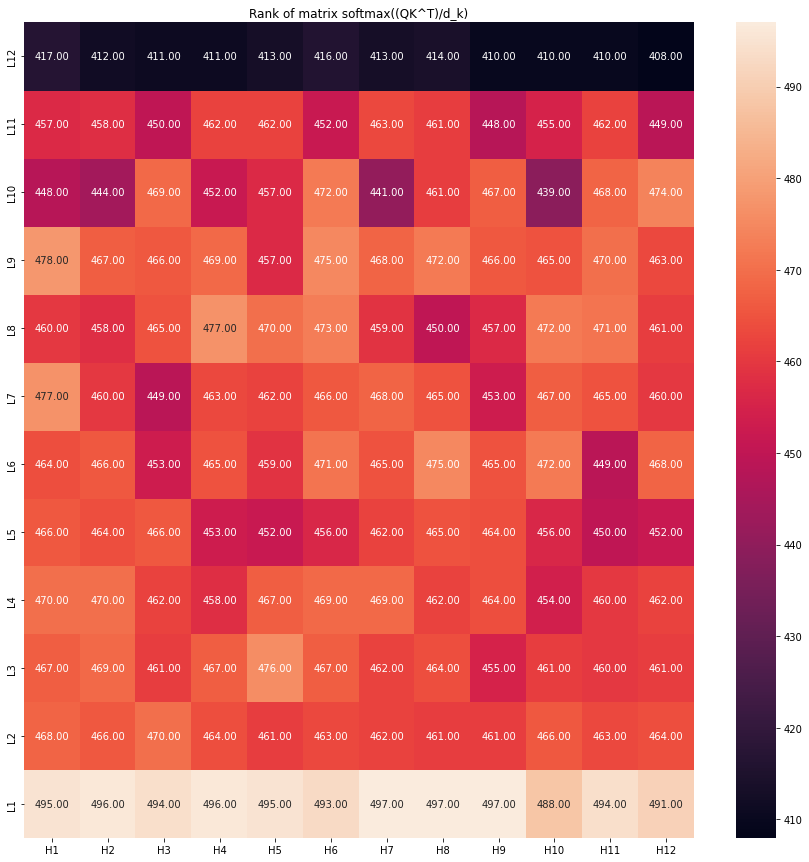

Rank of matrix W_v
  Layer\Head     H1     H2     H3     H4     H5     H6     H7     H8     H9    H10    H11    H12
------------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
          L1  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L2  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L3  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L4  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L5  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L6  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L7  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L8  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L

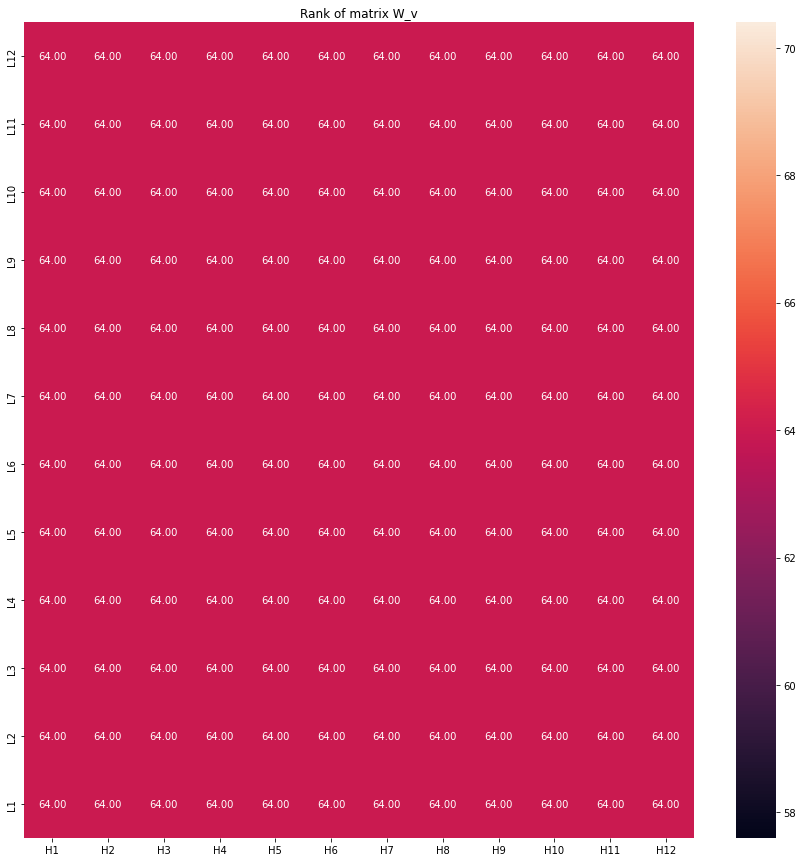

Rank of each head output Z
  Layer\Head     H1     H2     H3     H4     H5     H6     H7     H8     H9    H10    H11    H12
------------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
          L1  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L2  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L3  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L4  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L5  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L6  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L7  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L8  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
   

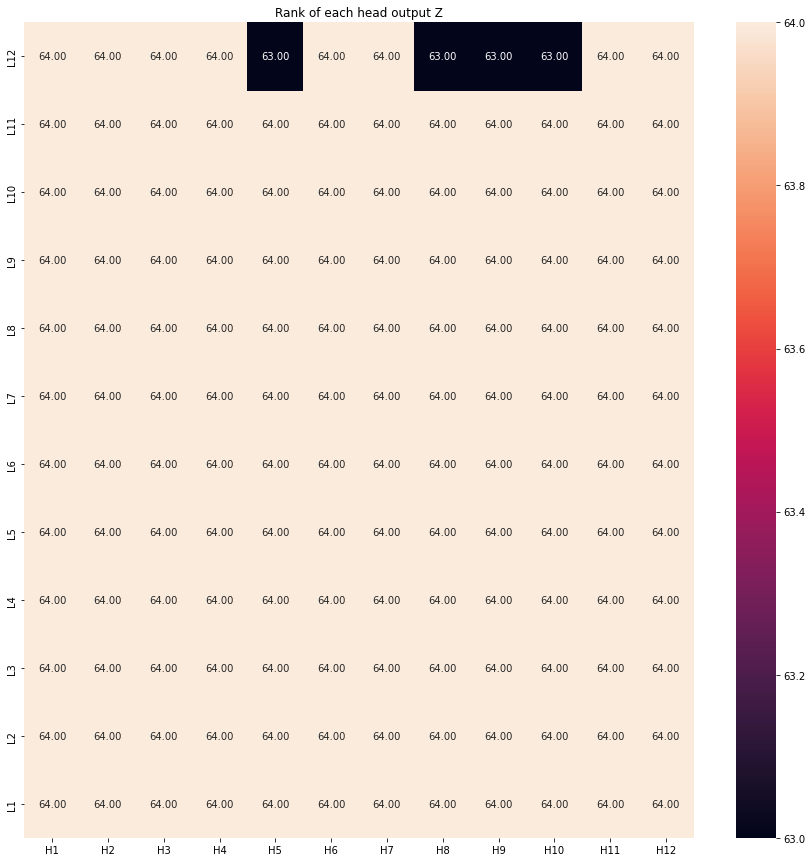

Rank of matrix V
  Layer\Head     H1     H2     H3     H4     H5     H6     H7     H8     H9    H10    H11    H12
------------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
          L1  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L2  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L3  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L4  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L5  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L6  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L7  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L8  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00  64.00
          L9 

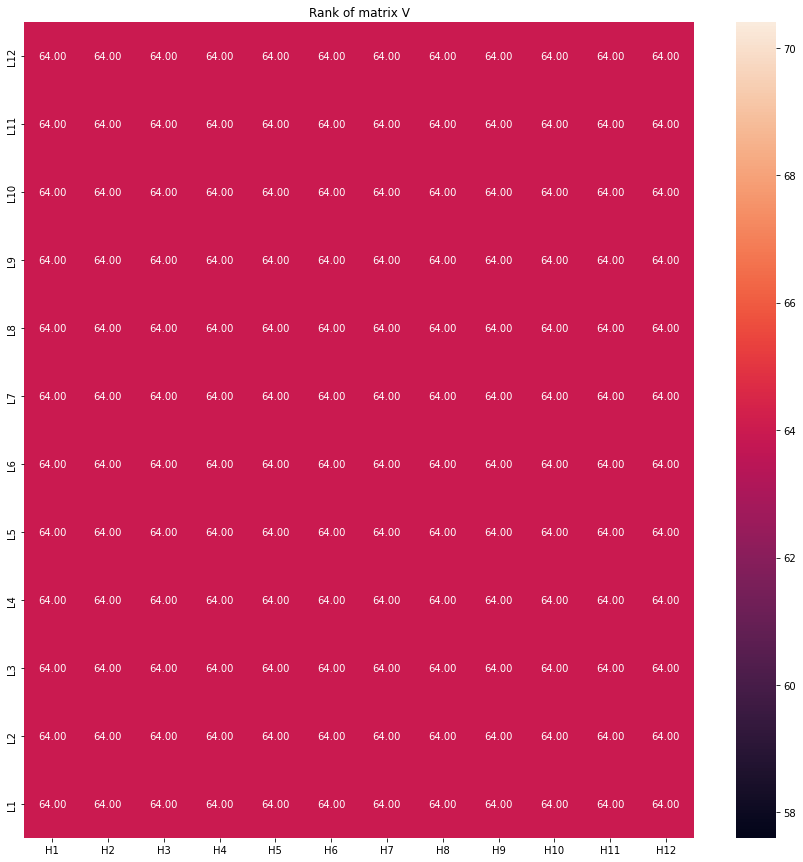

Rank of each layer output Y
[[512.]
 [512.]
 [512.]
 [512.]
 [512.]
 [512.]
 [512.]
 [512.]
 [512.]
 [512.]
 [512.]
 [512.]]



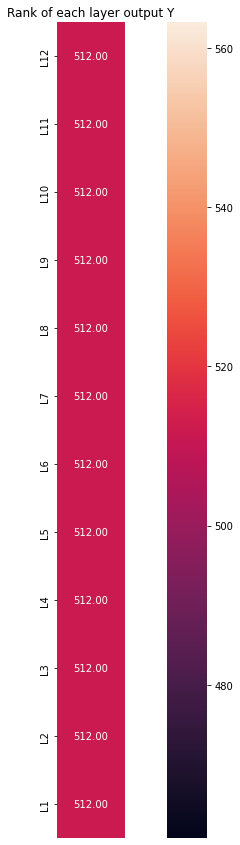

ValueError: ignored

In [59]:
if do_test:
    try:
        test_data_size = sizes_info['test_data_size_seqs'] #-1 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
    except NameError:
        test_data_size = sum(1 for line in open(test_file))

    print(test_data_size)

    with open(test_file) as test_fp, open(log_file, 'a') as log_fp:
        test_reader = csv.reader(test_fp, delimiter=',')
        test_metadata = {'len':test_data_size}
        X_test_generator = DatasetGenerator(test_reader, test_fp, test_metadata)
        test_dataloader = DataLoader(        
                X_test_generator, # The validation samples.
                sampler = SequentialSampler(X_test_generator), # Pull out batches sequentially.
                batch_size = config_dict['EVAL_BATCH_SIZE'], # Evaluate with this batch size.
                num_workers = 0
        )

        if config_dict['TASK_TYPE']=='eigenvalues_analysis' or config_dict['TASK_TYPE']=='singularvalues_ratio_analysis' or config_dict['TASK_TYPE']=='distance_cones_analysis' or config_dict['TASK_TYPE']=='layer_output_analysis':
            selected_layer_head_list = config_dict['SELECTED_LAYER_HEAD_LIST']
            selected_class = config_dict['SELECTED_CLASS']
        else:
            selected_layer_head_list = None
            selected_class = None

        if config_dict['TASK_TYPE']=='singularvalues_ratio_analysis':
            model_base = BertForSequenceClassification.from_pretrained(
                "bert-base-cased", 
                num_labels=config_dict['N_CLASSES'],
                output_attentions = True, # Whether the model returns attentions weights.
                output_hidden_states = True, # Whether the model returns all hidden-states.
            )
            model_base.resize_token_embeddings(len(tokenizer))
            model_base.cuda()

            model_finetuned = model

            print("\n------- Base model -------")
            supervisedBertClassifierTest(
                model_base, 
                test_dataloader,
                log_fp, 
                config_dict['THETA'], 
                selected_layer_head_list=selected_layer_head_list, 
                selected_class=selected_class,
                dir_path=math_interpret_dir,
                title="covid_embeddings_base_model"
                )
            
            print("\n------- Fine-tuned model -------")
            supervisedBertClassifierTest(
                model_finetuned, 
                test_dataloader,
                log_fp, 
                config_dict['THETA'], 
                selected_layer_head_list=selected_layer_head_list, 
                selected_class=selected_class,
                dir_path=math_interpret_dir,
                title="covid_embeddings_finetuned_model"
                )
        else:
            final_data_test, test_accuracies, attentions, timings = supervisedBertClassifierTest(
                model,
                test_dataloader, 
                log_fp, 
                config_dict['THETA'], 
                selected_layer_head_list=selected_layer_head_list, 
                selected_class=selected_class,
                dir_path=math_interpret_dir
                )
        # show_attention_plots(attentions)


In [ ]:
if do_test and config_dict['TASK_TYPE']=='simple_test':
    mean_syn = np.sum(timings) / len(timings)
    std_syn = np.std(timings)
    print(f"Inference time: {mean_syn} ({std_syn})")

In [ ]:
# if config_dict['TASK_TYPE']=='clustering':
#     del final_data_test['seq_ids']
#     del final_data_test['positions']
#     del final_data_test['outputs']
#     del final_data_test['logits']
#     del final_data_test['output_embeddings']
#     gc.collect()

In [ ]:
if do_test or config_dict['TASK_TYPE']=='simple_test' or config_dict['TASK_TYPE']=='clustering':
    # save or load test accuracies:
    if os.path.exists(test_accuracies_file):
        test_accuracies = pickle.load(open(test_accuracies_file, 'rb'))
        #test_results = test_results[0]
    else:         
        # save output data on file for furure computation:
        pickle.dump(test_accuracies, open(test_accuracies_file, 'wb'))

    # save or load test data:
    if os.path.exists(final_data_test_file):
        final_data_test = pickle.load(open(final_data_test_file, 'rb'))
    else:         
        # save output data on file for furure computation:
        pickle.dump(final_data_test, open(final_data_test_file, 'wb'))

#### Test statistics

In [ ]:
if do_test or config_dict['TASK_TYPE']=='simple_test':
    show_test_plots(test_accuracies)

    output_labels_test = np.argmax(final_data_test['outputs'],axis=1)
    target_labels_test = np.argmax(final_data_test['targets'],axis=1)
    output_logits_test = final_data_test['outputs']
    final_statistics(target_labels_test, output_labels_test, output_logits_test, log_file, 'Test') #, logits=final_data_test['logits'])

    if config_dict['SPLIT_DATA_IN_CHUNKS']:
        #per_sample_result_computation(final_data_test, best_positions, taskname="Test")
        per_sample_result_computation(final_data_test, best_positions, taskname="Test", filter_positions=True, filter_score=True, min_score=0.9)

###Attention analysis

In [ ]:
if config_dict['TASK_TYPE']=='attention_analysis' or config_dict['TASK_TYPE']=='attention_flow' or config_dict['TASK_TYPE']=='von_neumann_entropy_attentions' or config_dict['TASK_TYPE']=='shannon_entropy_attentions':
    attention_matrices_file = Path(attention_matrices_dir) / 'attention_matrices_np'
    attention_matrices_thresh_file = Path(attention_matrices_dir) / 'attention_matrices_thresh_np'
    ticks_file = Path(attention_matrices_dir) / 'ticks_np'
    attentions2 = {}

    if os.path.exists(attention_matrices_file):
        attentions2['attentions_all_layers'] = pickle.load(open(attention_matrices_file, 'rb'))
    else: 
        pickle.dump(attentions['attentions_all_layers'], open(attention_matrices_file, 'wb'))
        attentions2['attentions_all_layers'] = attentions['attentions_all_layers']

    if os.path.exists(attention_matrices_thresh_file):
        attentions2['attentions_all_layers_thresh'] = pickle.load(open(attention_matrices_thresh_file, 'rb'))
    else: 
        pickle.dump(attentions['attentions_all_layers_thresh'], open(attention_matrices_thresh_file, 'wb'))
        attentions2['attentions_all_layers_thresh'] = attentions['attentions_all_layers_thresh']

    if os.path.exists(ticks_file):
        attentions2['repr_token_base_positions_axis'] = pickle.load(open(ticks_file, 'rb'))
    else: 
        pickle.dump(attentions['repr_token_base_positions_axis'], open(ticks_file, 'wb'))
        attentions2['repr_token_base_positions_axis'] = attentions['repr_token_base_positions_axis']

In [ ]:
# np.asarray(attentions2['attentions_all_layers'][7][9][11]).max()

In [ ]:
def attention_analysis(attentions, log_fp_test, theta=0, selected_classes=None, selected_layers=None, selected_heads=None):
    # token_base_positions_axis = attentions['token_base_positions_axis']
    # attentions_last_layer = attentions['attentions_last_layer']
    attentions_all_layers = attentions['attentions_all_layers'] if 'attentions_all_layers' in attentions.keys() else None
    attentions_all_layers_thresh = attentions['attentions_all_layers_thresh']
    repr_token_base_positions_axis = attentions['repr_token_base_positions_axis']
    
    attn_last_layers_sum_dir = Path(attention_matrices_dir) / "last_layers_sum"

    for target_label in selected_classes:
        # percentile = None

        for layer in selected_layers:
            if selected_heads == 'avg':
                #calculate the avg of attention matrices of heads of current layer
                attn_mat = attentions_all_layers[target_label][layer].mean(dim=0).cpu().detach().numpy() 
                plt_attentions(attn_mat, 
                            repr_token_base_positions_axis[target_label], 
                            attn_last_layers_sum_dir, 
                            theta=theta,
                            filename=f"{inv_class_labels_dict[int(target_label)]}_{layer+1}",
                            title=f"Average of attention matrices of heads of layer {layer+1} for class '{inv_class_labels_dict[int(target_label)]}', theta = {theta:.3f}",
                            # cmap=colormaps_layers[layer]
                            ) 
            else:
                for head in selected_heads:
                    attn_mat = attentions_all_layers[target_label][layer][head].cpu().detach().numpy() 
                    plt_attentions(attn_mat, 
                            repr_token_base_positions_axis[target_label], 
                            attn_last_layers_sum_dir, 
                            theta=theta,
                            filename=f"{inv_class_labels_dict[int(target_label)]}_{layer+1}_{head+1}",
                            title=f"Attention matrix of head {head+1} of layer {layer+1} for class '{inv_class_labels_dict[int(target_label)]}', theta = {theta:.3f}",
                            # cmap=colormaps_layers[layer]
                            ) 

def attention_analysis_proportions(attentions, log_fp_test, theta=0):
    attentions_all_layers = attentions['attentions_all_layers'] if 'attentions_all_layers' in attentions.keys() else None
    # attentions_all_layers_thresh = attentions['attentions_all_layers_thresh']
    ##### ATTENTIONS BY DOMAIN ######
    show_attentions_for_each_domain(attentions_all_layers, proportion_attn_domains_dir, proportion="attention")
    # show_attentions_for_each_domain(attentions_all_layers_thresh, proportion_attn_domains_dir, proportion="high-attention-tokens-count", theta=theta)
    # attention_pct, pvalues = top_heads_attention_proportions(attentions_all_layers_thresh, proportion="high-confidence-attention", min_total=0, theta=theta)
    # print(f"\nPercentages of attention of maximally attentive heads:\n")
    # print(attention_pct.to_markdown())
    # print(f"\nP-values of attention of maximally attentive heads with respect to background frequencies:\n")
    # print(pvalues.to_markdown())
    # log_fp_test.write(f"\nP-values of attention of maximally attentive heads with respect to background frequencies:\n")
    # log_fp_test.write(f"{pvalues.to_markdown()}\n")
    # log_fp_test.write(f"\nPercentages of attention of maximally attentive heads:\n")
    # log_fp_test.write(f"{attention_pct.to_markdown()}\n")


In [ ]:
if config_dict['TASK_TYPE']=='attention_analysis':
    with open(test_file) as test_fp, open(log_file, 'a') as log_fp:
        selected_classes = [3] #[1]  #range(config_dict['N_CLASSES'])
        selected_layers =[4] #range(n_layers) #[10] #range(n_layers)
        selected_heads = [0] #range(n_heads) #[4] #range(n_heads) #'avg'
        theta_plot = 0.01 #0.01
        attention_analysis(attentions2, log_fp, theta_plot, selected_classes, selected_layers, selected_heads)
        #attention_analysis_proportions(attentions2, log_fp) #theta=0.3

### Attention flow


In [ ]:
#@title Utilities

def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
                
    return adj_mat, labels_to_index 


def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    print("Plot the edges - one by one!")
    for weight in tqdm(unique_weights):
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def get_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def compute_flows(G, labels_to_index, input_nodes, length):
    print("Computing flows")
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in tqdm(labels_to_index):
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_node_flow(G, labels_to_index, input_nodes, output_nodes,length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in output_nodes:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_joint_attention(att_mat, add_residual=True):
    if add_residual:
        residual_att = np.eye(att_mat.shape[1])[None,...]
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(axis=-1)[...,None]
    else:
       aug_att_mat =  att_mat
    
    joint_attentions = np.zeros(aug_att_mat.shape)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0].numpy()
    for i in np.arange(1,layers):
        joint_attentions[i] = aug_att_mat[i].numpy().dot(joint_attentions[i-1])
        
    return joint_attentions

def plot_attention_heatmap(att, s_position, t_positions, sentence):

  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats

def compute_raw_attention_residual_connections(attentions_mat, input_tokens):
    print("Get raw attention mat + residual coonections")
    res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
    res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
    res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
    
    res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=input_tokens)
    return res_adj_mat, res_labels_to_index, res_att_mat


In [ ]:
#title Get raw attention mat + residual coonections
def plot_raw_attention_residual_connections(attentions_mat, input_tokens):
    print("\n============ RAW ATTENTION MAP + RESIDUAL CONNECTIONS ============")
    res_adj_mat, res_labels_to_index, res_att_mat = compute_raw_attention_residual_connections(attentions_mat=attentions_mat, input_tokens=input_tokens)

    plt.figure(figsize=(20,100))
    res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
    return res_G

def plot_attention_rollout(attentions_mat, input_tokens):
    print("\n============ ATTENTION ROLLOUT ============")
    res_adj_mat, res_labels_to_index, res_att_mat = compute_raw_attention_residual_connections(attentions_mat=attentions_mat, input_tokens=input_tokens)
    joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
    joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=input_tokens)
    plt.figure(figsize=(20,100))
    G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])

def plot_attention_flow(attentions_mat, input_tokens, res_G):
    print("\n============ ATTENTION FLOW ============")
    res_adj_mat, res_labels_to_index, res_att_mat = compute_raw_attention_residual_connections(attentions_mat=attentions_mat, input_tokens=input_tokens)
    print("Compute attention flow (this will take quite some time to compute)")
    output_nodes = []
    input_nodes = []
    for key in tqdm(res_labels_to_index):
        if 'L24' in key:
            output_nodes.append(key)
        if res_labels_to_index[key] < attentions_mat.shape[-1]:
            input_nodes.append(key)

    flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])

    plt.figure(figsize=(20,100))
    flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])


def attention_flow(attentions, log_fp_test, selected_classes=None, selected_layers=None, selected_heads=None):
    # token_base_positions_axis = attentions['token_base_positions_axis']
    # attentions_last_layer = attentions['attentions_last_layer']

    for target_label in selected_classes:
        attentions_mat = attentions['attentions_all_layers'][target_label]
        tokens = attentions['repr_token_base_positions_axis'][target_label]
        # domain_start_idx, domain_end_idx = convert_domain_coords_in_token_indices("NTD")
        domain_end_idx = 12
        print(domain_end_idx)
        attentions_mat = attentions_mat[:,:,:domain_end_idx,:domain_end_idx]
        tokens = tokens[:domain_end_idx] 
        print(attentions_mat.shape)
        res_G = plot_raw_attention_residual_connections(attentions_mat, tokens)
        plot_attention_rollout(attentions_mat, tokens)
        plot_attention_flow(attentions_mat, tokens, res_G)



In [ ]:
#@title Analysis
if config_dict['TASK_TYPE']=='attention_flow':
    with open(log_file, 'a') as log_fp:
            selected_classes = [3] #[1]  #range(config_dict['N_CLASSES'])
            attention_flow(attentions2, log_fp, selected_classes)


###Entropy of attention matrices

In [ ]:
def entropy_attentions(type_entropy, attentions, selected_classes, selected_layers, selected_heads, file_fp):
    attentions_all_layers = attentions['attentions_all_layers']
    
    for target_label in selected_classes:
        file_fp.write(f"{type_entropy} entropy {'of eigenvalues ' if type_entropy=='Von-Neumann' else ''}of attention matrices, class '{inv_class_labels_dict[int(target_label)]}'\n")            
    
        VN_entropy_layer_attn_sum = np.zeros(n_layers)
        Sh_entropy_layer_attn_sum = np.zeros(n_layers)

        for layer in selected_layers:
            
            if selected_heads == 'avg':
                #calculate the avg of attention matrices of heads of current layer
                attn_mat_layer = attentions_all_layers[target_label][layer].mean(dim=0).cpu().detach().numpy() 
                if type_entropy=="von_neumann_entropy_attentions":
                    result = compute_Von_Neumann_entropy_eigvals(attn_mat_layer, f"layer_{layer+1}")
                elif type_entropy=="shannon_entropy_attentions":
                    result = compute_Shannon_entropy(attn_mat_layer, f"layer_{layer+1}")
                print(f"\t{type_entropy}_layer_{layer+1} = {result}")
                file_fp.write(f"\t{type_entropy}_layer_{layer+1} = {result}\n")

            else:
                for head in selected_heads:
                    attn_mat_head = attentions_all_layers[target_label][layer][head].cpu().detach().numpy() 
                    if type_entropy=="von_neumann_entropy_attentions":
                        result = compute_Von_Neumann_entropy_eigvals(attn_mat_head, f"head_{head+1}_layer_{layer+1}")
                    elif type_entropy=="shannon_entropy_attentions":
                        result = compute_Shannon_entropy(attn_mat_head, f"head_{head+1}_layer_{layer+1}")
                    print(f"\t{type_entropy}_entropy_head_{head+1}_layer_{layer+1} = {result}")
                    file_fp.write(f"\t{type_entropy}_entropy_head_{head+1}_layer_{layer+1} = {result}\n")

def plot_entropies(attentions, selected_classes, selected_layers, selected_heads):
    attentions_all_layers = attentions['attentions_all_layers']
    VN_entropy_layer_attn_sum = np.zeros(n_layers)
    Sh_entropy_layer_attn_sum = np.zeros(n_layers)
    
    for target_label in selected_classes:
        for layer in selected_layers:
            for head in selected_heads:

                attn_mat_head = attentions_all_layers[target_label][layer][head].cpu().detach().numpy() 

                VN_entropy_attn = compute_Von_Neumann_entropy_eigvals(attn_mat_head, f"head{head+1}_layer_{layer+1}")
                Sh_entropy_attn = compute_Shannon_entropy(attn_mat_head, f"head{head+1}_layer_{layer+1}")

                VN_entropy_layer_attn_sum[layer] += VN_entropy_attn
                Sh_entropy_layer_attn_sum[layer] += Sh_entropy_attn
            
        VN_entropy_layer_attn_mean = VN_entropy_layer_attn_sum / len(selected_heads)
        Sh_entropy_layer_attn_mean = Sh_entropy_layer_attn_sum / len(selected_heads)


        # x = [i+1 for i in range(n_layers)]
        fig, ax = plt.subplots(figsize=(6,6))
        ax.plot(Sh_entropy_layer_attn_mean, 'b', label='Shannon entropy')
        # ax.axis('equal')
        leg = ax.legend()
        plt.title(f"Average Shannon entropy of attention matrices of each layer")
        plt.grid(linestyle = '--')
        ax.set_xticks(range(n_layers))
        ax.set_xticklabels(np.asarray(ax.get_xticks())+1)
        #fig.yticks(list(plt.yticks()[0]) + [1])
        ax.set_xlabel("Layer")
        ax.set_ylabel("Shannon entropy")
        plt.show()
        fig_path = Path(math_interpret_dir) / f'Shannon_entropy_plot.jpg'
        fig.savefig(fig_path, bbox_inches='tight')
        plt.close()


        # x = [i+1 for i in range(n_layers)]
        fig, ax = plt.subplots(figsize=(6,6))
        ax.plot(VN_entropy_layer_attn_mean, 'b', label='VN entropy')
        # ax.axis('equal')
        leg = ax.legend()
        plt.title(f"Average Von Neumann entropy of attention matrices of each layer")
        plt.grid(linestyle = '--')
        ax.set_xticks(range(n_layers))
        ax.set_xticklabels(np.asarray(ax.get_xticks())+1)
        #fig.yticks(list(plt.yticks()[0]) + [1])
        ax.set_xlabel("Layer")
        ax.set_ylabel("VN entropy")
        plt.show()
        fig_path = Path(math_interpret_dir) / f'VN_entropy_plot.jpg'
        fig.savefig(fig_path, bbox_inches='tight')
        plt.close()
                        

In [ ]:
if config_dict['TASK_TYPE']=='von_neumann_entropy_attentions' or config_dict['TASK_TYPE']=='shannon_entropy_attentions':
    attn_eigvals_file = Path(math_interpret_dir) / f"{config_dict['TASK_TYPE']}.txt"
    with open(attn_eigvals_file, 'w') as attn_eigvals_fp:

        selected_classes = [7]  #attentions_all_layers.keys()
        selected_layers = range(n_layers)
        # selected_heads = 'avg'
        # entropy_attentions(config_dict['TASK_TYPE'], attentions2, selected_classes, selected_layers, selected_heads, attn_eigvals_fp)
        selected_heads = range(n_heads)
        # entropy_attentions(config_dict['TASK_TYPE'], attentions2, selected_classes, selected_layers, selected_heads, attn_eigvals_fp)

    plot_entropies(attentions2, selected_classes, selected_layers, selected_heads)

### One-vs-all classification with best tokens

In [ ]:
def get_tick_pos(tick_str):
    ticks_file = Path(attention_matrices_dir) / 'ticks_np'
    ticks = pickle.load(open(ticks_file, 'rb'))
    selected_class_ticks = ticks[config_dict['CLASS_LABELS'][config_dict['POSITIVE_CLASS_MLP']]]
    try:
        idx = [i for i,tick in enumerate(selected_class_ticks) if tick.startswith(tick_str)][0]
        return idx
    except Exception as e: 
        print(f'Exception: tick not found. {e}')
        return None
                            

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, batch_size, input_dim, output_dim, hidden_units_1, hidden_units_2):
    super().__init__()
    self.layers = nn.Sequential(
    #   nn.Flatten(),
      nn.Linear(input_dim, hidden_units_1),
      nn.ReLU(),
      nn.Linear(hidden_units_1, hidden_units_2),
      nn.ReLU(),
      nn.Linear(hidden_units_2, output_dim)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [ ]:
def mlp_train(mlp_batch, mlp, optimizer, loss_function, current_loss):
    # Get inputs
    # mlp_inputs = torch.stack(mlp_batch['input_embeddings'])#.to(device, dtype = torch.long)
    mlp_inputs = torch.tensor(mlp_batch['input_embeddings']) #.to(device, dtype = torch.long)
    mlp_targets = torch.tensor(mlp_batch['targets'])

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    mlp_outputs = mlp(mlp_inputs)
    # Compute loss
    loss = loss_function(mlp_outputs, mlp_targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Print statistics
    current_loss += loss.item()
    if i % 1 == 0:
        print('Loss after mini-batch: %.3f' %
            (current_loss / 10))
        current_loss = 0.0

def supervisedOneVsAllMLP_train(train_dataloader, val_dataloader, log_fp_test):
    gc.collect()
    torch.cuda.empty_cache()

    results = {}

    mlp_step = 0

    relevant_tokens = [get_tick_pos(tick) for tick in config_dict['RELEVANT_TOKENS_MLP']]

    # Set fixed random number seed
    torch.manual_seed(42)
    
    # Initialize the MLP
    mlp = MLP(batch_size=config_dict['TRAIN_BATCH_SIZE_MLP'], 
              input_dim=config_dict['INPUT_DIM_MLP'],
              output_dim=config_dict['OUTPUT_DIM_MLP'], 
              hidden_units_1=config_dict['HIDDEN_UNITS_1_MLP'],
              hidden_units_2=config_dict['HIDDEN_UNITS_2_MLP'])

    # Define the loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

    # Run the training loop
    for epoch in range(0, 5): # 5 epochs at maximum
        print(f'Starting epoch {epoch+1}')
        current_loss = 0.0

        for batch in train_dataloader:
            mlp_batch = {
                'seq_ids': [],
                'targets': [],
                'input_embeddings': []
                }
            # Unpack the inputs from our dataloader
            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.float)
            label_ids = targets.to('cpu').numpy()
            seq_ids = batch['seq_ids'].to('cpu').numpy()

            # Extract input embeddings
            with torch.no_grad():
                outputs = model(ids, 
                            attention_mask=mask,
                            return_dict=True,
                            output_attentions=False,
                            output_hidden_states=True)  

            for sample_idx in range(0, len(seq_ids)):
                # if mlp_step % 1 == 0 and not mlp_step == 0:
                #     print('  Batch {:>5}.'.format(mlp_step))
                mlp_batch['seq_ids'].append(torch.tensor(seq_ids[sample_idx], dtype=torch.int))  
                mlp_batch['targets'].append(torch.tensor(label_ids[sample_idx], dtype=torch.long)) 
                flattened_tokens_embeddings = []
                for token in relevant_tokens:
                    flattened_tokens_embeddings.extend(outputs.hidden_states[0][sample_idx][token])
                mlp_batch['input_embeddings'].append(flattened_tokens_embeddings)     
                # print(np.asarray(mlp_batch).shape)
                # print(len(mlp_batch['input_embeddings'][0][0]))
                # print(outputs.hidden_states[0][sample_idx][71].shape)
                if len(mlp_batch) == config_dict['TRAIN_BATCH_SIZE_MLP']:
                    mlp_step += 1
                    mlp_train(mlp_batch, mlp, optimizer, loss_function, current_loss)
                    mlp_batch['seq_ids'].clear()
                    mlp_batch['targets'].clear()
                    mlp_batch['input_embeddings'].clear()

            if mlp_batch['seq_ids']:
                mlp_step += 1
                mlp_train(mlp_batch, mlp, optimizer, loss_function, current_loss)
                mlp_batch['seq_ids'].clear()
                mlp_batch['targets'].clear()
                mlp_batch['input_embeddings'].clear()
            
        mlp_step=0

    print('DONE.')

    return mlp, results


def supervisedOneVsAllMLP_test(mlp, test_dataloader, log_fp_test):
    gc.collect()
    torch.cuda.empty_cache()

    print('Calculating predictions...')
    log_fp_test.write("\nTest:\n")
    log_fp_test.write("=====\n")
    # Put model in evaluation mode
    model.eval()

    relevant_tokens = [get_tick_pos(tick) for tick in config_dict['RELEVANT_TOKENS_MLP']]

    final_data_test = {'seq_ids' : [],
                'targets' : [],
                'y_preds' : []
                }

    # Set fixed random number seed
    torch.manual_seed(42)

    # Run the training loop
    for batch in test_dataloader:
        # Unpack the inputs from our dataloader
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.float)
        label_ids = targets.to('cpu').numpy()
        seq_ids = batch['seq_ids'].to('cpu').numpy()

        mlp_batch = {
            'seq_ids': [],
            'targets': [],
            'input_embeddings': []
            }

        # Extract input embeddings
        with torch.no_grad():
            outputs = model(ids, 
                        attention_mask=mask,
                        return_dict=True,
                        output_attentions=False,
                        output_hidden_states=True)  

            for sample_idx in range(0, len(seq_ids)):
                # if mlp_step % 5 == 0 and not mlp_step == 0:
                #     print('  Batch {:>5}.'.format(mlp_step))
                mlp_batch['seq_ids'].append(torch.tensor(seq_ids[sample_idx], dtype=torch.int))  
                mlp_batch['targets'].append(torch.tensor(label_ids[sample_idx], dtype=torch.long))  
                flattened_tokens_embeddings = []
                for token in relevant_tokens:
                    flattened_tokens_embeddings.extend(outputs.hidden_states[0][sample_idx][token])
                mlp_batch['input_embeddings'].append(flattened_tokens_embeddings)     
                
                if len(mlp_batch) == config_dict['EVAL_BATCH_SIZE_MLP']:
                    mlp_inputs = torch.tensor(mlp_batch['input_embeddings']) #.to(device, dtype = torch.long)
                    y_pred = mlp(mlp_inputs)
                    mlp_batch['seq_ids'].clear()
                    mlp_batch['targets'].clear()
                    mlp_batch['input_embeddings'].clear()

            if mlp_batch['seq_ids']:
                mlp_inputs = torch.tensor(mlp_batch['input_embeddings']) #.to(device, dtype = torch.long)
                y_pred = mlp(mlp_inputs)
                mlp_batch['seq_ids'].clear()
                mlp_batch['targets'].clear()
                mlp_batch['input_embeddings'].clear()

        final_data_test['seq_ids'].extend(seq_ids)
        final_data_test['targets'].extend(label_ids)
        final_data_test['y_preds'].extend(y_pred)

    print('DONE.')
    return final_data_test

#### Train

In [ ]:
if config_dict['TASK_TYPE']=='one_vs_all_classification':
    selected_class = config_dict['POSITIVE_CLASS_MLP']
    relevant_tokens_pos = config_dict['RELEVANT_TOKENS_MLP']

    with open(train_file) as train_fp, open(val_file) as val_fp, open(log_file, 'a') as log_fp:

        train_reader = csv.reader(train_fp, delimiter=',')
        train_metadata = {'len':sizes_info['train_data_size']}
        X_train_generator = DatasetGenerator_InputEmbeddings(train_fp, train_metadata) 
        train_dataloader = DataLoader(
                X_train_generator,  # The training samples.
                sampler = RandomSampler(X_train_generator), # Select batches randomly
                batch_size = config_dict['TRAIN_BATCH_SIZE_MLP'], # Trains with this batch size.
                num_workers = 0
        )
        
        val_reader = csv.reader(val_fp, delimiter=',')
        val_metadata = {'len':sizes_info['val_data_size']}
        X_val_generator = DatasetGenerator_InputEmbeddings(val_fp, val_metadata) #.batch(EVAL_BATCH_SIZE)

        validation_dataloader = DataLoader(
                X_val_generator, # The validation samples.
                sampler = SequentialSampler(X_val_generator), # Pull out batches sequentially.
                batch_size = config_dict['EVAL_BATCH_SIZE_MLP'], # Evaluate with this batch size.
                num_workers = 0
        )

        mlp, results = supervisedOneVsAllMLP_train(train_dataloader, validation_dataloader, log_fp)

        # final_statistics(target_labels, output_labels, log_file)

####Test

In [ ]:
if config_dict['TASK_TYPE']=='one_vs_all_classification':    
    try:
        test_data_size = sizes_info['test_data_size_seqs']-1
    except NameError:
        test_data_size = sum(1 for line in open(test_file))

    n_log_files = len(os.listdir(log_dir_bio))
    if n_log_files > 0:
        log_file_mlp = Path(log_dir_bio) / f'log_mlp({n_log_files}).txt'
    else:
        log_file_mlp = Path(log_dir_bio) / f'log_mlp.txt'

    with open(test_file) as test_fp, open(log_file_mlp, 'a') as log_fp:
        test_reader = csv.reader(test_fp, delimiter=',')
        test_metadata = {'len':test_data_size}
        X_test_generator = DatasetGenerator_InputEmbeddings(test_fp, test_metadata)
        test_dataloader = DataLoader(        
                X_test_generator, # The validation samples.
                sampler = SequentialSampler(X_test_generator), # Pull out batches sequentially.
                batch_size = config_dict['EVAL_BATCH_SIZE'], # Evaluate with this batch size.
                num_workers = 0
        )

        if config_dict['TASK_TYPE']=='eigenvalues_analysis':
            selected_layer_head_list = [[1-1,4-1], [12-1,9-1], [11-1, 5-1]]
        else:
            selected_layer_head_list = None

        final_data_test = supervisedOneVsAllMLP_test(
            mlp,
            test_dataloader, 
            log_fp
            )

In [ ]:
if config_dict['TASK_TYPE']=='one_vs_all_classification':    
    with open(log_file_mlp, 'a') as log_fp:
        seq_ids = torch.tensor(final_data_test['seq_ids']).to('cpu')
        targets = torch.tensor(final_data_test['targets']).to('cpu').numpy()
        y_preds = [np.argmax(prediction.numpy()) for prediction in final_data_test['y_preds']]

        print(targets[:10])
        print(np.unique(np.asarray(targets[:])))
        target_names={'mu':1, 'other':0}

    final_statistics(targets, y_preds, log_file_mlp, 'Test', target_names=target_names) #, logits=final_data_test['logits'])

In [ ]:
# plot_color_gradients(colormaps, {v:k for k, v in config_dict['CLASS_LABELS'].items()}, 'Attention scores colormaps for each class')
# plot_color_gradients(colormaps_layers, range(n_layers), 'Attention scores colormaps for each layer')

### Analysis of eigenvalues of weights of Qi and Ki

In [ ]:
# model.parameters
print(f'{"parameter": <55}: {"mean": <20} (std)')
print()
for name,param in model.named_parameters():
    if name.endswith("attention.output.LayerNorm.weight"):
        print(f'{name: <55}: {torch.mean(param): <20} ({torch.std(param)})')
print()
for name,param in model.named_parameters():
    if name.endswith("attention.output.LayerNorm.bias"):
        print(f'{name: <55}: {torch.mean(param): <20} ({torch.std(param)})')
print()
for name,param in model.named_parameters():
    if name.endswith("output.LayerNorm.weight") and not name.endswith("attention.output.LayerNorm.weight"):
        print(f'{name: <55}: {torch.mean(param): <20} ({torch.std(param)})')
print()
for name,param in model.named_parameters():
    if name.endswith("output.LayerNorm.bias") and not name.endswith("attention.output.LayerNorm.bias"):
        print(f'{name: <55}: {torch.mean(param): <20} ({torch.std(param)})')
# print(model.parameters)

# model_params = dict(model.named_parameters())
# model_params["encoder.layer.0.attention.output.LayerNorm.bias"].data.cpu().detach().numpy()

In [ ]:
def compute_head_weights_eigenvalues(model, dir_path):
    layer_query_weight_names = [f'bert.encoder.layer.{l}.attention.self.query.weight' for l in range(n_layers)]
    layer_key_weight_names = [f'bert.encoder.layer.{l}.attention.self.key.weight' for l in range(n_layers)]
    model_params = dict(model.named_parameters())
    for layer in np.flip(range(n_layers)):
        w_q = model_params[layer_query_weight_names[layer]].data
        w_k = model_params[layer_key_weight_names[layer]].data
        emb_dim = w_q.shape[0]
        d_k = int(emb_dim / n_heads)
                
        weights_prod = np.matmul(w_q, w_k.T)

        eigenvals = np.linalg.eigvals(weights_prod)
        print(eigenvals)
        return
        eigenvals_count = {}
        eigenvals_count['positive'] = sum([1 for x in eigenvals if x>0])
        eigenvals_count['negative'] = sum([1 for x in eigenvals if x<0])
        eigenvals_count['zero'] = sum([1 for x in eigenvals if x==0])
        
        #eigenvals_count = collections.Counter(eigenvals)
        print(f"n. unique eigenvalues = {len(np.unique(eigenvals))}")
        fig=plt.figure(figsize=(8,8))
        # print(np.sort_complex(eigenvals)[:10])
        plt.bar(range(len(eigenvals_count.keys())), eigenvals_count.values(), align='center', width=0.8)
        plt.xticks(range(len(eigenvals_count.keys())), eigenvals_count.keys(), rotation=45, fontsize=12)
        plt.title(f"Eigenvalues for layer {layer+1}")
        plt.show()
        fig_path = Path(dir_path) / f'{layer+1}.jpg'
        fig.savefig(fig_path, bbox_inches='tight', pad_inches=0)
        plt.close()

        # for i in range(n_heads):
        #     w_q_i = w_q[:, i*d_k : i*d_k + d_k]
        #     w_k_i = w_k[:, i*d_k : i*d_k + d_k]
        #     weights_prod = np.matmul(w_q_i, w_k_i.T)
        #     eigenvals = np.linalg.eigvals(weights_prod)
        #     eigenvals_count = {}
        #     eigenvals_count['positive'] = sum([1 for x in eigenvals if x>0])
        #     eigenvals_count['negative'] = sum([1 for x in eigenvals if x<0])
        #     eigenvals_count['zero'] = sum([1 for x in eigenvals if x==0])
            
        #     #eigenvals_count = collections.Counter(eigenvals)
        #     print(f"n. unique eigenvalues = {len(np.unique(eigenvals))}")
        #     plt.figure(figsize=(8,8))
        #     # print(np.sort_complex(eigenvals)[:10])
        #     plt.bar(range(len(eigenvals_count.keys())), eigenvals_count.values(), align='center', width=0.8)
        #     plt.xticks(range(len(eigenvals_count.keys())), eigenvals_count.keys(), rotation=45, fontsize=12)
        #     plt.title(f"Eigenvalues for head {i+1} layer {layer+1}")
        #     plt.show()
        #     fig_path = Path(dir_path) / f'{layer+1}_{i+1}.jpg'
        #     fig.savefig(fig_path, bbox_inches='tight', pad_inches=0)
        #     plt.close()

def compute_max_bias(model):
    layer_query_weight_names = [f'bert.encoder.layer.{l}.attention.self.query.bias' for l in range(n_layers)]
    layer_key_weight_names = [f'bert.encoder.layer.{l}.attention.self.key.bias' for l in range(n_layers)]
    model_params = dict(model.named_parameters())
    for layer in np.flip(range(n_layers)):
            bias_q = model_params[layer_query_weight_names[layer]].data
            bias_k = model_params[layer_key_weight_names[layer]].data
            print(f"layer {layer}")
            print(f"\tbias_q={len(bias_q)}")
            print(f"\tbias_k={len(bias_k)}")

def hist_Wq_WkT(model):
    layer_query_weight_names = [f'bert.encoder.layer.{l}.attention.self.query.weight' for l in range(n_layers)]
    layer_key_weight_names = [f'bert.encoder.layer.{l}.attention.self.key.weight' for l in range(n_layers)]
    model_params = dict(model.named_parameters())
    
    for layer in np.flip(range(n_layers)):
        W_q = model_params[layer_query_weight_names[layer]].data.cpu().detach().numpy()
        W_k = model_params[layer_key_weight_names[layer]].data.cpu().detach().numpy()
        emb_dim = W_q.shape[0]
        d_k = int(emb_dim / n_heads)
        head = 0
        W_q_i = W_q[:, head*d_k : head*d_k + d_k]
        W_k_i = W_k[:, head*d_k : head*d_k + d_k]        
        weights_prod = np.matmul(W_q_i, W_k_i.T)
        fig, ax = plt.subplots(figsize=(15,10))
        ax.set_aspect('equal')
        sns.heatmap(weights_prod)
        plt.show()
        
        heat_dir = Path(math_interpret_dir) / "heatmaps_Wq_WkT"
        if not os.path.exists(heat_dir):
            os.makedirs(heat_dir)
            print(f"Directory '{heat_dir}' created")
        fig_path = Path(heat_dir) / f'heatmap_Wq_WkT_L{layer+1}_H1.jpg'
        fig.savefig(fig_path)


In [ ]:
if config_dict['TASK_TYPE'] == 'eigenvalues_analysis':
    head_weights_eigenvalues = compute_head_weights_eigenvalues(model, math_interpret_dir)
    compute_max_bias(model)
    hist_Wq_WkT(model)

### Clustering

In [ ]:
def plot_PCA_explained_variance(pca, filepath=None):
    fig = plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative")
    plt.plot(pca.explained_variance_ratio_, label="Normal")
    plt.legend()
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance')
    plt.show()
    if filepath is not None:
        fig.savefig(filepath)

def plot_Pareto(pca, title=None, filepath=None):
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(12)
    plt.rcParams.update({'font.size': 12})
    plt.title(f"Pareto chart - {title}")
    ax.set_xticks(range(len(pca.explained_variance_ratio_)))
    ax.set_xticklabels(range(1,len(pca.explained_variance_ratio_)+1))
    ax.set_xlabel("Principal component")
    ax.set_ylabel("Explaned variance")
    ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color="C0")
    ax2 = ax.twinx()
    ax2.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_)*100, color="C1", marker="D", ms=10)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.show()
    if filepath is not None:
        fig.savefig(Path(filepath)/'pareto.jpg')

def plot_2D_PCA(X_pca, y, cdict, filepath=None):
    Xax = X_pca[:,0]
    Yax = X_pca[:,1]

    labl = inv_class_labels_dict

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    fig.patch.set_facecolor('white')
    for l in np.unique(y):
        ix=np.where(y==l)
        ax.scatter(Xax[ix], Yax[ix], c=cdict[l], s=40,
                label=labl[l], alpha=0.7)
        
    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)

    ax.legend()
    plt.show()
    if filepath is not None:
        fig.savefig(filepath)

def plot_3D_PCA(pca, X_pca, y, cdict, title=None):
    y_labels = [inv_class_labels_dict[i] for i in y]
    total_var = pca.explained_variance_ratio_.sum() * 100

    fig = px.scatter_3d(
        X_pca, x=0, y=1, z=2, color=y_labels, 
        title=f'PCA - {title} - Total Explained Variance: {total_var:.2f}%',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        width=1000, height=800,
    )
    fig.update_traces(marker_size=5)
    fig.show()

# def plot_3D_PCA(X_pca, y, cdict, filepath=None):
#     Xax = X_pca[:,0]
#     Yax = X_pca[:,1]
#     Zax = X_pca[:,2]

#     labl = inv_class_labels_dict

#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111, projection='3d')

#     fig.patch.set_facecolor('white')
#     for l in np.unique(y):
#         ix=np.where(y==l)
#         ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
#                 label=labl[l], alpha=0.7)
#     # for loop ends
#     ax.set_xlabel("PC1", fontsize=14)
#     ax.set_ylabel("PC2", fontsize=14)
#     ax.set_zlabel("PC3", fontsize=14)

#     ax.legend()
#     plt.show()
#     if filepath is not None:
#         fig.savefig(filepath)

def plot_3D_TSNE(tsne_results, y, cdict, title=None):
    y_labels = [inv_class_labels_dict[i] for i in y]
    fig = px.scatter_3d(
        tsne_results, x=0, y=1, z=2, color=y_labels, 
        labels=inv_class_labels_dict,
        width=1000, height=800,
        title=f"T-SNE - {title}",
    )
    fig.update_traces(marker_size=5)
    fig.show()

def visualize(X, y, selected_classes, title, filepath):
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        print(f"Directory '{filepath}' created")

    X_df = pd.DataFrame(list(zip(X, y)),
               columns =['X', 'y'])
    X_filtered = X_df[X_df['y'].isin(selected_classes)]
    n_components_tot = min(np.asarray(X).shape[1], len(selected_classes))
    n_components = min(3, np.asarray(X).shape[1], len(selected_classes))

    X = X_filtered['X'].to_list()
    y = X_filtered['y'].to_list()
    cdict = {i:c for i, c in enumerate(list(TABLEAU_COLORS.keys()))}
    # cdict_tsne = [c for i, c in enumerate(cdict) if i in selected_classes]

    pca = PCA(n_components=n_components_tot)
    pca.fit(X)
    # plot_PCA_explained_variance(pca, filepath)
    plot_Pareto(pca, title, filepath)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    if n_components > 2:
        plot_3D_PCA(pca, X_pca, y, cdict, title)
    else:
        plot_2D_PCA(X_pca, y, cdict, filepath)

    tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(X)

    plot_3D_TSNE(tsne_results, y, cdict, title)

def cluster(method, X, y, filepath):
    y_clusters = method.fit_predict(X)
    selected_classes = list(config_dict['CLASS_LABELS'].values())
    # visualize(X_softmax, y_clusters, selected_classes, filepath)
    print(f'\nHomogeneity = {metrics.homogeneity_score(y, y_clusters)}')
    print(f'Completeness = {metrics.completeness_score(y, y_clusters)}')
    print(f'Adjusted Rand Index = {metrics.adjusted_rand_score(y, y_clusters)}')
    return method

In [ ]:
# dict(model.named_parameters()).keys()


In [ ]:
if config_dict['TASK_TYPE']=='clustering': 
    y = np.argmax(final_data_test['targets'],axis=1)
    selected_classes = list(config_dict['CLASS_LABELS'].values())
    # del final_data_test['positions']
    gc.collect()

####Input embeddings

In [ ]:
if config_dict['TASK_TYPE']=='clustering': 
    # print(np.asarray(final_data_test["input_embeddings"]).shape)
    X_input = np.asarray(final_data_test["input_embeddings"])[:,1:]
    X_input = X_input.reshape((X_input.shape[0],X_input.shape[1]*X_input.shape[2]))

    filepath = Path(clustering_dir) / 'input_embeddings'

    # visualize(X_input, y, selected_classes, "Input embeddings", filepath)

    dbscan1 = DBSCAN(eps=325, n_jobs=-1)
    dbscan = cluster(dbscan1, X_input, y, filepath)
    print(set(dbscan.labels_))

    del X_input
    gc.collect()

####Encoder embedding outputs

In [ ]:
if config_dict['TASK_TYPE']=='clustering': 

    X_emb = np.asarray(final_data_test["output_embeddings"])[:, 1:] # dim: n_training_samples x d_model = 1439 x 512 x 768 
    print(X_emb.shape)
    X_emb = X_emb.reshape((X_emb.shape[0],X_emb.shape[1]*X_emb.shape[2]))
    print(X_emb.shape)

    filepath = Path(clustering_dir) / 'output_embeddings'
    selected_classes = list(config_dict['CLASS_LABELS'].values())

    # visualize(X_emb, y, selected_classes, "Encoder embedding outputs", filepath)

    dbscan1 = DBSCAN(eps=325, n_jobs=-1)
    dbscan = cluster(dbscan1, X_emb, y, filepath)
    print(set(dbscan.labels_))

    del X_emb
    gc.collect()

#### CLS embedding outputs

In [ ]:
if config_dict['TASK_TYPE']=='clustering': 
# experiments on encoder output
    X_CLS_emb = np.asarray(final_data_test["output_embeddings"])[:, 0] # dim: n_training_samples x d_model = 1439 x 512 x 768 
    print(X_CLS_emb.shape)
    # X_CLS_emb = X_CLS_emb.reshape((X_CLS_emb.shape[0],X_CLS_emb.shape[1]*X_CLS_emb.shape[2]))
    # print(X_CLS_emb.shape)

    filepath = Path(clustering_dir) / 'output_embedding_CLS'

    visualize(X_CLS_emb, y, selected_classes, "CLS embedding output", filepath)

    # dbscan1 = DBSCAN(eps=10, n_jobs=-1)
    # dbscan = cluster(dbscan1, X_CLS_emb, y, filepath)
    # print(set(dbscan.labels_))

    del X_CLS_emb
    gc.collect()

#### Pre-softmax

In [ ]:
if config_dict['TASK_TYPE']=='clustering': 
# experiments on encoder output
    X_pre_softmax = np.asarray(final_data_test["logits"]) # dim: n_training_samples x d_model = 1439 x 512 x 768 
    print(X_pre_softmax.shape) 

    filepath = Path(clustering_dir) / 'pre_softmax'
    
    visualize(X_pre_softmax, y, selected_classes, "Pre-Softmax", filepath)

    # dbscan1 = DBSCAN(eps=5, n_jobs=-1)
    # dbscan = cluster(dbscan1, X_pre_softmax, y, filepath)
    # print(set(dbscan.labels_))

    del X_pre_softmax
    gc.collect()

####Post-softmax

In [ ]:
if config_dict['TASK_TYPE']=='clustering': 

    # experiments on softmax output
    X_softmax = np.asarray(final_data_test["outputs"]) # dim: n_training_samples x n_classes = 1439 x 8 
    print(X_softmax.shape)
    filepath = Path(clustering_dir) / 'post_softmax'
    
    visualize(X_softmax, y, selected_classes, "Post-Softmax", filepath)

    # dbscan1 = DBSCAN(eps=0.35, n_jobs=-1)
    # dbscan = cluster(dbscan1, X_softmax, y, filepath)
    # print(set(dbscan.labels_))

    del X_softmax
    gc.collect()

    # selected_classes = [config_dict['CLASS_LABELS']['beta'], config_dict['CLASS_LABELS']['mu'], config_dict['CLASS_LABELS']['gh']]

#### CLS layers embedding outputs

In [ ]:
if config_dict['TASK_TYPE']=='clustering': 
    sel_layers = [1,3,5,7,9,11]
    # sel_layers = [11]
    X_CLS_l_emb = []

    for l in sel_layers:
        X_CLS_l_emb = np.loadtxt(open(Path(CLS_embeddings_dir) / f"CLS_Y_output_L{l}.csv"), delimiter=",")
        print(X_CLS_l_emb.shape)
        filepath = Path(clustering_dir) / f'CLS_L{l}'
    
        visualize(X_CLS_l_emb, y, selected_classes, f"L{l}_embeddings_CLS", filepath)

        # dbscan1 = DBSCAN(eps=13, n_jobs=-1)
        # dbscan = cluster(dbscan1, X_CLS_l_emb, y, filepath)
        # print(set(dbscan.labels_))

        del X_CLS_l_emb
        gc.collect()

In [ ]:
print('Done')